In [360]:
#!/usr/bin/env python3
# star_network_identify.py
# ---------------------------------------------------------------
"""
Identify star-like network topologies (A/B/C) from time-series produced by a
high-precision coupled map lattice (CML). The workflow is:

1) Simulate node dynamics on directed star graphs with high numerical precision.
2) Compute node-wise error strengths ‖x_{t+1} - 2 x_t‖ (wrapped on the circle).
3) Use a 2-component Gaussian Mixture Model (GMM) to separate hubs vs. leaves.
4) With two segments (from B/C candidates), compare hubs' residual variances to
   decide whether a segment came from type-B (both hubs fully connected) or
   type-C (leaves split across two hubs).

Conventions
-----------
- Adjacency A is binary and directed. A[j, i] = 1 means a directed edge j → i,
  i.e., node j contributes to the coupling term of node i.
- Trajectories are stored as a NumPy array of shape (N, T_seg), with N nodes
  and T_seg time steps after discarding transients.
"""

from __future__ import annotations
from decimal import Decimal, getcontext
import numpy as np
import mpmath as mp
from typing import Callable, Tuple
from sklearn.mixture import GaussianMixture








In [361]:
#基础定义图动力系统

In [401]:
# ---------- Global High Precision Settings ----------
getcontext().prec = 200
mp.mp.dps = getcontext().prec
TWOPI = mp.mpf('6.283185307179586476925286766559')
SIGMA_H2 = 0.5  # ∫ h^2(0,y) dm(y)  (kept for reference; not used directly)
# -------------------- 小工具：安全转 Decimal --------------------
def _to_dec(x) -> Decimal:
    """用 str 路径避免二进制浮点误差。"""
    if isinstance(x, Decimal):
        return x
    return Decimal(str(x))
#定义图动力系统
# ------------------------------------------------------------------
#  I. High-Precision Network System (unchanged)
# ------------------------------------------------------------------
class GraphSystemDecimal:
    """
    Coupled map lattice on a directed graph with high-precision arithmetic.

    Each node evolves via a local map (default: doubling map x ↦ 2x mod 1),
    plus diffusive sinusoidal coupling from its in-neighbors.

    Parameters
    ----------
    A : np.ndarray
        Directed adjacency matrix of shape (N, N). A[j, i] = 1 indicates j → i.
    alpha : str, optional
        Coupling strength as a decimal string (for exact Decimal parsing).
    local_map : Callable[[Decimal], Decimal], optional
        Local map f(x). Defaults to doubling map `(2*x) % 1`.
    coupling_fn : Callable[[Decimal, Decimal], Decimal], optional
        Pairwise coupling c(x_s, x_t) from source s to target t. If None,
        uses a sinusoidal diffusive term `-sin(2π x_s) + sin(2π x_t)`.
    seed : int, optional
        Random seed for initial conditions.

    Attributes
    ----------
    N : int
        Number of nodes.
    Delta : float
        Maximum out-degree (max column sum) used for normalization.
    x : list[Decimal]
        Current node states.
    t : int
        Current time step.

    Notes
    -----
    - High precision is enforced via Python's Decimal and mpmath.
    - The coupling increment at node i is normalized by Delta.
    """

    def __init__(self, A: np.ndarray, alpha: str = '0.25',
                 local_map: Callable[[Decimal], Decimal] | None = None,
                 coupling_fn: Callable[[Decimal, Decimal], Decimal] | None = None,
                 savepath=None,
                 seed: int = 0):
        self.A = np.asarray(A, dtype=float)
        self.N = self.A.shape[0]
        self.Delta = self.A.sum(axis=0).max()
        self.alpha = Decimal(alpha)
        self.local_map = local_map or (lambda x: (Decimal(2) * x) % 1)
        self.coupling = coupling_fn or self._default_coupling
        self.rng = np.random.default_rng(seed)
        self.reset()

    @staticmethod
    def _default_coupling(xs: Decimal, xt: Decimal) -> Decimal:
        """
        Default sinusoidal diffusive coupling.

        Parameters
        ----------
        xs : Decimal
            Source node state.
        xt : Decimal
            Target node state.

        Returns
        -------
        Decimal
            c(xs, xt) = -sin(2π xs) + sin(2π xt), as a Decimal.
        """
        v = -mp.sin(TWOPI * mp.mpf(str(xs))) + mp.sin(TWOPI * mp.mpf(str(xt)))
        return Decimal(str(v))

    def _coupling_term(self):
        """
        Compute normalized coupling increment for each node.

        Returns
        -------
        list[Decimal]
            A list of length N with the coupling increment for each node,
            normalized by the maximum out-degree Δ.

        Notes
        -----
        The increment for node i is the sum over j with A[j, i] = 1 of
        c(x_j, x_i), divided by Δ to keep scales comparable across graphs.
        """
        incr = [Decimal(0)] * self.N
        for j in range(self.N):
            if self.A[j].sum() == 0:
                continue  # node j has no outgoing edges
            for i in range(self.N):
                if self.A[j, i]:
                    incr[i] += self.coupling(self.x[j], self.x[i])
        d = Decimal(str(self.Delta))
        return [v / d for v in incr]

    def step(self):
        """
        Advance the system by one time step.

        Returns
        -------
        list[Decimal]
            The updated state vector x_{t+1} (length N) as Decimals.
        """
        xn = [self.local_map(x) for x in self.x]  # local map update
        coup = self._coupling_term()              # diffusive coupling
        xn = [(xi + self.alpha * ci) % 1 for xi, ci in zip(xn, coup)]
        self.x = xn
        self.t += 1
        return xn

    def reset(self):
        """
        Reset the system to a fresh random initial condition.

        Notes
        -----
        States are sampled i.i.d. ~ Uniform(0, 1) and stored as Decimal.
        """
        self.x = [Decimal(str(v)) for v in self.rng.random(self.N)]
        self.t = 0

    def run(self, T: int, discard: int = 0):
        """
        Simulate for T time steps and return the trajectory after discarding transients.

        Parameters
        ----------
        T : int
            Total number of steps to simulate.
        discard : int, optional
            Number of initial steps to discard as transients.

        Returns
        -------
        np.ndarray
            Array of shape (N, max(0, T - discard)) with float64 views of states.
        """
        traj = np.zeros((self.N, max(0, T - discard)))
        for k in range(T):
            xt = self.step()
            if k >= discard:
                traj[:, k - discard] = [float(v) for v in xt]
        return traj
    def plot_graph(self,
                   hubs=None,
                   save_to_file: bool = False,
                   filepath: str | None = None,
                   hub_detect_threshold: float = 0.8,
                   node_size_leaf: int = 80,
                   node_size_hub: int = 180,
                   cmap_name: str = "viridis",
                   with_colorbar: bool = True,
                   show_labels: bool = False,
                   savepath: str | None = None,
                   seed: int = 0):
        """
        可视化当前邻接矩阵 A 的有向图（美观布局）：
        - 1 hub: 放中心；2 hubs: 居中左右对称。
        - 叶子按簇在外圈弧段排列。
        - 颜色按入度渐变；枢纽用更大点且黑描边区分。

        参数
        ----
        hubs : None | array-like[int]
            枢纽索引（0-based）。若为 None，按入度 >= 0.8 * max 入度 自行推断。
        save_to_file : bool
            True 保存到文件；False 直接 plt.show()。
        filepath : str | None
            保存路径（当 save_to_file=True 时必填）。
        hub_detect_threshold : float
            自动识别枢纽的阈值系数（相对最大入度）。
        node_size_leaf / node_size_hub : int
            叶子 / 枢纽节点的散点大小。
        cmap_name : str
            渐变色图名（如 'viridis', 'plasma', 'magma'）。
        with_colorbar : bool
            是否显示入度 colorbar。
        show_labels : bool
            是否在节点旁标注编号。
        seed : int
            仅用于 B 型“平分分组”时的随机打散顺序。
        """
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib import cm, colors as mcolors

        A = self.A
        N = self.N
        rng = np.random.default_rng(seed)

        # -------- 基本统计：入度/出度、枢纽集 --------
        indeg = A.sum(axis=0)  # 列和：入度
        outdeg = A.sum(axis=1) # 行和：出度（hub 应为 0）

        if hubs is None:
            max_in = float(indeg.max()) if N > 0 else 0.0
            if max_in <= 0:
                hubs_idx = np.array([], dtype=int)
            else:
                hubs_idx = np.where(indeg >= hub_detect_threshold * max_in)[0]
                if hubs_idx.size == 0:
                    hubs_idx = np.array([int(np.argmax(indeg))])
        else:
            hubs_idx = np.atleast_1d(np.asarray(hubs, dtype=int))

        hubs_idx = hubs_idx.tolist()
        leaf_idx = [i for i in range(N) if i not in hubs_idx]

        # -------- 分簇（用于 2 个枢纽时的叶子“归属”）--------
        def _split_leaves_for_two_hubs(h1, h2):
            if len(leaf_idx) == 0: return [], []
            # 依据与 hub 的连接把叶子分两簇；B 型（两边都连）则随机/按索引平分
            to_h1 = A[leaf_idx, h1] > 0
            to_h2 = A[leaf_idx, h2] > 0
            g1, g2, both = [], [], []
            for k, i in enumerate(leaf_idx):
                if to_h1[k] and not to_h2[k]:
                    g1.append(i)
                elif to_h2[k] and not to_h1[k]:
                    g2.append(i)
                elif to_h1[k] and to_h2[k]:
                    both.append(i)
                else:
                    # 未直连任意 hub 的叶子：按较大入度归类（退化保护）
                    (g1 if indeg[h1] >= indeg[h2] else g2).append(i)
            if both:
                order = rng.permutation(len(both))
                half = len(both)//2
                g1.extend([both[i] for i in order[:half]])
                g2.extend([both[i] for i in order[half:]])
            return g1, g2

        # -------- 布局：坐标 pos[i]=(x,y) --------
        pos = np.zeros((N, 2), dtype=float)
        R = 1.0      # 叶子环半径
        r0 = 0.28    # 两个 hub 的半径（中心向左右偏移）

        if len(hubs_idx) <= 1:
            # 1 个 hub：中心
            if hubs_idx:
                pos[hubs_idx[0]] = (0.0, 0.0)
            # 所有叶子均匀环形
            L = len(leaf_idx)
            if L > 0:
                angles = np.linspace(0, 2*np.pi, L, endpoint=False)
                pos[leaf_idx, 0] = R * np.cos(angles)
                pos[leaf_idx, 1] = R * np.sin(angles)
        else:
            # 2 个 hub：左右对称
            h1, h2 = hubs_idx[:2]
            pos[h1] = (-r0, 0.0)
            pos[h2] = ( r0, 0.0)
            g1, g2 = _split_leaves_for_two_hubs(h1, h2)

            # 各自一段弧：左侧围绕 π，右侧围绕 0
            def place_group(g, center_angle, span=np.pi*0.9):
                if not g: return
                angles = np.linspace(center_angle - span/2, center_angle + span/2, len(g), endpoint=True)
                pos[g, 0] = R * np.cos(angles)
                pos[g, 1] = R * np.sin(angles)

            place_group(g1, np.pi)   # 左
            place_group(g2, 0.0)     # 右

            # 若还有多余 hub（极少见），放小圆上
            for extra in hubs_idx[2:]:
                pos[extra] = (0.0, 0.0)

        # -------- 颜色：按入度渐变；枢纽额外描边区分 --------
        cmap = cm.get_cmap(cmap_name)
        norm = mcolors.Normalize(vmin=float(indeg.min()), vmax=float(indeg.max()) if indeg.max()>0 else 1.0)
        node_colors = cmap(norm(indeg))

        # -------- 画图底板 --------
        fig, ax = plt.subplots(figsize=(6.4, 6.4))
        ax.set_aspect("equal", adjustable="box")
        ax.axis("off")
        ax.set_xlim(-1.25, 1.25)
        ax.set_ylim(-1.25, 1.25)
        ax.tick_params(direction="in", length=3, width=0.8, top=True, right=True)
        for side in ["top", "right"]:
            ax.spines[side].set_visible(False)

        # -------- 画边（有向箭头）--------
        # 叶→叶：浅灰更淡；叶→hub：更清晰
        rows, cols = np.where(A > 0)
        for j, i in zip(rows.tolist(), cols.tolist()):
            if j == i:  # 不画自环
                continue
            src = pos[j]; dst = pos[i]
            # 到 hub 的边更显眼
            is_to_hub = i in hubs_idx
            color = (0.3, 0.3, 0.3, 0.55) if is_to_hub else (0.5, 0.5, 0.5, 0.35)
            lw = 0.9 if is_to_hub else 0.6
            # 用 annotate 画箭头，并缩短避免压在节点上
            ax.annotate("",
                        xy=(dst[0], dst[1]), xytext=(src[0], src[1]),
                        arrowprops=dict(arrowstyle="-|>", lw=lw, color=color,
                                        shrinkA=7, shrinkB=7, mutation_scale=9))

        # -------- 画节点（先叶子后枢纽，保证枢纽在顶层）--------
        if leaf_idx:
            ax.scatter(pos[leaf_idx, 0], pos[leaf_idx, 1],
                       s=node_size_leaf, c=node_colors[leaf_idx],
                       edgecolor="white", linewidths=0.5, zorder=3)
        if hubs_idx:
            ax.scatter(pos[hubs_idx, 0], pos[hubs_idx, 1],
                       s=node_size_hub, c=node_colors[hubs_idx],
                       edgecolor="black", linewidths=1.2, zorder=4, marker="o")

        # 可选标签
        if show_labels:
            for i in range(N):
                ax.text(pos[i,0], pos[i,1], str(i),
                        ha="center", va="center",
                        fontsize=9, color="black", zorder=5)

        # colorbar（入度）
        if with_colorbar:
            sm = cm.ScalarMappable(norm=norm, cmap=cmap)
            cbar = fig.colorbar(sm, ax=ax, shrink=0.82, pad=0.02)
            cbar.set_label("in-degree", rotation=90)

        fig.tight_layout()
        if save_to_file:
            if not filepath and savepath:
                filepath = savepath  # 兼容旧接口
            if not filepath:
                raise ValueError("plot_graph(save_to_file=True) 需要提供 filepath")
            import os
            os.makedirs(os.path.dirname(filepath), exist_ok=True)
            fig.savefig(filepath, dpi=220, bbox_inches="tight", pad_inches=0.05)
            plt.close(fig)
        else:
            plt.show()


In [402]:
#图矩阵的生成，生成随机矩阵，包括严格ABC和ABC_like（B和C之间的图）和ABC族随机矩阵

In [403]:
# ---------------------------------------------------------------------
# Star graph generators (A: single hub; B: two hubs, all leaves to both;
# C: two hubs, leaves split into two disjoint halves)
# ---------------------------------------------------------------------
#生成区分的图矩阵
import numpy as np

# ---------- helper: inject sparse leaf→leaf edges with in-degree cap ----------
import numpy as np

def _inject_leaf_noise_edges(A: np.ndarray,
                             leaves: np.ndarray,
                             p_leaf_edge: float,
                             delta_in_max: int,
                             delta_out_max: int,                # NEW: 每个节点的出度上限
                             seed: int | None = None) -> None:
    """
    在叶子集合 leaves 内按概率 p_leaf_edge 加入有向边（不含自环），
    同时满足：对每个“叶子目标 j”强制入度上限 delta_in_max，
    且对每个“叶子源 u”强制总出度上限 delta_out_max（包含已存在的叶→hub 边）。
    就地修改 A。

    备注：
    - 若 delta_out_max <= 0，则不限制出度（保持旧行为）。
    - 若 delta_in_max <= 0 或 p_leaf_edge <= 0，函数直接返回（与旧逻辑一致）。
    """
    L = len(leaves)
    if L < 2 or p_leaf_edge <= 0.0 or delta_in_max <= 0:
        return

    rng = np.random.default_rng(seed)

    # 随机候选边（i->j, i!=j 且 U(0,1)<p）
    R = rng.random((L, L))
    np.fill_diagonal(R, 1.0)           # 禁自环
    cand_mask = (R < p_leaf_edge)
    cand_u, cand_v = np.where(cand_mask)

    # 打乱顺序，逐条尝试（贪心满足双重上限）
    order = rng.permutation(len(cand_u))

    # 当前入/出度（全图计数）
    indeg = A.sum(axis=0).astype(int)
    outdeg = A.sum(axis=1).astype(int)

    for k in order:
        u_local = cand_u[k]
        v_local = cand_v[k]
        u = leaves[u_local]
        v = leaves[v_local]

        # 出度限制：若 delta_out_max<=0 视为不限制
        ok_out = (delta_out_max <= 0) or (outdeg[u] < delta_out_max)
        ok_in  = (indeg[v] < delta_in_max)

        if A[u, v] == 0 and ok_in and ok_out:
            A[u, v] = 1
            indeg[v] += 1
            outdeg[u] += 1


# ------------------------------- Graph A/B/C ---------------------------------
def graph_A(N: int,
            p_leaf_edge: float = 0.0,
            delta_in_max: int = 0,
            delta_out_max: int = 0,          # NEW
            seed: int | None = None) -> np.ndarray:
    """
    A_N：单一 hub（索引 N-1）。所有叶子 i→hub；hub 无外出边。
    叶子之间以小概率 p_leaf_edge 加边，并控制每个叶子的入度 ≤ delta_in_max、
    出度 ≤ delta_out_max（出度按总出度计，包括叶→hub 固定边）。
    """
    A = np.zeros((N, N), dtype=int)
    hub = N - 1
    leaves = np.arange(N - 1)

    # 叶子指向 hub；hub 行保持全 0（无外出边）
    A[leaves, hub] = 1
    A[hub, :] = 0

    # 叶子之间的稀疏有向边（受入/出度上限约束）
    _inject_leaf_noise_edges(A, leaves, p_leaf_edge, delta_in_max, delta_out_max, seed)

    return A.astype(float)  # 若你的系统期望 float，可转为 float


def graph_B(N: int,
            p_leaf_edge: float = 0.0,
            delta_in_max: int = 0,
            delta_out_max: int = 0,          # NEW
            seed: int | None = None) -> np.ndarray:
    """
    B_N：两个 hub（索引 N-2, N-1）。每个叶子同时指向两个 hub；
    两个 hub 均无外出边。叶子之间同上随机加边，并控制入度 ≤ delta_in_max、
    出度 ≤ delta_out_max（总出度计数，含到两个 hub 的固定边）。
    """
    A = np.zeros((N, N), dtype=int)
    hub2, hub1 = N - 1, N - 2
    leaves = np.arange(N - 2)

    A[leaves, hub1] = 1
    A[leaves, hub2] = 1
    A[hub1, :] = 0
    A[hub2, :] = 0

    _inject_leaf_noise_edges(A, leaves, p_leaf_edge, delta_in_max, delta_out_max, seed)

    return A.astype(float)


import numpy as np

def graph_C(N: int,
            p_leaf_edge: float = 0.0,
            delta_in_max: int = 0,
            delta_out_max: int = 0,
            seed: int | None = None) -> np.ndarray:
    """
    C_N：两个 hub（索引 N-2, N-1）。叶子均分：
      前半叶子 → hub N-2（hub1），后半叶子 → hub N-1（hub2）。
    两个 hub 均无外出边。叶子之间仅在同一阵营内随机加边，并控制
    入度 ≤ delta_in_max、出度 ≤ delta_out_max（总出度计数，含叶→hub 固定边）。
    严格禁止跨阵营叶子互连。
    """
    A = np.zeros((N, N), dtype=int)
    hub1, hub2 = N - 2, N - 1
    L = N - 2
    leaves = np.arange(L)
    half = L // 2

    first = leaves[:half]   # 阵营A（指向 hub1）
    second = leaves[half:]  # 阵营B（指向 hub2）

    # 固定：各自阵营的叶子只连各自的 hub
    A[first, hub1] = 1
    A[second, hub2] = 1

    # hub 无外出边（再次强调）
    A[hub1, :] = 0
    A[hub2, :] = 0

    # 只在各自阵营内部注入噪声边
    s1 = None if seed is None else seed + 1
    s2 = None if seed is None else seed + 2
    _inject_leaf_noise_edges(A, first,  p_leaf_edge, delta_in_max, delta_out_max, s1)
    _inject_leaf_noise_edges(A, second, p_leaf_edge, delta_in_max, delta_out_max, s2)

    # —— 安全阀：严格清除任何跨阵营边（避免后续流程引入）
    # 叶子跨阵营互连
    A[np.ix_(first, second)] = 0
    A[np.ix_(second, first)] = 0
    # 叶子跨阵营直接指向“对方 hub”（理论上不会发生，这里再保险清理）
    A[first, hub2] = 0
    A[second, hub1] = 0

    return A.astype(float)



def graph_A_like(N: int) -> np.ndarray:
    """Star with one hub at index N-1 (all leaves point to the hub)."""
    A = np.zeros((N, N))
    A[np.arange(N - 1), N - 1] = 1
    return A


def graph_B_like(N: int) -> np.ndarray:
    """Two hubs at indices N-2 and N-1; every leaf connects to both hubs."""
    A = np.zeros((N, N))
    leaves = np.arange(N - 2)
    A[leaves, N - 1] = 1
    A[leaves, N - 2] = 1
    A_leaves=np.arange(0,int(N/3)-2)
    B_leaves=np.arange(int(N*2/3),N-2)
    A[A_leaves,N-1]=0
    A[B_leaves,N-2]=0
    return A


def graph_C_like(N: int) -> np.ndarray:
    """
    Two hubs at indices N-2 and N-1; the leaves (0..N-3) are split evenly:
    first half -> hub N-2, second half -> hub N-1.
    """
    A = np.zeros((N, N))
    L = N - 2       # number of leaves
    half = L // 2
    first = np.arange(0, half)
    second = np.arange(half, L)
    A[first, N - 2] = 1
    A[second, N - 1] = 1
    return A

In [404]:
#GMM工具的函数，使用GMM模型对算法1的误差分类，以及对算法1.1的皮尔逊距离分类计算hub节点

In [446]:
# ------------------------------------------------------------------
#  III. GMM-based Hub Detection & Core Statistics
# ------------------------------------------------------------------
#GMM模型的定义
def moddiff(u):
    """
    Wrap a real array onto the interval (-0.5, 0.5] using modulo-1 arithmetic.

    Parameters
    ----------
    u : array_like
        Input values (can be scalar or array).

    Returns
    -------
    np.ndarray or float
        Wrapped values with the same shape as input.
    """
    return ((u + 0.5) % 1) - 0.5

# -------------------- 用 Decimal 包裹差值 d → (-0.5, 0.5] --------------------
def modwrap_diff_decimal_array(d: np.ndarray) -> np.ndarray:
    """
    输入 d 为 float64 数组（或可转 float 的 ndarray），逐点用 Decimal 计算：
        w = ((d + 0.5) % 1) - 0.5
    返回 float64（供后续 NumPy/Sklearn）。
    """
    d = np.asarray(d)
    out = np.empty_like(d, dtype=float)
    one = Decimal('1')
    half = Decimal('0.5')
    it = np.nditer(d, flags=['multi_index'])
    for val in it:
        dv = _to_dec(float(val))
        w  = (dv + half) % one - half
        out[it.multi_index] = float(w)
    return out


def gmm_hubs(S,GMM_number=2, seed=0):
    """
    Use a 2-component Gaussian Mixture Model to separate hubs (larger error
    strength) from leaves.

    Parameters
    ----------
    S : np.ndarray
        Mean error strengths for N nodes; shape (N,).
    seed : int, optional
        Random seed for GMM initialization.

    Returns
    -------
    np.ndarray
        Boolean mask of shape (N,), where True indicates a hub (the component
        with the larger mean).
    """
    g = GaussianMixture(GMM_number, random_state=seed).fit(S.reshape(-1, 1))
    return g.predict(S.reshape(-1, 1)) == np.argmax(g.means_)


def hdbscan_hubs_adaptive(S, seed: int = 0, return_labels: bool = False):
    """
    在一维分数 S 上用 HDBSCAN 自适应识别右端极小簇（可能为 1 点或 2 点等），
    先把“最靠近最大值”的那撮微簇合并出来（解决 0.11/0.10 被拆的问题），
    然后如存在与其有明显“间隙”的下一撮微簇（如 -1.489），也一并返回。
    返回：
        mask : (N,) bool，True 表示 hub
        （可选）labels : (N,) int，HDBSCAN 标签（-1 表示噪声）
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        out = np.zeros(0, dtype=bool)
        return (out, out) if return_labels else out

    smax = float(np.max(s))
    d = (smax - s)                 # 右端微簇在 d≈0
    d2 = d.reshape(-1, 1)

    # —— 自适应 epsilon：用“第2小与第3小”之间的间隙的一半，既合并前两点，又不吃到第三点
    ds = np.sort(d.copy())
    if ds.size >= 3:
        gap23 = ds[2] - ds[1]
        eps = 0.5 * gap23
        # 防止数值过小
        eps = float(max(eps, 1e-12))
    else:
        eps = 0.0

    try:
        import hdbscan  # 若未安装会抛异常，下方有兜底
        # 第一次：把最右端那撮合出来（允许单点，偏好微簇），并用 epsilon 合并极近的两个点
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=1,
            min_samples=1,
            metric='euclidean',
            cluster_selection_method='leaf',
            cluster_selection_epsilon=eps
        )
        labels = clusterer.fit_predict(d2)      # -1 表示噪声

        # 选“距 0 最近”的非噪声簇 C1（若无非噪声簇，则把 d <= ds[1]+eps 的点作为 C1）
        non_noise = [lab for lab in np.unique(labels) if lab != -1]
        if non_noise:
            med = {lab: np.median(d[labels == lab]) for lab in non_noise}
            c1 = min(med, key=med.get)
            mask1 = (labels == c1)
        else:
            thr = (ds[1] + eps) if ds.size >= 2 else eps
            mask1 = (d <= thr)

        # 第二次：在剩余样本上再找“下一个最靠近 0 的微簇”C2（如 -1.489），仅当与其后的点有显著间隙才保留
        rest = np.where(~mask1)[0]
        mask2 = np.zeros_like(mask1)
        if rest.size > 0:
            d_rest = d[rest].reshape(-1, 1)
            labels2 = hdbscan.HDBSCAN(
                min_cluster_size=1,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='leaf'
            ).fit_predict(d_rest)

            non_noise2 = [lab for lab in np.unique(labels2) if lab != -1]
            if non_noise2:
                med2 = {lab: np.median((d[rest])[labels2 == lab]) for lab in non_noise2}
                c2 = min(med2, key=med2.get)
                # 间隙判据（自适应）：若第二簇的最小 d 与次小 d 差距远大于 eps，则接受
                ds2 = np.sort((d[rest])[labels2 == c2])
                # 与该簇外最近点的间隙
                near_outside = np.min(np.abs((d[rest])[labels2 != c2] - ds2[0])) if np.any(labels2 != c2) else np.inf
                if ds2.size == 1 and near_outside > eps * 2.0:
                    mask2[rest[labels2 == c2]] = True
                elif ds2.size >= 2 and (near_outside > eps * 2.0):
                    mask2[rest[labels2 == c2]] = True

        mask = (mask1 | mask2)
        if return_labels:
            return mask, labels
        return mask

    except Exception:
        # 兜底：无 hdbscan 时，简单用阈值把右端微簇截出来（同样基于 gap23）
        thr = (ds[1] + 0.5 * (ds[2] - ds[1])) if ds.size >= 3 else ((ds[1] if ds.size >= 2 else 0.0))
        mask1 = (d <= thr)
        # 对剩余样本，再用“最小与次小”的间隙是否远大于 eps 来决定是否取下一撮
        rest = np.where(~mask1)[0]
        mask2 = np.zeros_like(mask1)
        if rest.size >= 1:
            dr = np.sort(d[rest])
            if dr.size >= 2:
                gap = dr[1] - dr[0]
                if gap > max(1e-12, 0.5 * (ds[2] - ds[1]) if ds.size >= 3 else 0.0):
                    # 接受最小的那一个（或那撮极近的）
                    keep = rest[np.where(d[rest] <= (dr[0] + min(gap * 0.25, 1e-6)))[0]]
                    mask2[keep] = True
            else:
                mask2[rest] = True  # 只剩一个点
        return (mask1 | mask2)


import numpy as np
from typing import Tuple

def nearmax_hubs(
    S: np.ndarray,
    seed: int = 0,                   # 为兼容接口保留（本方法不使用）
    *,
    scale: float = 0.1,              # 阈值系数：max±(scale * 平均距离)
    metric: str = "mean",            # "mean" 或 "median"（更鲁棒）
    ensure_include_max: bool = True, # 若阈值过小导致空集，则强制包含最大值
    return_labels: bool = False,     # True 时返回 (mask, labels)
) -> np.ndarray | Tuple[np.ndarray, np.ndarray]:
    """
    以最大值为核心的手工聚类：
        s_max = max(S), d_i = |S_i - s_max|
        bar_d = mean(d_i) 或 median(d_i)
        若 d_i <= scale * bar_d 则判为 hub，否则为 leaf。

    返回
    ----
    mask : (N,) bool
        True 表示 hub。
    labels : (N,) int （仅当 return_labels=True）
        1 表示 hub，0 表示 leaf（便于可视化/调试）。
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        out = np.zeros(0, dtype=bool)
        return (out, out) if return_labels else out

    s_max = float(np.max(s))
    d = np.abs(s - s_max)

    if metric == "median":
        scale_stat = float(np.median(d))
    else:
        scale_stat = float(np.mean(d))

    # 阈值；给一个最小下限防止全 False
    thr = max(scale * scale_stat, 1e-12)

    mask = (d <= thr)

    # 至少包含最大值（或并列最大值）
    if ensure_include_max and not np.any(mask):
        mask[np.where(s == s_max)[0]] = True

    if return_labels:
        labels = np.zeros(n, dtype=int)
        labels[mask] = 1
        return mask, labels
    return mask

def hubs_by_sumdist(
    S: np.ndarray,
    scale: float = 0.1,
    ensure_include_max: bool = True,
) -> np.ndarray:
    """
    以最大值为中心、半径 = scale * (全局两两距离和) 的规则选 hub。
    D = sum_{i,j} |S_i - S_j|，阈值半径 r = scale * D。
    返回布尔掩码 mask（True=hub）。
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        return np.zeros(0, dtype=bool)

    # 计算 D = sum_{i,j} |S_i - S_j|，用排序 O(n) 公式避免 O(n^2)
    x = np.sort(s)
    n = x.size
    coeff = np.arange(n) * 2 - (n - 1)               # 使 sum_{i<j}(x_j - x_i) = x·coeff
    half_sum = float(np.dot(x, coeff))               # sum_{i<j} |x_j - x_i|
    D = 2.0 * half_sum                                # sum_{i,j} |S_i - S_j|

    r = max(scale * D, 1e-12)                        # 半径，给数值下限
    s_max = float(np.max(s))
    mask = np.abs(s - s_max) <= r

    if ensure_include_max and not np.any(mask):
        mask[np.argmax(s)] = True
    return mask


import numpy as np

def hubs_by_gapratio(
    S: np.ndarray,
    tau: float = 0.1,
    include_ties: bool = True,
) -> np.ndarray:
    """
    极值间隙比率规则：
      - 排序得到 a_(1) >= a_(2) >= a_(3) ...
      - 令 g1 = a_(1) - a_(2), g2 = a_(2) - a_(3)
      - 若 g1/g2 <= tau，则把“次大值（含并列）”也并入 hub；否则仅保留最大值（含并列）

    返回布尔掩码 mask（True=hub）。
    """
    s = np.asarray(S, dtype=float).ravel()
    n = s.size
    if n == 0:
        return np.zeros(0, dtype=bool)

    # 唯一值从大到小
    uniq = np.unique(s)[::-1]  # 降序
    # 最大值组
    max_val = uniq[0]
    mask = (s == max_val)

    if uniq.size == 1:
        return mask

    # 次大值组
    second_val = uniq[1]
    g1 = float(max_val - second_val)
    #print(g1)

    if uniq.size >= 3:
        third_val = uniq[2]
        g2 = float(second_val - third_val)
        #print(g2)
        # 若 g2 == 0，说明第二与第三相等，取一个极小正数防止除零
        denom = g2 if g2 > 0 else 1e-12
        ratio = g1 / denom
        if ratio <= tau:
            # 次大值也并入 hub
            if include_ties:
                mask |= (s == second_val)
            else:
                # 只并入一个“最靠近最大值”的点（通常不需要）
                idx_second = np.where(s == second_val)[0]
                if idx_second.size > 0:
                    mask[idx_second[0]] = True
    else:
        # 只有两种取值：用数据尺度兜底判断是否也并入第二层
        scale = max(abs(second_val - np.min(s)), 1e-12)
        if g1 <= tau * scale:
            mask |= (s == second_val)

    return mask


#函数待修改,需要根据输入的参数H(x,y)和local_map(如果有local_map的遍历测度，那就用给定的不变测度)
#如果没有local_map或没有local_map的不变测度,就用给定的local_map(参数是local_map,可以是给定的，也可以是根据算法1.1拟合出来计算)
#用local_map的遍历测度去对H(x,y)进行积分估计
def beta_var(x: np.ndarray) -> float:
    """
    Estimate the variance of residuals in
    y_t = x_{t+1} - 2 x_t + β sin(2π x_t), via least squares for β.

    Parameters
    ----------
    x : np.ndarray
        Single-node time series of shape (T,).

    Returns
    -------
    float
        Variance of residuals y_t + β sin(2π x_t).
    """
    y = moddiff(x[1:] - 2 * x[:-1])
    s = -np.sin(2 * np.pi * x[:-1])
    beta = -(y @ s) / (s @ s)
    resid = y + beta * s
    return resid.var()

# ======== New or Replacement Section Begins =================================
# I. General Logistic Map (Decimal version, co-existing with original 2 x mod 1)
def logistic_map_decimal(x: Decimal) -> Decimal:
    """
    Logistic map in Decimal precision: f(x) = 4 x (1 - x)  (mod 1).

    Parameters
    ----------
    x : Decimal
        State value in [0, 1).

    Returns
    -------
    Decimal
        f(x) mapped back to [0, 1) using modulo-1, to match the original design.

    Notes
    -----
    Keeping the modulo-1 ensures consistency with the doubling-map implementation.
    """
    # “% 1” keeps the same format as in the original implementation
    return (Decimal(4) * x * (Decimal(1) - x)) % 1


# II. Example interface for an optional coupling function
def coupling_sin_diff(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    v = -mp.sin(TWOPI * mp.mpf(str(xs))) + mp.sin(TWOPI * mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_sin_diff_1(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_y(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.mpf(str(xt))
    return Decimal(str(v))


def coupling_sigmoid(xs: Decimal,
                     xt: Decimal,
                     beta: Decimal = Decimal('8'),   # 斜率/温度参数，越大越接近阶跃
                     eps:  Decimal = Decimal('0.9')  # 0 ≤ eps < 1 保证积分非零
                     ) -> Decimal:
    """
    Sigmoidal (logistic) coupling with guaranteed nonzero integral over the 2nd arg (xt).

    c(xs, xt) = sigma_beta(xt) + eps * (sigma_beta(xt) - sigma_beta(xs)),
    where sigma_beta(u) = 1 / (1 + exp(-beta * (u - 0.5))).

    Property (xt ∈ [0,1]):
        ∫_0^1 c(xs, xt) dxt = 0.5 + eps * (0.5 - sigma_beta(xs))
        ∈ [0.5*(1 - eps), 0.5*(1 + eps)].
        Hence for 0 ≤ eps < 1, the integral is strictly > 0 for all xs ∈ [0,1].

    Parameters
    ----------
    xs, xt : Decimal
        Source/target node states in [0, 1].
    beta : Decimal
        Logistic steepness (recommended 4–12).
    eps : Decimal
        Diffusive strength; must satisfy 0 ≤ eps < 1 to keep the guarantee.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    # 参数转 mpf
    beta_mp = mp.mpf(str(beta))
    eps_mp  = mp.mpf(str(eps))
    xs_mp   = mp.mpf(str(xs))
    xt_mp   = mp.mpf(str(xt))

    if not (eps_mp >= 0 and eps_mp < 1):
        raise ValueError("eps must satisfy 0 ≤ eps < 1 to guarantee nonzero integral over xt.")

    def sigma(u):
        return 1 / (1 + mp.e**(-beta_mp * (u - mp.mpf('0.5'))))

    s_xt = sigma(xt_mp)
    s_xs = sigma(xs_mp)

    v = s_xt + eps_mp * (s_xt - s_xs)
    return Decimal(str(v))

def coupling_cosxy(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.cos(mp.mpf(str(xs))*mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_sin2pixsin2piy(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=mp.cos(mp.mpf(str(xs))*mp.mpf(str(xt)))
    return Decimal(str(v))

def coupling_xy(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=2*mp.mpf(str(xs))*mp.mpf(str(xt))
    return Decimal(str(v))

def coupling_x2y2(xs: Decimal, xt: Decimal) -> Decimal:
    """
    Sinusoidal diffusive coupling in Decimal precision:
    c(xs, xt) = -sin(2π xs) + sin(2π xt).

    Parameters
    ----------
    xs : Decimal
        Source node state.
    xt : Decimal
        Target node state.

    Returns
    -------
    Decimal
        Coupling contribution from xs to xt.
    """
    #v = -mp.sin(mp.mpf(str(xs))) + mp.sin(mp.mpf(str(xt)))
    v=2*mp.mpf(str(xs*xs))*mp.mpf(str(xt*xt))
    return Decimal(str(v))

def make_h_from_coupling_decimal(coupling):
    def h_func(xh: np.ndarray, X: np.ndarray) -> np.ndarray:
        """
        xh: (T-1,)
        X : (m, T-1) 或 (S,), 表示叶子在每个 t 的值（源）
        返回: 与 X 同形 (m, T-1)
        """
        xh = np.atleast_1d(xh)
        X  = np.atleast_2d(X)
        m, Tm = X.shape[0], X.shape[-1]
        assert xh.shape[-1] == Tm, "xh 和 X 的时间长度必须一致"
        out = np.empty((m, Tm), dtype=float)
        for t in range(Tm):
            xt = Decimal(str(xh[t]))  # 目标 hub
            for i in range(m):
                ys = Decimal(str(X[i, t]))  # 源叶子
                out[i, t] = float(coupling(ys, xt))  # 注意顺序: (xs=叶, xt=hub)
        return out
    return h_func

# -------------------- 把任意 local_map 包装成可向量化版本 --------------------
# -------------------- 工厂：把“Decimal 标量 f”包装成“数组版 local_map_vec” --------------------
def make_local_map_vec_decimal(local_map_scalar: Callable[[Decimal], Decimal],
                               wrap_mod1: bool = True) -> Callable[[np.ndarray], np.ndarray]:
    """
    把标量版 local_map: Decimal -> Decimal，封装成数组版 local_map_vec(X)：
      - 逐点用 Decimal 计算；
      - 可选对输出再取 mod 1（适合 2x mod 1）；
      - 最终返回 float64 数组（后续 NumPy/Sklearn 友好）。

    参数
    ----
    local_map_scalar : Callable[[Decimal], Decimal]
        你的局部动力学（标量、Decimal）。
        例：doubling: lambda z: (Decimal(2)*z) % Decimal(1)
            logistic: lambda z:  Decimal(4)*z*(Decimal(1)-z)
    wrap_mod1 : bool
        若 local_map_scalar 没有自身取模，而你希望输出落在 [0,1)（如 2x mod 1），设 True。

    返回
    ----
    local_map_vec : Callable[[np.ndarray], np.ndarray]
        接受 float64 ndarray，返回 float64 ndarray。
    """
    one = Decimal('1')

    def local_map_vec(X: np.ndarray) -> np.ndarray:
        X = np.asarray(X)
        Y = np.empty_like(X, dtype=float)
        it = np.nditer(X, flags=['multi_index'])
        for x in it:
            xd = _to_dec(float(x))
            yd = local_map_scalar(xd)
            if wrap_mod1:
                yd = yd % one
            # 可选：保证在 [0,1] 内（避免极端误差）
            if yd < 0: yd = Decimal('0')
            if yd > 1: yd = Decimal('1')
            Y[it.multi_index] = float(yd)
        return Y

    return local_map_vec

# III. --- Modify compute_strength / beta_var so they depend on local_map ---
# -------------------- 强度计算（支持任意 local_map） --------------------
def compute_strength_with_local_map(
    traj: np.ndarray,
    local_map_vec: Callable[[np.ndarray], np.ndarray],
    wrap_mod1: bool = True,
) -> np.ndarray:
    """
    计算每个节点相对“已知局部映射 f”的平均绝对创新强度：
        S_i = ⟨ |Δ_i(t)| ⟩_t,
    其中 Δ_i(t) = x_{i,t+1} − f(x_{i,t})，再用 moddiff 包到 (-0.5, 0.5]。

    参数
    ----
    traj : np.ndarray
        形状 (N, T) 的轨迹矩阵（丢弃瞬态后）。
    local_map : Callable[[float], float]
        标量版的 f(x)（你也可以传入能处理 ndarray 的函数）。
    wrap_mod1 : bool
        若 f 的定义是“模 1”的（如 2x mod 1），置 True；否则 False。

    返回
    ----
    S : np.ndarray
        长度为 N 的强度向量。
    """
    x, x1 = traj[:, :-1], traj[:, 1:]
    # 原来：Delta = moddiff(x1 - local_map_vec(x))
    # 现在：用 Decimal 逐点包裹差值（先计算 float 差，再用 Decimal 做环上包裹）
    Delta = modwrap_diff_decimal_array(x1 - local_map_vec(x))
    return np.abs(Delta).mean(axis=1)


def beta_var(
    traj_i: np.ndarray,
    local_map_vec: Callable[[np.ndarray], np.ndarray],
    I_h_vec: Callable[[np.ndarray], np.ndarray]
) -> float:
    """
    Estimate β by least squares and return the residual variance for one node.

    Model
    -----
    y_t = x_{t+1} − f(x_t) + β · I_h(x_t),
    where I_h(x) = ∫ h(x, y) dm(y).
    All differences are wrapped via modulo-1 to stay on the circle.

    Parameters
    ----------
    traj_i : np.ndarray
        Single-node series of shape (T,).
    local_map_vec : Callable[[np.ndarray], np.ndarray]
        Vectorized local map f for arrays of shape (T-1,) → (T-1,).
    I_h_vec : Callable[[np.ndarray], np.ndarray]
        Vectorized function I_h for arrays of shape (T-1,) → (T-1,).

    Returns
    -------
    float
        Variance of residuals y + β · I_h(x).

    Notes
    -----
    β is obtained by minimizing ‖y + β s‖² with s = I_h(x), yielding
    β* = −(yᵀ s)/(sᵀ s).
    """
    x     = traj_i[:-1]
    y     = moddiff(traj_i[1:] - local_map_vec(x))
    s     = I_h_vec(x)
    beta  = -(y @ s) / (s @ s)
    resid = y + beta * s
    return resid.var()

In [435]:
# ------------------------------------------------------------------
#  IV-a  Single Segment → Classify A vs (B/C)
# ------------------------------------------------------------------
#算法1，区分A和BC图
import numpy as np
from typing import Callable, Tuple
from decimal import Decimal

# def classify_A_and_BC_local_map_known(
#     traj: np.ndarray,
#     local_map_scalar: Callable[[Decimal], Decimal],
#     wrap_mod1: bool = True,
#     seed: int = 0,
#     return_indices: bool = True,
#     GMM_number: int = 2  # 兼容旧接口（不再使用）
# ) -> str | Tuple[str, np.ndarray, np.ndarray]:
#     """
#     用“已知 f”的强度法区分 A 与 (B/C)：
#       - 若恰有 1 个 hub → 'A_N'
#       - 否则（>=2 个 hub） → 'B_N and C_N'
#     """
#     local_map_vec = make_local_map_vec_decimal(local_map_scalar, wrap_mod1=wrap_mod1)
#     S = compute_strength(traj, local_map_vec)
#     S=np.log(S+1e-17)
#     hubs_mask = hdbscan_hubs_adaptive(S, seed=seed)
#     hubs = np.where(hubs_mask)[0]

#     label = "A_N" if hubs.size == 1 else "B_N and C_N"
#     if return_indices:
#         return label, hubs, S
#     else:
#         return label

import numpy as np
from typing import Callable, Tuple
from decimal import Decimal

def classify_A_and_BC_local_map_known(
    traj: np.ndarray,
    local_map_scalar: Callable[[Decimal], Decimal],
    wrap_mod1: bool = True,
    seed: int = 0,                # 兼容旧接口（未使用）
    return_indices: bool = True,
    GMM_number: int = 2,          # 兼容旧接口（未使用）
    *,
    tau: float = 0.3,             # hubs_by_gapratio 的阈值
    include_ties: bool = True,
) -> str | Tuple[str, np.ndarray, np.ndarray]:
    """
    用“极值间隙比率”规则选 hub。
      - 若恰有 1 个 hub → 'A_N'
      - 否则（>=2 个 hub） → 'B_N and C_N'
    """
    local_map_vec = make_local_map_vec_decimal(local_map_scalar, wrap_mod1=wrap_mod1)
    S = compute_strength_with_local_map(traj, local_map_vec)  # (N,)
    S=np.log(S+1e-17)
    print(S)
    hubs_mask = hubs_by_gapratio(S, tau=tau, include_ties=include_ties)
    hubs = np.where(hubs_mask)[0]

    label = "A_N" if hubs.size == 1 else "B_N and C_N"
    return (label, hubs, S) if return_indices else label


#计算中心节点方差
def average_hub_variance(traj: np.ndarray) -> float:
    """
    Compute the mean residual variance across the two detected hubs
    for a B/C star graph, using the logistic local map and I_h.

    Parameters
    ----------
    traj : np.ndarray
        Trajectory array of shape (N, T).

    Returns
    -------
    float
        Average of beta_var over the two hubs.

    Raises
    ------
    RuntimeError
        If the number of detected hubs is not exactly two.
    """
    S    = compute_strength(traj, logistic_vec)
    hubs = np.where(gmm_hubs(S))[0]
    if hubs.size != 2:
        raise RuntimeError("Data are not from a B/C graph (number of hubs ≠ 2)")
    vars_ = [beta_var(traj[i], logistic_vec, Ih_vec) for i in hubs]
    return float(np.mean(vars_))

In [436]:
#画图代码绘制给定图的制定节点的轨迹运行图

In [437]:
# ================== Plotting helpers (paste above __main__) ==================
import os
import numpy as np
import matplotlib.pyplot as plt

def _beautify_axes(ax):
    """统一美化：刻度朝内、去上右脊、轻网格、留白避免‘毛刺’。"""
    ax.tick_params(direction="in", length=3, width=0.8, top=True, right=True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.4)
    ax.margins(0.02)

def _save_or_show(fig, filepath: str | None, save_to_file: bool):
    if save_to_file:
        if filepath is None:
            raise ValueError("filepath required when save_to_file=True")
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        fig.savefig(filepath, dpi=180, bbox_inches="tight", pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

def _traj_to_float_TxN(traj, N: int):
    """将轨迹转为 float 的二维数组 (T, N)；兼容 (T,N) 或 (N,T)。"""
    arr = np.array(traj, dtype=float)
    if arr.ndim != 2:
        raise ValueError(f"traj must be 2D, got shape={arr.shape}")
    if arr.shape[1] == N:
        return arr
    if arr.shape[0] == N:
        return arr.T
    raise ValueError(f"traj shape {arr.shape} incompatible with N={N}")

def _choose_leaf_nodes(N: int, hubs, k: int = 10, seed: int = 0):
    """从非枢纽中随机选 k 个边缘；兼容 hubs 为 list/ndarray/scalar。"""
    hubs_list = np.atleast_1d(hubs).astype(int).tolist()
    hub_set = set(hubs_list)
    candidates = [i for i in range(N) if i not in hub_set]
    if not candidates:
        return []
    k = min(k, len(candidates))
    rng = np.random.default_rng(seed)
    return list(rng.choice(candidates, size=k, replace=False))

def _plot_timeseries(arr_TxN: np.ndarray, nodes, title: str,
                     save_to_file: bool, filepath: str | None,
                     ts_points: int = 100):
    """
    画节点集合的时序图；仅取最后 ts_points（少量）便于看清。
    """
    nodes = np.atleast_1d(nodes).astype(int).tolist()
    if len(nodes) == 0:
        return
    T, _ = arr_TxN.shape
    ts_points = max(1, min(ts_points, T))
    start = T - ts_points
    t = np.arange(start, T)

    fig, ax = plt.subplots(figsize=(10, 5))
    for i in nodes:
        ax.plot(t, arr_TxN[start:T, i], linewidth=1.1, label=f"i={i}")
    ax.set_xlabel("t")
    ax.set_ylabel(r"$x_i(t)$")
    ax.set_title(title)
    if len(nodes) <= 12:
        ax.legend(loc="best", fontsize=9, frameon=False)
    _beautify_axes(ax)
    fig.tight_layout()
    _save_or_show(fig, filepath, save_to_file)

def _plot_node_lagmap(arr_TxN: np.ndarray, node_i: int, title: str,
                      save_to_file: bool, filepath: str | None,
                      lag_points: int = 2000):
    """
    画单个节点的 x_i(t) → x_i(t+1) 相位图；尽量用足够多点（默认 2000）。
    """
    T, _ = arr_TxN.shape
    if T < 2:
        return
    use = max(1, min(lag_points, T - 1))
    start = T - (use + 1)
    x_t   = arr_TxN[start:T-1, node_i]
    x_tp1 = arr_TxN[start+1:T, node_i]

    fig, ax = plt.subplots(figsize=(5.0, 5.0))
    ax.scatter(x_t, x_tp1, s=6, alpha=0.55)
    ax.set_xlabel(r"$x_i(t)$")
    ax.set_ylabel(r"$x_i(t+1)$")
    ax.set_title(title + "  (lag-1: $x_i(t)\!\to\!x_i(t+1)$)")
    ax.set_aspect("equal", adjustable="box")
    _beautify_axes(ax)
    fig.tight_layout()
    _save_or_show(fig, filepath, save_to_file)

def _plot_group_lagmap(arr_TxN: np.ndarray, nodes, title: str,
                       save_to_file: bool, filepath: str | None,
                       lag_points: int = 2000):
    """多节点合并的滞后相图，便于整体比较。"""
    nodes = np.atleast_1d(nodes).astype(int).tolist()
    if len(nodes) == 0:
        return
    T, _ = arr_TxN.shape
    if T < 2:
        return
    use = max(1, min(lag_points, T - 1))
    start = T - (use + 1)

    fig, ax = plt.subplots(figsize=(5.6, 5.6))
    for i in nodes:
        x_t   = arr_TxN[start:T-1, i]
        x_tp1 = arr_TxN[start+1:T, i]
        ax.scatter(x_t, x_tp1, s=5, alpha=0.35, label=f"i={i}")
    ax.set_xlabel(r"$x_i(t)$")
    ax.set_ylabel(r"$x_i(t+1)$")
    ax.set_title(title + "  (lag-1: $x_i(t)\!\to\!x_i(t+1)$)")
    if len(nodes) <= 12:
        ax.legend(loc="best", fontsize=8, frameon=False)
    ax.set_aspect("equal", adjustable="box")
    _beautify_axes(ax)
    fig.tight_layout()
    _save_or_show(fig, filepath, save_to_file)

# ============= NEW =============

def _plot_all_nodes_lagmaps(arr_TxN: np.ndarray,
                            hubs,
                            gname: str,
                            save_to_file: bool = True,
                            outdir_base: str = "plots",
                            lag_points: int = 2000):
    """
    为每个节点各保存一张 lag-1 相图：
      文件名：{gname}_lagmap_node_i{idx}.png
    标题会标注 (Hub) 或 (Leaf)。
    """
    hubs_set = set(np.atleast_1d(hubs).astype(int).tolist())
    N = arr_TxN.shape[1]
    outdir = os.path.join(outdir_base, gname)
    for i in range(N):
        role = "Hub" if i in hubs_set else "Leaf"
        _plot_node_lagmap(
            arr_TxN, i,
            title=f"{gname}: Node i={i} ({role})",
            save_to_file=save_to_file,
            filepath=os.path.join(outdir, f"{gname}_lagmap_node_i{i}.png") if save_to_file else None,
            lag_points=lag_points,
        )

def _plot_one_hub_vs_one_leaf_lagmap(arr_TxN: np.ndarray,
                                     hub_i: int,
                                     leaf_i: int,
                                     gname: str,
                                     save_to_file: bool = True,
                                     outdir_base: str = "plots",
                                     lag_points: int = 2000):
    """
    把一个 hub 与一个 leaf 的 lag-1 相图叠加在一张图里，便于直观比较。
      文件名：{gname}_lagmap_compare_hub{hub_i}_leaf{leaf_i}.png
    """
    outdir = os.path.join(outdir_base, gname)
    _plot_group_lagmap(
        arr_TxN, [hub_i, leaf_i],
        title=f"{gname}: Hub i={hub_i} vs Leaf i={leaf_i}",
        save_to_file=save_to_file,
        filepath=os.path.join(outdir, f"{gname}_lagmap_compare_hub{hub_i}_leaf{leaf_i}.png") if save_to_file else None,
        lag_points=lag_points,
    )

# ============= /NEW =============

def plot_hubs_and_leaves(arr_TxN: np.ndarray,
                         hubs,
                         num_leaves: int,
                         gname: str,
                         save_to_file: bool = True,
                         outdir_base: str = "plots",
                         ts_points: int = 100,
                         lag_points: int = 2000,
                         seed: int = 0,
                         make_group_lagmaps: bool = True,
                         # --- NEW: 下面三个开关/选项默认开启，不改主调代码也能生效 ---
                         plot_all_node_lagmaps: bool = True,
                         compare_one_hub_leaf: bool = True,
                         save_separate_hub_leaf_lagmaps: bool = True,
                         which_hub: int | None = None,
                         which_leaf: int | None = None):
    """
    一次性绘制（带标注）：
      1) Hub 的时序图；Leaf+Hub 的联合时序图（最后 ts_points）
      2)（可选）单独的 Hub/Leaf lag 图
      3)（新增）所有节点各一张 lag 图
      4)（新增）挑 1 个 Hub 与 1 个 Leaf 的 lag 图叠加比较
      5)（可选）Hub/Leaf 分组的合并 lag 图
    返回：实际选到的 leaves 列表。
    """
    hubs = np.atleast_1d(hubs).astype(int).tolist()
    N = arr_TxN.shape[1]
    leaves = _choose_leaf_nodes(N, hubs, k=num_leaves, seed=seed)
    outdir = os.path.join(outdir_base, gname)

    # --- timeseries（关于 t 的图像）：hubs + 随机若干 leaf（建议把 num_leaves 设为 3） ---
    _plot_timeseries(
        arr_TxN, hubs,
        title=f"{gname}: Hub time series (last {ts_points})",
        save_to_file=save_to_file,
        filepath=os.path.join(outdir, f"{gname}_hubs_timeseries.png") if save_to_file else None,
        ts_points=ts_points,
    )
    if len(leaves) > 0:
        _plot_timeseries(
            arr_TxN, leaves + hubs,
            title=f"{gname}: {len(leaves)} Leaf and Hub time series (last {ts_points})",
            save_to_file=save_to_file,
            filepath=os.path.join(outdir, f"{gname}_leaves_and_hubs_timeseries.png") if save_to_file else None,
            ts_points=ts_points,
        )

    # --- per-node lag maps（保留原有的分别保存 Hub / Leaf 的做法，可按需关闭） ---
    if save_separate_hub_leaf_lagmaps:
        for hi in hubs:
            _plot_node_lagmap(
                arr_TxN, hi,
                title=f"{gname}: Hub i={hi}",
                save_to_file=save_to_file,
                filepath=os.path.join(outdir, f"{gname}_lagmap_hub_i{hi}.png") if save_to_file else None,
                lag_points=lag_points,
            )
        for li in leaves:
            _plot_node_lagmap(
                arr_TxN, li,
                title=f"{gname}: Leaf i={li}",
                save_to_file=save_to_file,
                filepath=os.path.join(outdir, f"{gname}_lagmap_leaf_i{li}.png") if save_to_file else None,
                lag_points=lag_points,
            )

    # --- NEW：为所有节点各保存一张 lag 图 ---
    if plot_all_node_lagmaps:
        _plot_all_nodes_lagmaps(
            arr_TxN, hubs, gname=gname,
            save_to_file=save_to_file, outdir_base=outdir_base, lag_points=lag_points
        )

    # --- NEW：挑一个 Hub 与一个 Leaf 的 lag 图叠加比较 ---
    if compare_one_hub_leaf and len(hubs) > 0:
        # 选择比较对象（默认用 hubs[0] 与 已选 leaves[0]；无 leaf 时再随机挑一个）
        hub_i = hubs[0] if which_hub is None else int(which_hub)
        if which_leaf is not None:
            leaf_i = int(which_leaf)
        else:
            if len(leaves) > 0:
                leaf_i = leaves[0]
            else:
                tmp = _choose_leaf_nodes(N, hubs, k=1, seed=seed)
                leaf_i = tmp[0] if len(tmp) else None
        if leaf_i is not None:
            _plot_one_hub_vs_one_leaf_lagmap(
                arr_TxN, hub_i, leaf_i, gname=gname,
                save_to_file=save_to_file, outdir_base=outdir_base, lag_points=lag_points
            )

    # --- combined lag maps for comparison（原有逻辑保留） ---
    if make_group_lagmaps:
        _plot_group_lagmap(
            arr_TxN, hubs,
            title=f"{gname}: Combined lag-1 (Hubs)",
            save_to_file=save_to_file,
            filepath=os.path.join(outdir, f"{gname}_lagmap_hubs_combined.png") if save_to_file else None,
            lag_points=lag_points,
        )
        if len(leaves) > 0:
            _plot_group_lagmap(
                arr_TxN, leaves,
                title=f"{gname}: Combined lag-1 (Leaves)",
                save_to_file=save_to_file,
                filepath=os.path.join(outdir, f"{gname}_lagmap_leaves_combined.png") if save_to_file else None,
                lag_points=lag_points,
            )

    return leaves
# ================== End plotting helpers =====================================


In [438]:
# ================== Strength distribution plots (paste above __main__) ==================
import os
import numpy as np
import matplotlib.pyplot as plt

def _beautify_axes(ax):
    ax.tick_params(direction="in", length=3, width=0.8, top=True, right=True)
    for side in ["top", "right"]:
        ax.spines[side].set_visible(False)
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.4)
    ax.margins(x=0.04, y=0.05)

def _save_or_show(fig, filepath: str | None, save_to_file: bool):
    if save_to_file:
        if filepath is None:
            raise ValueError("filepath required when save_to_file=True")
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        fig.savefig(filepath, dpi=200, bbox_inches="tight", pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

def _traj_to_float_TxN(traj, N: int):
    arr = np.array(traj, dtype=float)
    if arr.ndim != 2:
        raise ValueError(f"traj must be 2D, got shape={arr.shape}")
    if arr.shape[1] == N:
        return arr
    if arr.shape[0] == N:
        return arr.T
    raise ValueError(f"traj shape {arr.shape} incompatible with N={N}")

def plot_S_distribution_1D(S, hubs, gname: str,
                           save_to_file: bool = True, outdir_base: str = "plots",
                           jitter: float = 0.09, show_violin: bool = True, seed: int = 0):
    """
    类别 1D 分布：Non-hub vs Hub 的 S_i（误差强度）。
    横轴是类别（0/1），纵轴是 S_i；叠加 violin（可关）+ jitter 散点。
    """
    S = np.asarray(S, dtype=float).flatten()
    hubs = np.atleast_1d(hubs).astype(int)
    N = S.size
    mask_h = np.zeros(N, dtype=bool)
    mask_h[hubs] = True
    S_h, S_nh = S[mask_h], S[~mask_h]

    fig, ax = plt.subplots(figsize=(7.2, 4.4))

    # 背景 violin（样本至少 2 个时再画）
    if show_violin:
        data = []
        data.append(S_nh if S_nh.size >= 2 else np.r_[S_nh, S_nh])  # 保证可画
        data.append(S_h  if S_h.size  >= 2 else np.r_[S_h,  S_h])
        parts = ax.violinplot(data, positions=[0,1], showmeans=True, showextrema=False, widths=0.8)
        for body in parts['bodies']:
            body.set_alpha(0.25)

    # jitter 散点
    rng = np.random.default_rng(seed)
    if S_nh.size:
        x_nh = 0 + jitter * rng.standard_normal(S_nh.size)
        ax.scatter(x_nh, S_nh, s=24, alpha=0.8, label=f"Non-hub (n={S_nh.size})")
    if S_h.size:
        x_h  = 1 + jitter * rng.standard_normal(S_h.size)
        ax.scatter(x_h,  S_h,  s=36, alpha=0.95, marker="^", label=f"Hub (n={S_h.size})")

    # 轴与标题
    ax.set_xticks([0,1]); ax.set_xticklabels(["Non-hub", "Hub"])
    ax.set_ylabel(r"strength / error $S_i$")
    ax.set_title(f"{gname}: strength distribution by class")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    _save_or_show(fig, os.path.join(outdir_base, gname, f"{gname}_S_distribution_1D.png") if save_to_file else None, save_to_file)

def plot_S_vs_variance_2D(S, hubs, traj, N: int, gname: str,
                          save_to_file: bool = True, outdir_base: str = "plots",
                          use_logy: bool = False):
    """
    2D 聚类散点：横轴 S_i，纵轴 Var[x_i(t)]（用轨迹的时间方差）。
    直观显示 Hub 与 Non-hub 的两簇。可选 log y 轴。
    """
    S = np.asarray(S, dtype=float).flatten()
    hubs = np.atleast_1d(hubs).astype(int)
    arr = _traj_to_float_TxN(traj, N)
    V = np.var(arr, axis=0)  # 每个节点的时间方差

    mask_h = np.zeros(S.size, dtype=bool)
    mask_h[hubs] = True
    S_h, V_h = S[mask_h], V[mask_h]
    S_nh, V_nh = S[~mask_h], V[~mask_h]

    fig, ax = plt.subplots(figsize=(6.6, 5.3))
    if S_nh.size:
        ax.scatter(S_nh, V_nh, s=26, alpha=0.8, label=f"Non-hub (n={S_nh.size})")
    if S_h.size:
        ax.scatter(S_h,  V_h,  s=44, alpha=0.95, marker="^", label=f"Hub (n={S_h.size})")

    ax.set_xlabel(r"strength / error $S_i$")
    ax.set_ylabel(r"time variance $\mathrm{Var}[x_i(t)]$")
    if use_logy:
        ax.set_yscale("log")
    ax.set_title(f"{gname}: clusters in $(S_i,\ \mathrm{{Var}})$")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    _save_or_show(fig, os.path.join(outdir_base, gname, f"{gname}_S_vs_variance_2D.png") if save_to_file else None, save_to_file)
# ================== End strength distribution plots ==================


In [439]:
#新的画图代码

In [440]:
# ====================== Robust 1D/2D distinction (known-f) =======================
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---- 学术风格（刻度朝里） ----
def _set_academic_style():
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 10,
        "axes.grid": False,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "xtick.top": True, "ytick.right": True,
        "xtick.direction": "in", "ytick.direction": "in",
        "xtick.major.size": 4, "ytick.major.size": 4,
        "xtick.major.width": 0.8, "ytick.major.width": 0.8,
    })

def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _beautify_axes(ax):
    ax.tick_params(direction="in", top=True, right=True, length=4, width=0.8)
    ax.margins(0.02)

def _moddiff(u):
    # 把差值 wrap 到 (-0.5, 0.5]
    return ((u + 0.5) % 1.0) - 0.5

# ---------- S 的鲁棒单调变换：rank-logit（默认）或 z-MAD ----------
def _ranklogit_transform(S):
    """把一维分数 S 做秩→(0,1)→logit 的单调变换，压平极端值（-40 这类）"""
    S = np.asarray(S, float)
    N = S.size
    # rank in 1..N，平均名次近似（简单实现）
    order = np.argsort(S)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, N + 1, dtype=float)
    # Blom-like: p=(r-0.375)/(N+0.25)，再 clip 避免 logit 溢出
    p = (ranks - 0.375) / (N + 0.25)
    p = np.clip(p, 1e-3, 1 - 1e-3)
    z = np.log(p) - np.log(1 - p)  # logit
    return z

def _mad_transform(S, q_clip=(0.01, 0.99)):
    """winsorize 之后的鲁棒 z：z = (S - median)/ (1.4826*MAD)"""
    S = np.asarray(S, float)
    lo, hi = np.quantile(S, q_clip)
    Sw = np.clip(S, lo, hi)
    med = np.median(Sw)
    mad = np.median(np.abs(Sw - med))
    z = (Sw - med) / (1.4826 * (mad + 1e-12))
    return z

# ---------- 每个节点的创新方差：Var(x_{t+1} - f(x_t)) ----------
def _node_innovation_variances(traj, local_map_scalar):
    """
    traj: (N,T) 或 (T,N) 都接受
    local_map_scalar: 单点映射 f(x)（已知 f）
    返回：每个节点的创新方差向量（N,），默认 wrap 到圆上
    """
    arr = np.asarray(traj, float)
    if arr.shape[0] < arr.shape[1]:   # 假设传入的是 (N,T)
        X = arr
    else:
        X = arr.T                     # 变成 (N,T)
    N, T = X.shape
    x = X[:, :-1]
    y = X[:,  1:]
    # 逐点应用已知 f
    f_x = np.vectorize(local_map_scalar)(x)
    resid = _moddiff(y - f_x)
    return np.var(resid, axis=1)

# ---------- 1D 区分：hubs vs leaves 的一维分布（鲁棒变换 + 抖动/小提琴） ----------
def plot_S_distribution_1D(S, hubs, *,
                           gname: str,
                           save_to_file: bool = True,
                           outdir_base: str = "plots",
                           method: str = "ranklogit",   # "ranklogit" | "mad"
                           jitter: float = 0.08,
                           show_violin: bool = True,
                           seed: int = 0):
    """
    把 '极小' 的 leaf 分数（比如 -40）压到合理范围，凸显 hub 与 leaf 的分离。
    method='ranklogit'（默认）对尾部更稳健。
    """
    _set_academic_style()
    S = np.asarray(S, float)
    hubs = np.atleast_1d(hubs).astype(int)
    N = S.size
    mask_h = np.zeros(N, bool); mask_h[hubs] = True

    if method.lower() == "mad":
        z = _mad_transform(S, q_clip=(0.01, 0.99))
        ylab = "Robust z (MAD)"
    else:
        z = _ranklogit_transform(S)
        ylab = "Rank–logit score"

    rng = np.random.default_rng(seed)
    x_leaf = np.zeros(np.sum(~mask_h)) + (rng.random(np.sum(~mask_h)) - 0.5) * 2 * jitter
    x_hub  = np.ones(np.sum(mask_h))   + (rng.random(np.sum(mask_h))  - 0.5) * 2 * jitter

    fig, ax = plt.subplots(figsize=(6.2, 4.0))

    # 小提琴（可选）
    if show_violin:
        parts = ax.violinplot([z[~mask_h], z[mask_h]], positions=[0,1], widths=0.6,
                              showmeans=False, showextrema=False, showmedians=False)
        for pc in parts['bodies']:
            pc.set_alpha(0.2)

    # 散点（strip）
    ax.scatter(x_leaf, z[~mask_h], s=18, alpha=0.7, edgecolor="none", label="leaves")
    ax.scatter(x_hub,  z[mask_h],  s=36, facecolor="none", edgecolor="k", linewidths=1.2, label="hubs")

    # 中位数线
    ax.hlines(np.median(z[~mask_h]), -0.25, 0.25, colors="#1f77b4", linestyles="--", linewidth=1.0)
    ax.hlines(np.median(z[mask_h]),  0.75, 1.25, colors="k",        linestyles="--", linewidth=1.0)

    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0,1]); ax.set_xticklabels(["leaves", "hubs"])
    ax.set_ylabel(ylab)
    ax.set_title(f"{gname} · 1D distinction of S ({method})")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    fig.tight_layout()

    outdir = os.path.join(outdir_base, gname)
    _ensure_dir(outdir)
    if save_to_file:
        fig.savefig(os.path.join(outdir, f"{gname}_S_dist_1D_{method}.png"),
                    dpi=300, bbox_inches="tight")
        fig.savefig(os.path.join(outdir, f"{gname}_S_dist_1D_{method}.pdf"),
                    dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# ---------- 2D 区分：x轴是 S 的鲁棒变换，y轴是 per-node 创新方差（log10 可选） ----------
def plot_S_vs_variance_2D(S, hubs, traj, N, *, gname: str,
                          local_map_scalar,
                          save_to_file: bool = True,
                          outdir_base: str = "plots",
                          x_method: str = "ranklogit",  # "ranklogit" | "mad"
                          y_log10: bool = True,
                          annotate_hubs: bool = True):
    """
    2D 散点：X=变换后的 S，Y=每节点创新方差（默认 log10 压缩）。仅标注 hub 的编号并自动错位。
    """
    _set_academic_style()
    S = np.asarray(S, float)
    hubs = np.atleast_1d(hubs).astype(int)
    mask_h = np.zeros(S.size, bool); mask_h[hubs] = True

    if x_method.lower() == "mad":
        X = _mad_transform(S, q_clip=(0.01,0.99))
        xlab = "Robust z (MAD) of S"
    else:
        X = _ranklogit_transform(S)
        xlab = "Rank–logit score of S"

    var_i = _node_innovation_variances(traj, local_map_scalar)
    if y_log10:
        Y = np.log10(var_i + 1e-20)
        ylab = r"$\log_{10}\ \mathrm{Var}(x_{t+1}-f(x_t))$"
    else:
        Y = var_i
        ylab = r"$\mathrm{Var}(x_{t+1}-f(x_t))$"

    fig, ax = plt.subplots(figsize=(6.2, 4.6))
    ax.scatter(X[~mask_h], Y[~mask_h], s=24, alpha=0.9, edgecolor="none", label="leaves")
    ax.scatter(X[ mask_h], Y[ mask_h], s=80, facecolor="none", edgecolor="k",
               linewidths=1.4, marker="o", label="hubs")

    if annotate_hubs and hubs.size > 0:
        # 根据 hub 之间的相对位置自动错位标注
        idx_h = hubs
        Yh = np.stack([X[idx_h], Y[idx_h]], axis=1)
        def _offs(P):
            if P.shape[0] == 1: return [(0, 6)]
            v = P[1] - P[0]
            if abs(v[0]) >= abs(v[1]): return [(-6, 6), (6, -8)]
            else: return [(6, 6), (-6, -8)]
        offs = _offs(Yh)
        for k, i in enumerate(idx_h):
            dx_pt, dy_pt = offs[k % len(offs)]
            txt = ax.text(X[i], Y[i], str(i), fontsize=8, ha="center", va="center")
            txt.set_transform(txt.get_transform() +
                              mpl.transforms.ScaledTranslation(dx_pt/72., dy_pt/72., fig.dpi_scale_trans))

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(f"{gname} · 2D distinction: S vs innovation variance")
    ax.legend(frameon=False, loc="best")
    _beautify_axes(ax)
    fig.tight_layout()

    outdir = os.path.join(outdir_base, gname)
    _ensure_dir(outdir)
    if save_to_file:
        fig.savefig(os.path.join(outdir, f"{gname}_S_vs_var_2D_{x_method}{'_log' if y_log10 else ''}.png"),
                    dpi=300, bbox_inches="tight")
        fig.savefig(os.path.join(outdir, f"{gname}_S_vs_var_2D_{x_method}{'_log' if y_log10 else ''}.pdf"),
                    dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()
# ==================== /Robust 1D/2D distinction (known-f) =====================


In [441]:
def rename_ploy_dir_in_cwd() -> Optional[Path]:
    """在当前工作目录下把文件夹 'ploy' 重命名为系统时间戳。"""
    parent = Path.cwd()
    src = parent / "plots"

    if not src.exists():
        print(f"未发现文件夹 'plots'（当前路径：{parent}），无需处理。")
        return None
    if not src.is_dir():
        print(f"'plots' 存在但不是文件夹，未改动。")
        return None

    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    dst = parent / stamp
    i = 2
    while dst.exists():
        dst = parent / f"{stamp}-{i}"
        i += 1

    try:
        src.rename(dst)
        print(f"已将文件夹 'plots' 重命名为：{dst.name}")
        return dst
    except Exception as e:
        print(f"重命名失败：{e}")
        return None

未发现文件夹 'plots'（当前路径：/Users/xt_zyt/Desktop/ic应用数学课程/论文重建网络），无需处理。
[ -7.59611166 -37.46838309  -7.25463952 -37.4511638   -8.11821253
 -38.41088383 -39.14394658  -6.89716936 -38.41018274  -7.4028087
  -7.40488437 -37.46806123 -38.42690274 -38.41747689  -7.59081735
 -37.47974012 -38.44872332 -38.42919963 -37.44137296  -7.58845396
 -38.39871186 -38.4089651  -39.14394658 -38.41564377 -39.14394658
 -37.43984953 -38.44699121 -38.43335463  -7.59297101  -7.83419634
  -7.82429121  -8.15276385  -8.61231462  -6.47605156  -7.81837658
 -39.14394658 -38.46086322 -38.46682521  -7.13637965  -6.80776022
  -6.66088269 -38.42999412  -7.09887849 -38.3777989  -38.42515402
  -7.81095784  -6.73700981 -38.38807936 -39.14394658  -6.77394455
 -38.41882141 -38.41835033  -8.12953179 -38.40622531  -7.40577693
 -39.14394658 -39.14394658  -7.25127843 -39.14394658  -3.58585362]


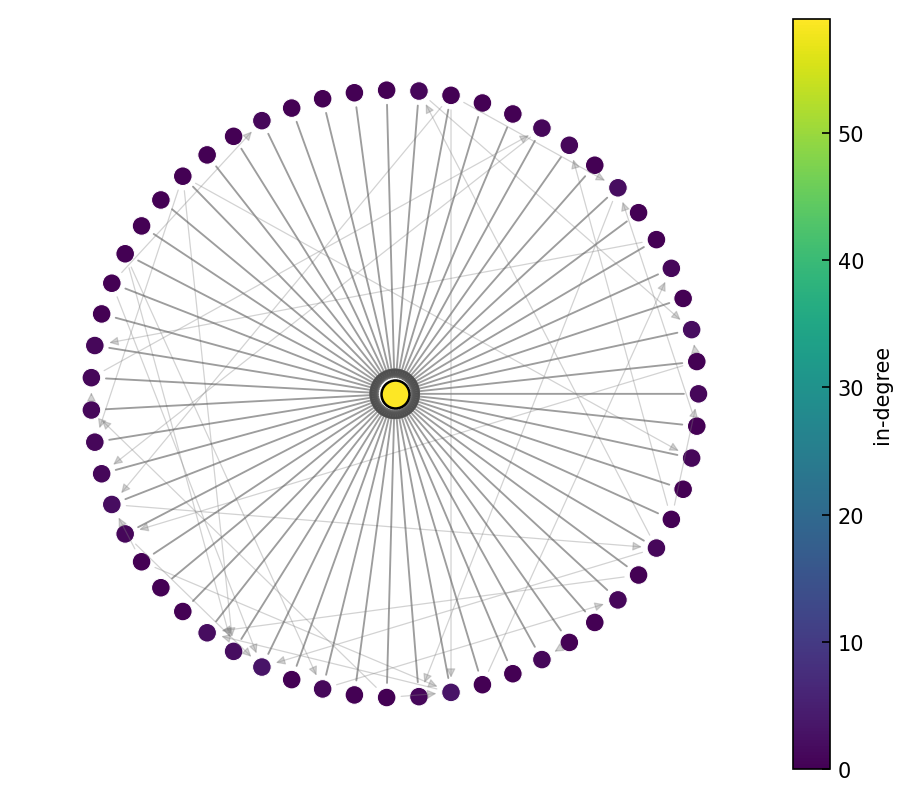

A_N  → classify_ABC → A_N
[Saved] A_N: hubs=[59], leaves=[27, 25, 39, 40, 49, 42, 8, 23, 16, 54, 4, 43, 17, 2, 53, 50, 1, 3, 20, 47, 10, 55, 0, 41, 26, 38, 51, 9, 22, 48, 36, 35, 6, 46, 32, 13, 34, 31, 21, 33, 15, 56, 52, 45, 12, 7, 30, 14, 37, 5, 24, 44, 58, 57, 29, 28, 11, 19, 18] -> plots/A_N
[-37.4535513  -38.44031404  -7.23362894 -39.14394658 -39.14394658
  -7.09345877 -37.46177759 -39.14394658  -7.59545876  -8.12596519
 -38.44022215 -38.40323339  -7.23313894  -7.586712   -38.44847433
 -38.44643834 -37.44352191  -7.23630804 -38.41123663 -38.43325942
 -38.41532419 -37.47135414 -38.43331581  -7.38475143  -7.39722037
  -7.81502883 -38.43300102  -8.12320443  -7.2367971  -38.39157782
  -7.4028841   -8.12590535 -38.42562297  -7.38771289  -7.00117444
 -37.58398753  -7.59493253  -8.12669066 -39.14394658  -7.8207308
 -39.14394658 -38.44777294  -7.2285313   -7.59810311 -38.38860351
  -8.1179283   -7.13351516  -7.39077199 -37.44488059  -6.24010885
 -39.14394658  -8.55375024 -38.42720013  -6.

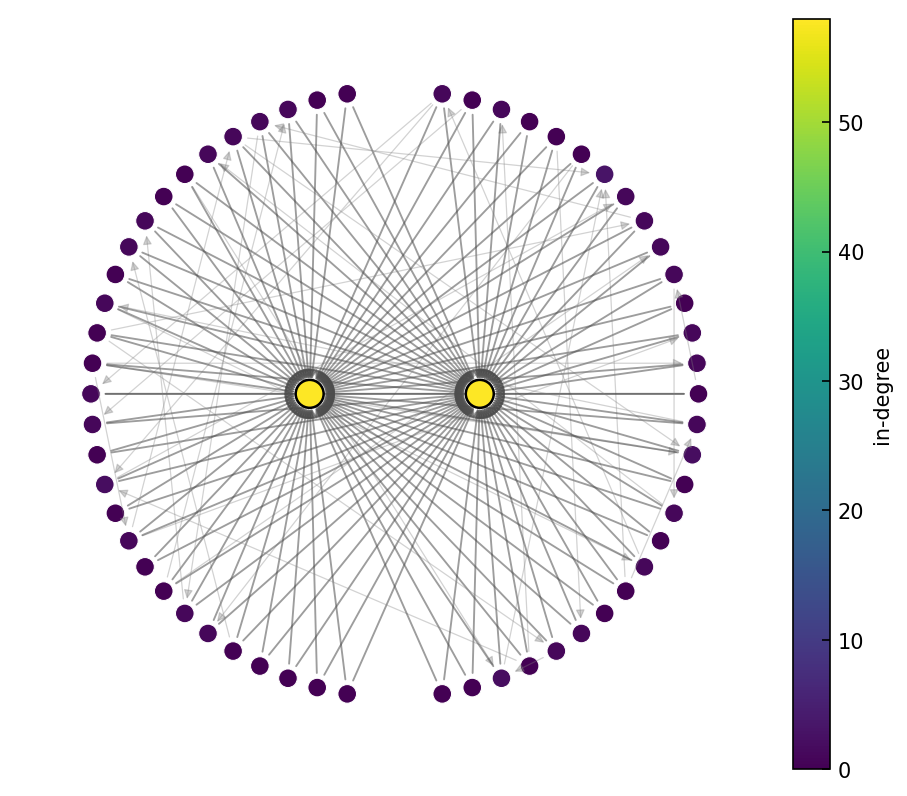

B_N  → classify_ABC → B_N and C_N
[Saved] B_N: hubs=[58, 59], leaves=[27, 15, 50, 32, 19, 33, 39, 28, 57, 1, 37, 43, 8, 5, 22, 42, 9, 49, 24, 26, 21, 56, 2, 25, 29, 23, 11, 46, 0, 35, 20, 3, 4, 48, 41, 53, 47, 10, 14, 16, 51, 31, 17, 7, 13, 44, 52, 40, 34, 54, 18, 12, 36, 6, 55, 30, 38, 45] -> plots/B_N
[ -6.10429358 -38.41016242 -38.39447341 -38.3766029  -38.43904322
 -39.14394658 -39.14394658 -38.42272843 -38.3715875  -37.44291794
 -38.43376904 -38.41676587 -39.14394658  -7.00847879 -39.14394658
 -38.43263847  -7.00342719 -38.41916334 -38.41712843  -6.78729656
 -38.42936446 -39.14394658 -38.38249164  -7.12588359 -37.44163266
  -7.12960097 -38.43401232  -6.69116798 -38.39339945 -38.40016815
  -5.4079361   -6.71123523 -38.38816441 -38.44339168 -37.44175642
 -38.41769839 -38.36895926 -37.46108178 -38.41164808 -37.45403082
 -38.38965478 -37.44843366  -7.1361035  -38.4230874  -38.42286751
 -38.41950454 -37.44431889 -38.41406428  -6.79668533  -6.69791604
 -37.44525263 -38.38545096 -38.4430

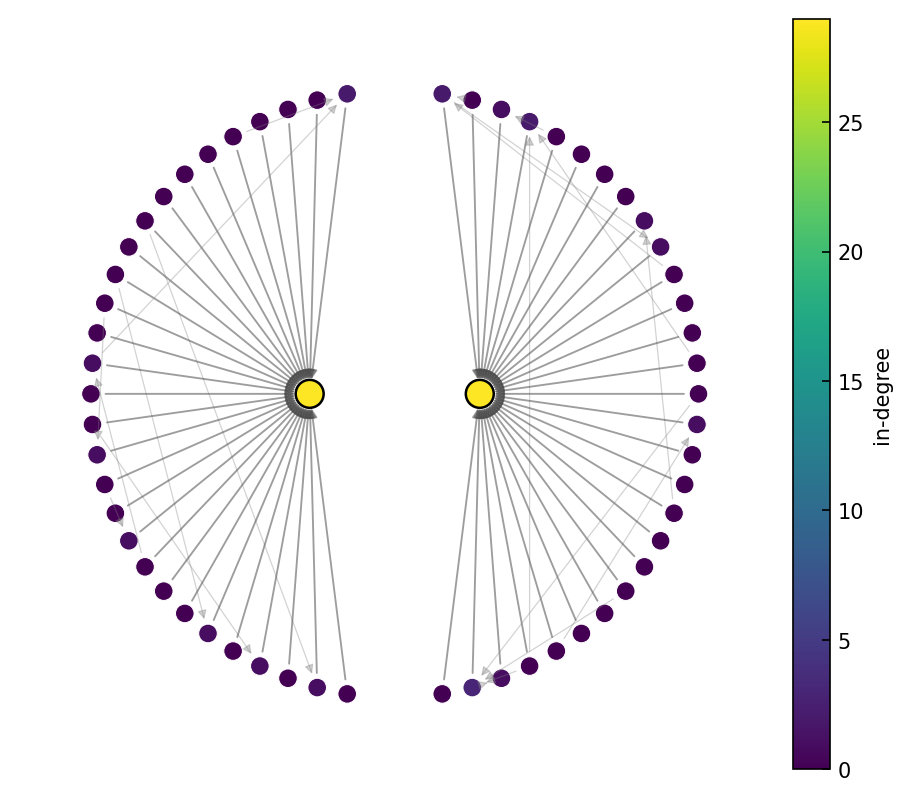

C_N  → classify_ABC → B_N and C_N
[Saved] C_N: hubs=[58, 59], leaves=[8, 30, 25, 11, 20, 48, 46, 55, 1, 7, 38, 2, 50, 39, 3, 0, 47, 34, 52, 12, 41, 54, 10, 17, 5, 43, 4, 35, 13, 36, 23, 16, 26, 9, 21, 44, 32, 18, 14, 53, 29, 15, 6, 56, 49, 27, 28, 31, 42, 57, 24, 40, 51, 22, 33, 37, 45, 19] -> plots/C_N


In [442]:
# VI. ------------------------ Demo -----------------------------------------
NUM_LEAVES_TO_PLOT = 100  # 画多少个边缘节点
TS_POINTS = 50            # 时序图只画最后多少步（少一点更清晰）
LAG_POINTS = 2000          # 相位图用多少对 (t, t+1)（尽可能多）
SAVE_FIGS = True           # True: 保存到文件；False: 直接展示
PLOTS_DIR = "plots"        # 保存目录（仅当 SAVE_FIGS=True 时有效）

p_leaf_edge=0.01
delta_in_max=3
delta_out_max=5
seed=0



#算法1测试
if __name__ == "__main__":
    """
    Demo: run the system under the logistic map and sinusoidal coupling,
    then classify A/B/C for single segments and distinguish B vs C by variance.
    """
    rename_ploy_dir_in_cwd()
    N, T, discard =60, 10000, 600
    alpha = '0.05'

    #local_map = logistic_map_decimal
    local_map = lambda x:Decimal(2)*x%Decimal(1)
    local_map_number = lambda x: 2*x%1
    coupling  = coupling_x2y2
    #coupling  = coupling_sigmoid

    # IV. --- Vectorized utilities, isolated from the Decimal system -------------
    # logistic_vec: elementwise version of f(x) = 4x(1-x) acting on ndarray inputs.
    #logistic_vec = np.vectorize(lambda u: 4.0 * u * (1.0 - u))          # f(x)

    # Ih_vec: elementwise version of I_h(x) = ∫ h(x, y) dm(y); here chosen as -sin(2πx).
    #Ih_vec       = np.vectorize(lambda u: -np.sin(2 * np.pi * u))       # ∫ h dm
    # Demonstrate single-segment classification for A/B/C
    #graph_A(N: int,
    #        p_leaf_edge: float = 0.0,
    #        delta_in_max: int = 0,
    #        seed: int | None = None) -> np.ndarray:
    
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:
        seed+=1
        g=maker(N,p_leaf_edge=p_leaf_edge,delta_in_max=delta_in_max,delta_out_max=delta_out_max,seed=seed)

        
        gs   = GraphSystemDecimal(g, alpha=alpha,
                                  local_map=local_map,
                                  coupling_fn=coupling,
                                  seed=hash(gname) % 2**32)
        traj = gs.run(T, discard)
        graph_type,hubs,S=classify_A_and_BC_local_map_known(traj,local_map_scalar=local_map)
        gs.plot_graph()
        #print(S)
        print(f"{gname}  → classify_ABC → {graph_type}")
        # === 新增：按你指定数量选边缘节点，并画时序图 + 相位图 ===
        arr = _traj_to_float_TxN(traj, N)
        chosen_leaves = plot_hubs_and_leaves(
            arr_TxN=arr,
            hubs=hubs,
            num_leaves=NUM_LEAVES_TO_PLOT,
            gname=gname,
            save_to_file=SAVE_FIGS,
            outdir_base=PLOTS_DIR,
            ts_points=TS_POINTS,
            lag_points=LAG_POINTS,
            seed=(hash(gname) ^ 0xBEEF) & 0xffffffff,
            make_group_lagmaps=True
        )
        if SAVE_FIGS:
            print(f"[Saved] {gname}: hubs={list(np.atleast_1d(hubs))}, leaves={chosen_leaves} -> {os.path.join(PLOTS_DIR, gname)}")
        else:
            print(f"[Shown] {gname}: hubs={list(np.atleast_1d(hubs))}, leaves={chosen_leaves}")
            
        # 1D：鲁棒单调变换 + strip/violin（默认 ranklogit）
        plot_S_distribution_1D(
            S, hubs, gname=gname, save_to_file=SAVE_FIGS, outdir_base=PLOTS_DIR,
            method="ranklogit", jitter=0.09, show_violin=True, seed=123
        )

        # 2D：X=变换后的 S，Y=每节点创新方差（已知 f），默认 log10
        plot_S_vs_variance_2D(
            S, hubs, traj, N, gname=gname, local_map_scalar=local_map_number,
            save_to_file=SAVE_FIGS, outdir_base=PLOTS_DIR,
            x_method="ranklogit", y_log10=True, annotate_hubs=True
        )




    # Compare two sequences to distinguish between B and C
    trajB = GraphSystemDecimal(graph_B(N), alpha=alpha,
                               local_map=local_map,
                               coupling_fn=coupling,
                               seed=1).run(T, discard)
    trajC = GraphSystemDecimal(graph_C(N), alpha=alpha,
                               local_map=local_map,
                               coupling_fn=coupling,
                               seed=2).run(T, discard)
    
    
    
    
    
    
    
    
    

    #res, v_first, v_second = classify_B_vs_C(trajB, trajC)
    #print("\nCompare the two sequences:", res)
    #print(f"  Mean hub variance for the first sequence  = {v_first:.6e}")
    #print(f"  Mean hub variance for the second sequence = {v_second:.6e}")
# ======== New or Replacement Section Ends ===================================

In [373]:
#算法1.2未知local_map的时候的映射

In [387]:
# ----------------------------- Utilities ------------------------------------
from dataclasses import dataclass
def _angle(u: np.ndarray) -> np.ndarray:
    """Map x in [0,1) to 2πx angles."""
    return 2.0 * np.pi * u
def fourier_design(x: np.ndarray, M: int) -> np.ndarray:
    """
    Build a Fourier feature matrix Φ(x) = [cos(0*θ), cos(1*θ),...,cos(M*θ), sin(1*θ),...,sin(M*θ)],
    where θ = 2πx.

    Parameters
    ----------
    x : np.ndarray, shape (T,)
        Inputs in [0,1).
    M : int
        Number of harmonics.

    Returns
    -------
    Φ : np.ndarray, shape (T, 2M+1)
        Columns: [cos0,...,cosM, sin1,...,sinM].
        Note sin0 is identically 0 and omitted; cos0 = 1 is the intercept.
    """
    theta = _angle(x)
    T = x.shape[0]
    # cos block: j = 0..M
    cos_block = np.empty((T, M + 1))
    for j in range(M + 1):
        cos_block[:, j] = np.cos(j * theta)
    # sin block: j = 1..M
    sin_block = np.empty((T, M))
    for j in range(1, M + 1):
        sin_block[:, j - 1] = np.sin(j * theta)
    return np.concatenate([cos_block, sin_block], axis=1)  # (T, 2M+1)

@dataclass
class TrigMap:
    """
    A learned circular map represented by two linear models:
       sin(2π x_next) ≈ Φ(x) @ w_s
       cos(2π x_next) ≈ Φ(x) @ w_c
    """
    M: int
    w_s: np.ndarray  # shape (2M+1,)
    w_c: np.ndarray  # shape (2M+1,)

    def predict_sc(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predict sin and cos of the next angle for a batch of inputs in [0,1).

        Returns
        -------
        (s_pred, c_pred) : two arrays of shape (len(x),)
        """
        Phi = fourier_design(x, self.M)
        s_pred = Phi @ self.w_s
        c_pred = Phi @ self.w_c
        return s_pred, c_pred

    def predict_next(self, x: np.ndarray) -> np.ndarray:
        """
        Predict next x in [0,1) by atan2 on predicted (sin, cos).

        Returns
        -------
        x_next_pred : np.ndarray in [0,1)
        """
        s_pred, c_pred = self.predict_sc(x)
        ang = np.arctan2(s_pred, c_pred)  # (-pi, pi]
        x_next = (ang / (2.0 * np.pi)) % 1.0
        return x_next

    
    

    
    
    
#逐个节点的函数用傅立叶拟合计算gi
def fit_trig_map_for_node(x: np.ndarray, y: np.ndarray, M: int, ridge: float = 0.0) -> TrigMap:
    """
    Fit a TrigMap for one node by linear least squares on Fourier features.

    Targets are circular: we regress sin(2π y) and cos(2π y) separately on Φ(x).

    Parameters
    ----------
    x : (T-1,)
        Inputs (current states).
    y : (T-1,)
        Outputs (next states).
    M : int
        Fourier order.
    ridge : float
        Optional L2-regularization strength (0.0 = ordinary least squares).

    Returns
    -------
    TrigMap
    """
    Phi = fourier_design(x, M)            # (T-1, 2M+1)
    s_tar = np.sin(_angle(y))             # (T-1,)
    c_tar = np.cos(_angle(y))             # (T-1,)

    if ridge > 0.0:
        # Ridge: (Phi^T Phi + λ I) w = Phi^T target
        G = Phi.T @ Phi + ridge * np.eye(Phi.shape[1])
        w_s = np.linalg.solve(G, Phi.T @ s_tar)
        w_c = np.linalg.solve(G, Phi.T @ c_tar)
    else:
        # Ordinary LS via lstsq (robust to mild collinearity)
        w_s, *_ = np.linalg.lstsq(Phi, s_tar, rcond=None)
        w_c, *_ = np.linalg.lstsq(Phi, c_tar, rcond=None)

    return TrigMap(M=M, w_s=w_s, w_c=w_c)


def fit_trig_map_per_node(traj: np.ndarray, M: int, ridge: float = 0.0) -> list[TrigMap]:
    """
    Fit a TrigMap g_i for each node i from its trajectory x_i(t) -> x_i(t+1).

    Parameters
    ----------
    traj : np.ndarray, shape (N, T)
    M : int
        Fourier order.
    ridge : float
        Optional ridge regularization.

    Returns
    -------
    models : list[TrigMap] of length N
    """
    N, T = traj.shape
    models: list[TrigMap] = []
    for i in range(N):
        x = traj[i, :-1]
        y = traj[i,  1:]
        models.append(fit_trig_map_for_node(x, y, M=M, ridge=ridge))
    return models

In [388]:
#映射到圆上降低数值误差的问题
def evaluate_models_on_grid(models: list[TrigMap], G: int = 2048) -> np.ndarray:
    """
    Evaluate each model (sin and cos) on a uniform grid of size G in [0,1).

    Returns
    -------
    V : np.ndarray, shape (N, 2G)
        For node i, row i is [s_pred(grid), c_pred(grid)] concatenated.
        We also L2-normalize per grid point to reduce amplitude effects.
    """
    N = len(models)
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    V = np.zeros((N, 2 * G), dtype=float)
    for i, m in enumerate(models):
        s, c = m.predict_sc(grid)  # each shape (G,)
        # Normalize (optional but helpful): project to unit circle per grid point
        norm = np.sqrt(s * s + c * c) + 1e-12
        s_n = s / norm
        c_n = c / norm
        V[i, :G] = s_n
        V[i, G:] = c_n
    return V


def pearson_distance_matrix(V: np.ndarray) -> np.ndarray:
    """
    Compute pairwise Pearson distances on rows of V:
        d(i,j) = 1 - corr(V_i, V_j).

    Parameters
    ----------
    V : np.ndarray, shape (N, D)

    Returns
    -------
    Dmat : np.ndarray, shape (N, N)
        Symmetric with zeros on the diagonal.
    """
    # Center columns
    X = V - V.mean(axis=0, keepdims=True)      # (N, D)
    # Row-wise norms
    row_norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    Xn = X / row_norm
    # Correlation matrix = Xn Xn^T
    C = Xn @ Xn.T
    # Distance = 1 - corr
    Dmat = 1.0 - C
    np.fill_diagonal(Dmat, 0.0)
    return Dmat


def hub_scores_from_distances(Dmat: np.ndarray) -> np.ndarray:
    """
    Hub score S_i = sum_{j≠i} d(i,j): how dissimilar node i is from the rest.

    Parameters
    ----------
    Dmat : np.ndarray, (N, N)

    Returns
    -------
    S : np.ndarray, (N,)
    """
    return Dmat.sum(axis=1)
# ----------------------- Optional: evaluator for reconstructed f -------------
def evaluate_f_hat(f_hat: TrigMap, x: np.ndarray) -> np.ndarray:
    """
    Evaluate the reconstructed local map \hat f on inputs x in [0,1).

    Returns
    -------
    x_next_pred : np.ndarray in [0,1)
    """
    return f_hat.predict_next(x)

In [389]:
#区分A和BC类在未知f的情况下的代码

In [390]:
def detect_hubs_from_scores(S: np.ndarray, seed: int = 0) -> np.ndarray:
    """
    Detect hubs by a 2-component GMM on the scores S.
    The component with the larger mean corresponds to "hubs".

    Returns
    -------
    hubs_mask : np.ndarray of bool, shape (N,)
    """
    gmm = GaussianMixture(2, random_state=seed).fit(S.reshape(-1, 1))
    labels = gmm.predict(S.reshape(-1, 1))
    means = gmm.means_.flatten()
    hub_label = np.argmax(means)
    hubs_mask = (labels == hub_label)
    return hubs_mask


# ----------------------- Main: A vs (B/C) when f is unknown -----------------
# ------------------------ 主函数：未知 f 的 A vs (B/C) ------------------------
def classify_A_vs_BC_unknown_f(
    traj: np.ndarray,
    M: int = 10,
    grid_size: int = 2048,
    ridge: float = 0.0,
    seed: int = 0,
    return_indices: bool = True,
    return_fhat: bool = True,
) -> str | Tuple[str, np.ndarray] | Dict[str, Any]:
    """
    用“未知 f”的函数不相似度法区分 A 与 (B/C)；可选返回 hub 索引与叶子拟合的 f̂。

    参数
    ----
    traj : np.ndarray (N x T)
        节点轨迹（已去瞬态）。
    M : int
        傅里叶阶数（推荐 8~12 做验证选型）。
    grid_size : int
        比较函数用的网格大小（默认 2048）。
    ridge : float
        Ridge 正则强度（0 表示普通最小二乘）。
    seed : int
        GMM 随机种子。
    return_indices : bool
        若 True，返回 (label, hubs_idx)。
    return_fhat : bool
        若 True，返回包含 f_hat（叶子拟合）的详细字典。

    返回
    ----
    - 若两者均 False：返回 str：'A_N' 或 'B_N and C_N'
    - 若 return_indices=True 且 return_fhat=False：
         返回 (label:str, hubs_idx:np.ndarray)
    - 若 return_fhat=True（无论 return_indices True/False）：
         返回 dict，包含：
            'label'           : 'A_N' / 'B_N and C_N'
            'hubs_idx'        : hub 索引
            'leaves_idx'      : 叶子索引
            'scores'          : S_i
            'distance_matrix' : Pearson 距离矩阵
            'models'          : 每个节点的 TrigMap
            'f_hat'           : 用叶子样本池化拟合得到的 TrigMap
    """
    N, T = traj.shape

    # (1) 逐节点拟合经验映射 g_i
    models = fit_trig_map_per_node(traj, M=M, ridge=ridge)

    # (2) 在统一网格上评估 (3) Pearson 距离矩阵 (4) 分数 S
    V = evaluate_models_on_grid(models, G=grid_size)
    Dmat = pearson_distance_matrix(V)
    S = hub_scores_from_distances(Dmat)

    # (4) 用你给的 GMM 选择 hub
    hubs_mask = detect_hubs_from_scores(S, seed=seed)
    hubs_idx = np.where(hubs_mask)[0]
    leaves_idx = np.where(~hubs_mask)[0]

    # (5) A vs (B/C)
    label = "A_N" if hubs_idx.size == 1 else "B_N and C_N"

    # ---- 返回逻辑（完全按你的开关）----
    if not return_indices and not return_fhat:
        return label

    if return_indices and not return_fhat:
        return label, hubs_idx

    # return_fhat=True（无论 return_indices True/False），返回详细字典
    if leaves_idx.size == 0:
        # 极少数情况下没有“叶子”，退化为非 hub（理论上不该发生，但加一道保险）
        leaves_idx = np.setdiff1d(np.arange(N), hubs_idx)

    # (6) 叶子样本池化拟合 f̂
    x_pool = traj[leaves_idx, :-1].ravel()
    y_pool = traj[leaves_idx,  1:].ravel()
    f_hat = fit_trig_map_for_node(x_pool, y_pool, M=M, ridge=ridge)

    return {
        "label": label,
        "hubs_idx": hubs_idx,
        "leaves_idx": leaves_idx,
        "scores": S,
        "distance_matrix": Dmat,
        "models": models,
        "f_hat": f_hat,
    }

In [391]:
#画图代码

In [392]:
# ========================= Academic plotting style (ticks inward) =====================
import os, json, time, uuid
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

def set_academic_mpl_style():
    """全局 Matplotlib 学术风格：刻度向内、四周刻度、适中字体。"""
    mpl.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "font.size": 10,
        "axes.grid": False,
        "axes.spines.top": True,
        "axes.spines.right": True,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
    })

# ========================= Utilities: naming & I/O (unknown-f) =========================
def _fmt_val_for_name(v):
    """值→文件名友好字符串：浮点保留3有效数字，小数点替换为 'p'。"""
    if isinstance(v, str):
        try:
            v = float(v)
        except Exception:
            return v
    if isinstance(v, float):
        s = f"{v:.3g}"
        return s.replace('.', 'p')
    return str(v)

def build_run_dir_unknown_f(params: dict,
                            base_dir: str = "figs",
                            algo_tag: str = "unknown_f_AvsBC") -> str:
    """
    创建一次运行的“大文件夹”，名称含算法标签、关键超参、时间戳。
    建议 params 含: N,T,discard,M,grid,ridge,seed,alpha,p_leaf_edge,delta_in_max,delta_out_max
    """
    os.makedirs(base_dir, exist_ok=True)
    key_order = ["N","T","discard","M","grid","ridge","seed","alpha",
                 "p_leaf_edge","delta_in_max","delta_out_max"]
    alias = {"p_leaf_edge":"ple", "delta_in_max":"din", "delta_out_max":"dout"}
    parts = []
    for k in key_order:
        if k in params and params[k] is not None:
            kk = alias.get(k, k)
            parts.append(f"{kk}{_fmt_val_for_name(params[k])}")
    stamp = time.strftime("%Y%m%d-%H%M%S")
    dirname = f"{algo_tag}_" + "_".join(parts) + f"_{stamp}"
    outdir = os.path.join(base_dir, dirname)
    if os.path.exists(outdir):
        outdir += "_" + uuid.uuid4().hex[:6]
    os.makedirs(outdir, exist_ok=False)
    # 保存元数据
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump({"algo": algo_tag, "timestamp": stamp, "params": params},
                  f, ensure_ascii=False, indent=2)
    return outdir

def ensure_subdir(parent: str, name: str) -> str:
    path = os.path.join(parent, name)
    os.makedirs(path, exist_ok=True)
    return path

# ========================= Classical MDS (from a distance matrix) ======================
def classical_mds_from_distance_unknown_f(D: np.ndarray, k: int = 2):
    """经典 MDS：由距离矩阵 D ∈ R^{N×N} 得到 2D 嵌入。"""
    N = D.shape[0]
    J = np.eye(N) - np.ones((N, N))/N
    B = -0.5 * J @ (D**2) @ J
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    pos = np.maximum(eigvals[:k], 0.0)
    Y = eigvecs[:, :k] @ np.diag(np.sqrt(pos + 1e-15))
    return Y, eigvals

# ========================= Plotters (unknown-f; 支持标注/刻度向里) =====================
def _apply_ticks_in(ax):
    ax.tick_params(direction="in", top=True, right=True, length=4, width=0.8)

def plot_hub_scores_unknown_f(S: np.ndarray,
                              hubs_idx: np.ndarray,
                              node_labels: np.ndarray | None = None,
                              annotate: str = "hubs",     # "hubs"|"all"|"none"
                              title: str = "",
                              savepath: str | None = None,
                              fontsize: int = 7):
    """
    柱状图（按 S 从大到小排序）。可选标注：只标 hub/标全部/不标注。
    """
    set_academic_mpl_style()
    N = S.shape[0]
    if node_labels is None:
        node_labels = np.arange(N)

    idx_sorted = np.argsort(S)[::-1]
    S_sorted = S[idx_sorted]

    fig, ax = plt.subplots(figsize=(7.6, 3.8))
    bars = ax.bar(np.arange(N), S_sorted, width=0.85)
    hub_set = set(hubs_idx.tolist())

    # 高亮 hub
    for rank, i in enumerate(idx_sorted):
        if i in hub_set:
            bars[rank].set_edgecolor("k")
            bars[rank].set_linewidth(1.5)
            bars[rank].set_hatch("//")

    # 标注
    for rank, i in enumerate(idx_sorted):
        if annotate == "none":
            break
        if annotate == "hubs" and (i not in hub_set):
            continue
        txt = str(node_labels[i])
        ax.text(rank, S_sorted[rank], txt,
                ha="center", va="bottom", fontsize=fontsize, clip_on=True)

    ax.set_xlabel("Nodes (sorted by S)")
    ax.set_ylabel("Hub score  S = Σ (1 − Pearson corr)")
    ax.set_title(title or "Hub scores (A: one tall peak; B/C: two peaks)")
    _apply_ticks_in(ax)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        plt.close(fig)

def plot_distance_heatmap_unknown_f(D: np.ndarray,
                                    S: np.ndarray,
                                    hubs_idx: np.ndarray,
                                    title: str = "",
                                    savepath: str | None = None):
    """皮尔逊距离热图（按 S 升序排序，叶子在前、hub 在后）。"""
    set_academic_mpl_style()
    order = np.argsort(S)
    D_ord = D[order][:, order]
    fig, ax = plt.subplots(figsize=(5.8, 5.0))
    im = ax.imshow(D_ord, interpolation="nearest", cmap="viridis")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Pearson distance")
    ax.set_title(title or "Pearson distance matrix (nodes sorted by S)")
    ax.set_xlabel("Nodes (sorted)")
    ax.set_ylabel("Nodes (sorted)")
    _apply_ticks_in(ax)
    # 标出 hub 的行列
    hubs_in_order = np.isin(order, hubs_idx)
    hub_positions = np.where(hubs_in_order)[0]
    for hp in hub_positions:
        ax.axhline(hp - 0.5, color="w", lw=0.6, alpha=0.7)
        ax.axvline(hp - 0.5, color="w", lw=0.6, alpha=0.7)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        plt.close(fig)

def _hub_label_offsets(Yh: np.ndarray):
    """
    给 1~2 个 hub 生成不重叠的文本偏移（单位：points）。
    """
    if Yh.shape[0] == 1:
        return [(0, 6)]
    # 两个 hub：根据相对方向选左右或上下错位
    v = Yh[1] - Yh[0]
    if abs(v[0]) >= abs(v[1]):
        return [(-6, 6), (6, -8)]  # 左上 / 右下
    else:
        return [(6, 6), (-6, -8)]  # 右上 / 左下

def plot_mds_scatter_unknown_f(D: np.ndarray,
                               hubs_idx: np.ndarray,
                               node_labels: np.ndarray | None = None,
                               title: str = "",
                               savepath: str | None = None,
                               hub_fontsize: int = 8):
    """
    2D MDS 嵌入：叶子为实心点，hub 为空心加粗圆圈；只标注 hub 的节点序号（自动错位）。
    """
    set_academic_mpl_style()
    Y, _ = classical_mds_from_distance_unknown_f(D, k=2)
    N = D.shape[0]
    hubs_mask = np.zeros(N, dtype=bool); hubs_mask[hubs_idx] = True
    if node_labels is None:
        node_labels = np.arange(N)

    fig, ax = plt.subplots(figsize=(5.6, 4.8))
    # 叶子
    ax.scatter(Y[~hubs_mask, 0], Y[~hubs_mask, 1],
               s=30, alpha=0.9, edgecolor="none", label="leaves")
    # hubs
    ax.scatter(Y[hubs_mask, 0], Y[hubs_mask, 1],
               s=80, alpha=1.0, facecolor="none", edgecolor="black",
               marker="o", linewidths=1.5, label="hubs")

    # 只标注 hubs
    Yh = Y[hubs_mask]
    idx_h = np.where(hubs_mask)[0]
    offs = _hub_label_offsets(Yh)
    trans = mpl.transforms.ScaledTranslation(1/72., 1/72., fig.dpi_scale_trans)
    for k, i in enumerate(idx_h):
        dx_pt, dy_pt = offs[k % len(offs)]
        # 以 points 为单位偏移（避免重叠）
        text = ax.text(Y[i, 0], Y[i, 1], str(node_labels[i]),
                       fontsize=hub_fontsize, ha="center", va="center")
        text.set_transform(text.get_transform() + mpl.transforms.ScaledTranslation(dx_pt/72., dy_pt/72., fig.dpi_scale_trans))

    ax.set_title(title or "2D embedding (classical MDS from Pearson distances)")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(frameon=False, loc="best")
    _apply_ticks_in(ax)
    fig.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        plt.close(fig)

def save_all_plots_unknown_f(result: dict,
                             outdir: str,
                             node_labels: np.ndarray | None = None,
                             title_suffix: str = "",
                             annotate_bar: str = "hubs"):
    """
    保存三张图（PNG+PDF）以及 scores/距离矩阵/hubs 下标到 outdir。
    annotate_bar: "hubs" | "all" | "none"
    """
    os.makedirs(outdir, exist_ok=True)
    label = result["label"]
    S     = result["scores"]
    Dmat  = result["distance_matrix"]
    hubs  = result["hubs_idx"]

    # 保存数组（复现用）
    np.save(os.path.join(outdir, "scores.npy"), S)
    np.save(os.path.join(outdir, "distance_matrix.npy"), Dmat)
    np.save(os.path.join(outdir, "hubs_idx.npy"), hubs)

    t1 = f"{label} · Hub scores" + (f" · {title_suffix}" if title_suffix else "")
    t2 = f"{label} · Pearson distance matrix" + (f" · {title_suffix}" if title_suffix else "")
    t3 = f"{label} · MDS 2D embedding" + (f" · {title_suffix}" if title_suffix else "")

    # PNG
    plot_hub_scores_unknown_f(S, hubs, node_labels=node_labels, annotate=annotate_bar,
                              title=t1, savepath=os.path.join(outdir, "01_scores_bar.png"))
    plot_distance_heatmap_unknown_f(Dmat, S, hubs, title=t2,
                                    savepath=os.path.join(outdir, "02_distance_heatmap.png"))
    plot_mds_scatter_unknown_f(Dmat, hubs, node_labels=node_labels, title=t3,
                               savepath=os.path.join(outdir, "03_mds_scatter.png"))

    # PDF（论文排版）
    plot_hub_scores_unknown_f(S, hubs, node_labels=node_labels, annotate=annotate_bar,
                              title=t1, savepath=os.path.join(outdir, "01_scores_bar.pdf"))
    plot_distance_heatmap_unknown_f(Dmat, S, hubs, title=t2,
                                    savepath=os.path.join(outdir, "02_distance_heatmap.pdf"))
    plot_mds_scatter_unknown_f(Dmat, hubs, node_labels=node_labels, title=t3,
                               savepath=os.path.join(outdir, "03_mds_scatter.pdf"))


[RUN] output dir: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din3_dout5_20250911-002320


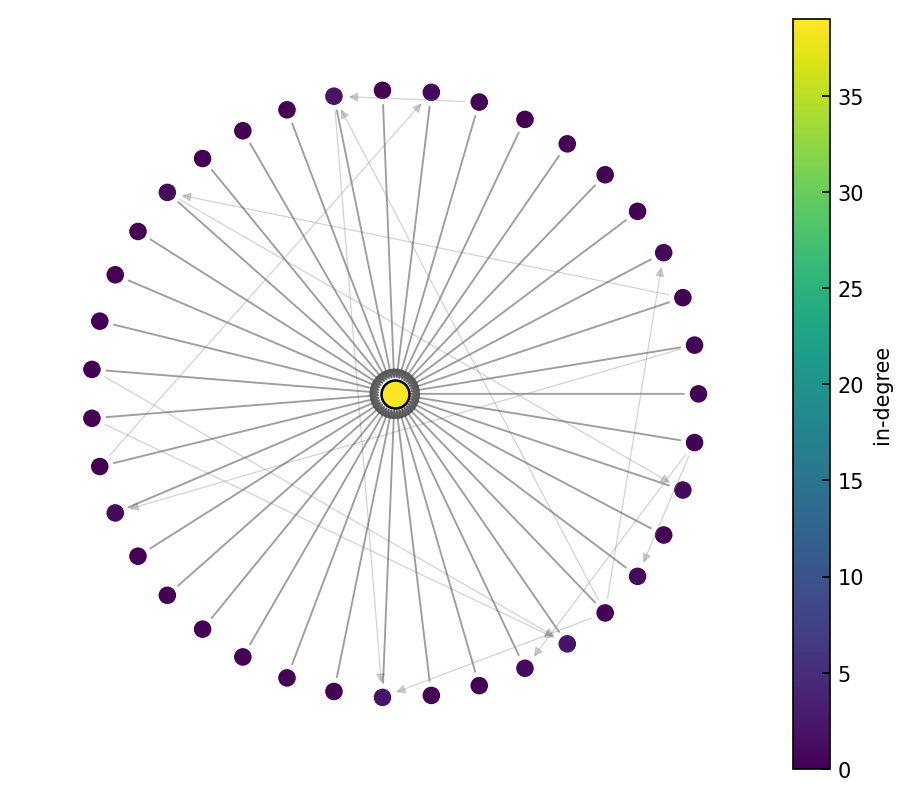

[A_N] classified as: B_N and C_N  | hubs: [11 29 33 39]


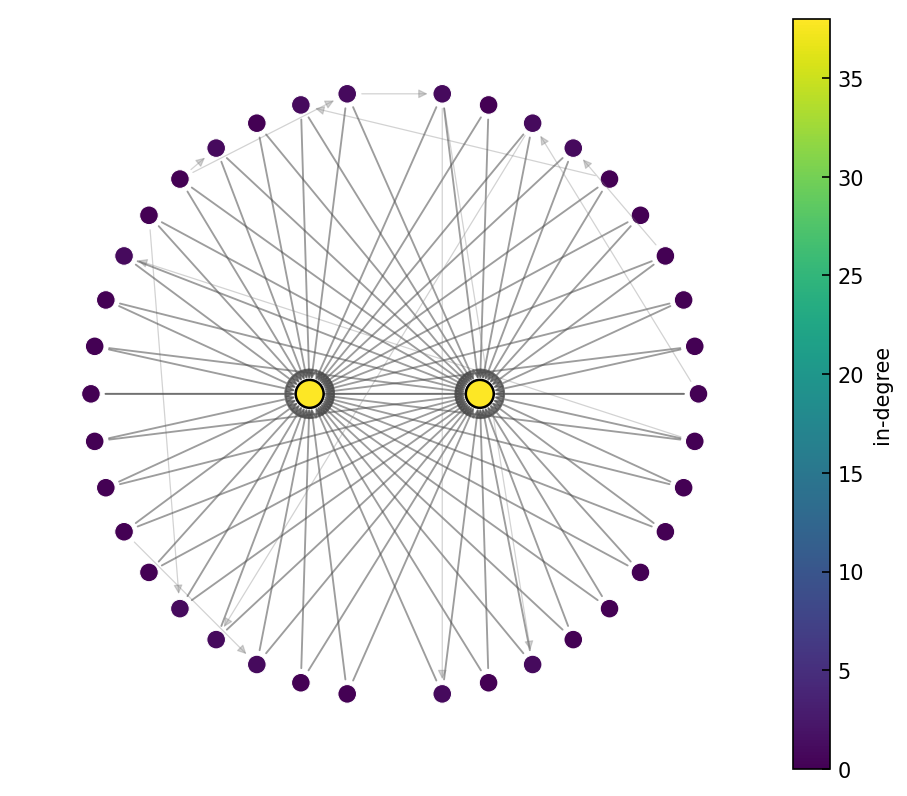

[B_N] classified as: B_N and C_N  | hubs: [38 39]


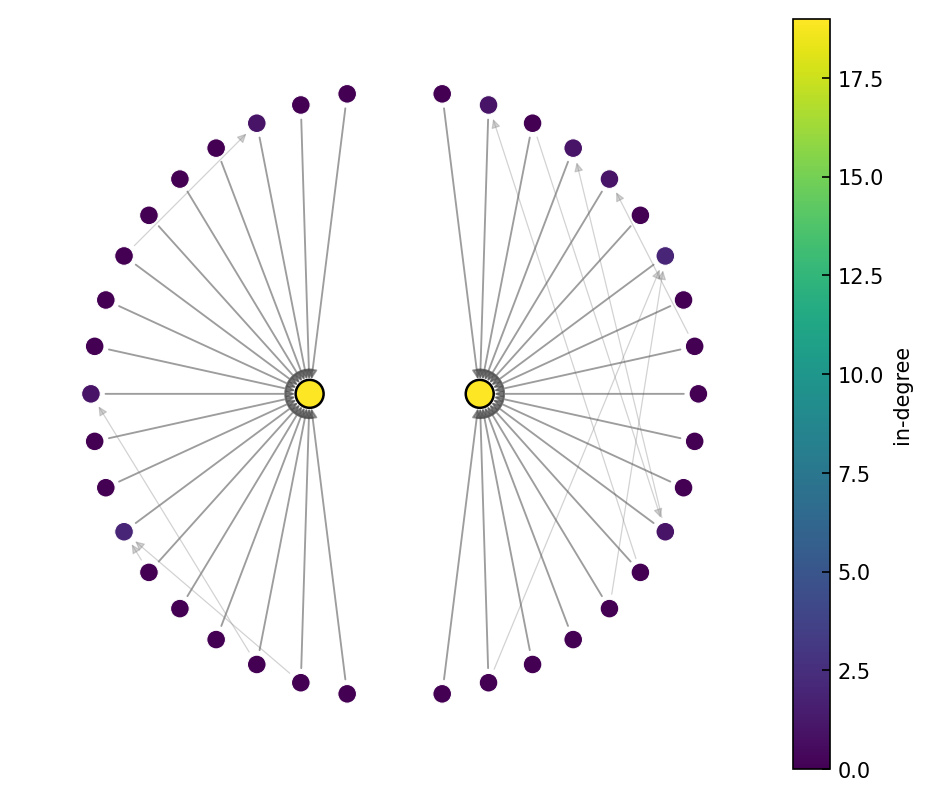

[C_N] classified as: B_N and C_N  | hubs: [12 31 38 39]
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din3_dout5_20250911-002320


In [424]:
if __name__ == "__main__":
    # ===== 你的实验超参（按需要修改）=====
    p_leaf_edge   = 0.01
    delta_in_max  = 3
    delta_out_max = 5
    seed_graph0   = 1            # 生成图/仿真的随机种子起点
    N, T, discard = 40, 6000, 600
    alpha         = "0.05"       # 生成轨迹用；分类器对 f 未知
    M             = 10
    grid_size     = 2048
    ridge         = 0.0
    seed_clf      = 0            # 分类器/GMM 的随机种子

    # ---- (0) 一次运行的大文件夹（含时间戳+超参）----
    params = {
        "N": N, "T": T, "discard": discard,
        "M": M, "grid": grid_size, "ridge": ridge,
        "seed": seed_clf, "alpha": alpha,
        "p_leaf_edge": p_leaf_edge, "delta_in_max": delta_in_max, "delta_out_max": delta_out_max,
    }
    run_dir = build_run_dir_unknown_f(params, base_dir="figs", algo_tag="unknown_f_AvsBC")
    print(f"[RUN] output dir: {run_dir}")

    # ---- (1) 逐个段（A/B/C）生成 → 分类 → 各自子文件夹出图 ----
    seed_graph = seed_graph0
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:

        # 1) 生成图（兼容 maker 有/无关键字两种接口）
        try:
            A = maker(N, p_leaf_edge=p_leaf_edge,
                         delta_in_max=delta_in_max,
                         delta_out_max=delta_out_max,
                         seed=seed_graph)
        except TypeError:
            A = maker(N)  # 回退老接口
        
        local_map = lambda x:Decimal(2)*x%Decimal(1)
        #local_map_number = lambda x: 2*x%1
        coupling  = coupling_x2y2
        
        gs = GraphSystemDecimal(A, alpha=alpha,local_map=local_map,coupling_fn=coupling, seed=seed_graph)
        seed_graph += 1

        # 2) 子文件夹：A_N / B_N / C_N
        subdir = ensure_subdir(run_dir, gname)

        # 3) 可选保存图结构（若有 gs.plot_graph）
        if hasattr(gs, "plot_graph"):
            try:
                gs.plot_graph(savepath=os.path.join(subdir, "graph.png"))
            except TypeError:
                try:
                    gs.plot_graph()
                    plt.savefig(os.path.join(subdir, "graph.png"), dpi=300, bbox_inches="tight")
                    plt.close()
                except Exception:
                    pass

        # 4) 仿真
        traj = gs.run(T, discard)

        # 5) 未知 f 的 A vs (B/C) 分类（返回 scores / distance_matrix）
        out = classify_A_vs_BC_unknown_f(
            traj=traj,
            M=M,
            grid_size=grid_size,
            ridge=ridge,
            seed=seed_clf,
            return_indices=True,
            return_fhat=True,
        )
        print(f"[{gname}] classified as: {out['label']}  | hubs: {out['hubs_idx']}")

        # 6) 保存三张图 + 数组（柱状图默认只标注 hub 序号；如需全部标注，annotate_bar='all'）
        node_labels = np.arange(traj.shape[0])  # 节点编号
        save_all_plots_unknown_f(
            result=out,
            outdir=subdir,
            node_labels=node_labels,
            title_suffix=f"{gname}, M={M}, grid={grid_size}, ridge={ridge}",
            annotate_bar="hubs"
        )

        # 7) 可选：保存该段的 \hat f 在网格上的预测（便于附录/验证）
        try:
            grid = np.linspace(0.0, 1.0, 64, endpoint=False)
            f_grid = evaluate_f_hat(out["f_hat"], grid)
            np.save(os.path.join(subdir, "f_hat_grid_x.npy"), grid)
            np.save(os.path.join(subdir, "f_hat_grid_fx.npy"), f_grid)
        except Exception:
            pass

    print(f"[OK] All figures & data saved to: {run_dir}")


In [ ]:
#用相关性估计

In [408]:
# >>> NEW: 环上差分（把差值映射到 [-0.5, 0.5) 以避免 0/1 跳变）
def moddiff(z: np.ndarray) -> np.ndarray:
    return ((z + 0.5) % 1.0) - 0.5

# >>> NEW: 默认的 m_h_vec —— 近似论文里的 v(y)
def m_h_vec_default(x: np.ndarray) -> np.ndarray:
    # v(y) = sin(2π y)，与你的默认扩散耦合项一致
    return np.sin(2.0 * np.pi * x)

# >>> NEW: 在两个 hub 上估计 beta，并计算噪声残差 xi_h(t)
def _compute_hub_residuals(traj: np.ndarray,
                           f_hat: TrigMap,
                           hubs_idx: np.ndarray,
                           m_h_vec: Callable[[np.ndarray], np.ndarray]) -> dict[int, np.ndarray]:
    xi: dict[int, np.ndarray] = {}
    for h in hubs_idx[:2]:
        xh = traj[h, :-1]            # 当前
        yh = traj[h,  1:]            # 下一步
        base = f_hat.predict_next(xh)          # \hat f(xh)
        r = moddiff(yh - base)                  # 剩余 = y - \hat f(x)
        s = m_h_vec(xh)                          # v(x)
        denom = float(np.dot(s, s) + 1e-12)
        beta = float(np.dot(r, s) / denom)      # 最小二乘 \hat beta
        xi[h] = moddiff(yh - base - beta * s)   # \xi_h(t)
    return xi

# >>> NEW: 用噪声相关性区分 B 与 C
def classify_B_vs_C_by_correlation(traj: np.ndarray,
                                   f_hat: TrigMap,
                                   hubs_idx: np.ndarray,
                                   tau: float = 0.4,
                                   m_h_vec: Callable[[np.ndarray], np.ndarray] = m_h_vec_default
                                   ) -> dict[str, object]:
    if hubs_idx.size < 2:
        return {"label_BC": None, "rho_hubs": None}

    xi = _compute_hub_residuals(traj, f_hat, hubs_idx, m_h_vec)
    h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
    v1 = xi[h1] - xi[h1].mean()
    v2 = xi[h2] - xi[h2].mean()
    denom = float(np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-12)
    rho = float(np.dot(v1, v2) / denom)
    label_BC = "B_N" if rho >= tau else "C_N"
    return {"label_BC": label_BC, "rho_hubs": rho, "hubs_idx": hubs_idx}
# >>> NEW: 完整流水线：先 A vs (B/C)，若是 (B/C) 再做相关性分 B/C
def classify_ABC_pipeline(traj: np.ndarray,
                          M: int = 10,
                          grid_size: int = 2048,
                          ridge: float = 0.0,
                          seed: int = 0,
                          tau: float = 0.4,
                          m_h_vec: Callable[[np.ndarray], np.ndarray] = m_h_vec_default
                          ) -> dict[str, object]:
    # 第一步：用你已有的方法做 A vs (B/C) 并重建 \hat f
    out = classify_A_vs_BC_unknown_f(
        traj=traj, M=M, grid_size=grid_size, ridge=ridge,
        seed=seed, return_indices=True, return_fhat=True
    )

    label_A_BC = out["label"]
    hubs_idx = out["hubs_idx"]
    f_hat: TrigMap = out["f_hat"]

    # 若为 A，直接返回
    if label_A_BC == "A_N" or hubs_idx.size < 2:
        out["label_final"] = "A_N"
        out["label_BC"] = None
        out["rho_hubs"] = None
        return out

    # 否则做相关性法区分 B/C
    bc = classify_B_vs_C_by_correlation(
        traj=traj, f_hat=f_hat, hubs_idx=hubs_idx, tau=tau, m_h_vec=m_h_vec
    )
    out.update(bc)
    out["label_final"] = out["label_BC"]  # 最终是 B_N 或 C_N
    return out


In [421]:
# ====================== Correlation Visualization (NEW) ======================

import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any
# ===== 新增：把对象递归转换成 JSON 可序列化的 Python 基元 =====
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):
        return {k: _to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.bool_,)):
        return bool(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj  # 其他原生类型保持不变


# ---------------------- 1) 计算所有节点的涨落 ξ_i(t) -------------------------
def compute_xi_all_nodes(traj: np.ndarray,
                         f_hat: TrigMap,
                         hubs_idx: np.ndarray,
                         m_h_vec: Callable[[np.ndarray], np.ndarray] = m_h_vec_default
                         ) -> np.ndarray:
    """
    对每个节点 i 计算 ξ_i(t)：
      - hub: ξ = y - f̂(x) - β̂ v(x), 其中 β̂ 最小二乘拟合
      - leaf: ξ = y - f̂(x)（低度近似忽略 β v）
    返回 Xi, 形状 (N, T-1)
    """
    N, T = traj.shape
    Xi = np.zeros((N, T - 1), dtype=float)
    hubs = set(map(int, np.atleast_1d(hubs_idx).tolist()))
    for i in range(N):
        x = traj[i, :-1]
        y = traj[i,  1:]
        base = f_hat.predict_next(x)
        if i in hubs:
            r = moddiff(y - base)
            s = m_h_vec(x)
            denom = float(np.dot(s, s) + 1e-12)
            beta = float(np.dot(r, s) / denom)
            Xi[i] = moddiff(y - base - beta * s)
        else:
            Xi[i] = moddiff(y - base)
    return Xi

# ---------------------- 2) 行相关矩阵 Corr(ξ_i, ξ_j) ------------------------
def corr_matrix_rows(X: np.ndarray) -> np.ndarray:
    """
    输入 X (N, T)，计算每两行的皮尔逊相关矩阵 C (N, N)。
    """
    Xc = X - X.mean(axis=1, keepdims=True)
    std = np.linalg.norm(Xc, axis=1, keepdims=True) + 1e-12
    Xn = Xc / std
    C = Xn @ Xn.T
    np.fill_diagonal(C, 1.0)
    return C

# ---------------------- 3) 谱排序用于“聚类化”展示 ---------------------------
def spectral_order(C: np.ndarray) -> np.ndarray:
    """
    用距离 D=1-C 的拉普拉斯矩阵的 Fiedler 向量做序列化排序（无需 SciPy）。
    """
    N = C.shape[0]
    if N <= 2:
        return np.arange(N)
    D = np.maximum(0.0, 1.0 - C)
    L = np.diag(D.sum(axis=1)) - D
    w, V = np.linalg.eigh(L)
    # 取第二小特征向量（Fiedler）
    idx = np.argsort(w)
    fiedler = V[:, idx[1]]
    order = np.argsort(fiedler)
    return order

# ---------------------- 4) 绘图：相关性热图（可谱排序） -----------------------
def plot_correlation_heatmap(C: np.ndarray,
                             hubs_idx: np.ndarray,
                             outpath: str,
                             title: str = "",
                             order: np.ndarray | None = None) -> None:
    N = C.shape[0]
    if order is None:
        order = np.arange(N)
    C_ord = C[np.ix_(order, order)]
    hubs_idx = np.atleast_1d(hubs_idx).astype(int)
    # hubs 在重排后的坐标
    hub_pos = [int(np.where(order == h)[0][0]) for h in hubs_idx if h < N]

    fig, ax = plt.subplots(figsize=(6.4, 5.2))
    im = ax.imshow(C_ord, origin="lower", aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("node (reordered)" if title.endswith("spectral") else "node")
    ax.set_ylabel("node")
    fig.colorbar(im, ax=ax, shrink=0.82)

    # 高亮 hub：画十字虚线并标注
    for k, pos in enumerate(hub_pos):
        ax.axhline(pos, linestyle="--", linewidth=1.0, color="white")
        ax.axvline(pos, linestyle="--", linewidth=1.0, color="white")
        ax.text(-0.6, pos, f"H{k}", va="center", ha="right", fontsize=8, color="white")
        ax.text(pos, -0.8, f"H{k}", va="top", ha="center", fontsize=8, color="white", rotation=90)

    plt.tight_layout()
    fig.savefig(outpath, dpi=240, bbox_inches="tight")
    plt.close(fig)

# ---------------------- 5) 绘图：对 hub 的相关性柱形图 ------------------------
def plot_corr_bars_to_hubs(C: np.ndarray,
                           hubs_idx: np.ndarray,
                           outpath: str) -> None:
    N = C.shape[0]
    hubs_idx = np.atleast_1d(hubs_idx).astype(int)
    x = np.arange(N)

    fig, ax = plt.subplots(figsize=(max(8, N * 0.18), 4.0))

    if len(hubs_idx) >= 2:
        h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
        ax.bar(x - 0.2, C[:, h1], width=0.4, label=f"corr to hub {h1}", alpha=0.9)
        ax.bar(x + 0.2, C[:, h2], width=0.4, label=f"corr to hub {h2}", alpha=0.9)
        # 显示 hub-hub 的 rho
        ax.text(0.01, 0.98, f"corr(hub {h1}, hub {h2}) = {C[h1, h2]:.4f}",
                transform=ax.transAxes, ha="left", va="top")
    elif len(hubs_idx) == 1:
        h = int(hubs_idx[0])
        ax.bar(x, C[:, h], width=0.6, label=f"corr to hub {h}", alpha=0.9)

    # 高亮 hub 的竖线与标签
    for k, h in enumerate(hubs_idx[:2]):
        ax.axvline(h, linestyle="--", linewidth=1.0)
        ax.text(h, 1.03, f"H{k}", ha="center", va="bottom")

    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel("node index")
    ax.set_ylabel("correlation")
    ax.legend()
    plt.tight_layout()
    fig.savefig(outpath, dpi=240, bbox_inches="tight")
    plt.close(fig)

# ---------------------- 6) 主入口：保存“BC相关性”图 --------------------------
def save_bc_correlation_figures(traj: np.ndarray,
                                result: Dict[str, Any],
                                outdir_graph: str,
                                params: Dict[str, Any],
                                tau: float = 0.4,
                                m_h_vec: Callable[[np.ndarray], np.ndarray] = m_h_vec_default
                                ) -> str:
    """
    在子目录 outdir_graph 下新建：BC相关性_超参_时间戳，保存相关性图与数据。
    返回该新目录路径。
    """
    hubs_idx = result.get("hubs_idx", np.array([], dtype=int))
    f_hat: TrigMap = result["f_hat"]

    # 1) 计算全部节点的 ξ 与相关矩阵
    Xi = compute_xi_all_nodes(traj, f_hat, hubs_idx, m_h_vec=m_h_vec)
    C = corr_matrix_rows(Xi)

    # 2) 目录名（含超参+时间戳）
    ts = time.strftime("%Y%m%d_%H%M%S")
    M = int(params.get("M", 10))
    grid = int(params.get("grid", params.get("grid_size", 2048)))
    ridge = float(params.get("ridge", 0.0))
    sub = os.path.join(outdir_graph, f"BCCorrection_M{M}_G{grid}_ridge{ridge}_tau{tau}_{ts}")
    os.makedirs(sub, exist_ok=True)

    # 3) 保存关键数据
    np.save(os.path.join(sub, "xi_all.npy"), Xi)
    np.save(os.path.join(sub, "corr_matrix.npy"), C)
    meta = {
        "label_A_vs_BC": result.get("label"),
        "label_final": result.get("label_final", None),
        "label_BC": result.get("label_BC", None),
        "rho_hubs": result.get("rho_hubs", None),
        "hubs_idx": result.get("hubs_idx", []),
        "tau": tau,
        "params": params
    }
    with open(os.path.join(sub, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)  # ★ 关键修改

    # 4) 热图（原始顺序 + 谱排序）
    plot_correlation_heatmap(C, hubs_idx, outpath=os.path.join(sub, "corr_heatmap_raw.png"),
                             title="Corr(ξ_i, ξ_j) heatmap (raw order)")
    order = spectral_order(C)
    plot_correlation_heatmap(C, hubs_idx, outpath=os.path.join(sub, "corr_heatmap_spectral.png"),
                             title="Corr(ξ_i, ξ_j) heatmap (spectral order)", order=order)

    # 5) 与 hub 的相关性柱形图（便于 B/C 直观看差异）
    plot_corr_bars_to_hubs(C, hubs_idx, outpath=os.path.join(sub, "corr_to_hubs_bar.png"))

    # 6) 若有两个 hub，记录决策用的 corr 值
    if len(hubs_idx) >= 2:
        h1, h2 = int(hubs_idx[0]), int(hubs_idx[1])
        with open(os.path.join(sub, "BC_decision.txt"), "w") as f:
            f.write(f"label_BC={result.get('label_BC')}, rho={C[h1, h2]:.6f}, tau={tau}\n")

    return sub
# ==================== End of Correlation Visualization (NEW) ==================


[RUN] output dir: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459


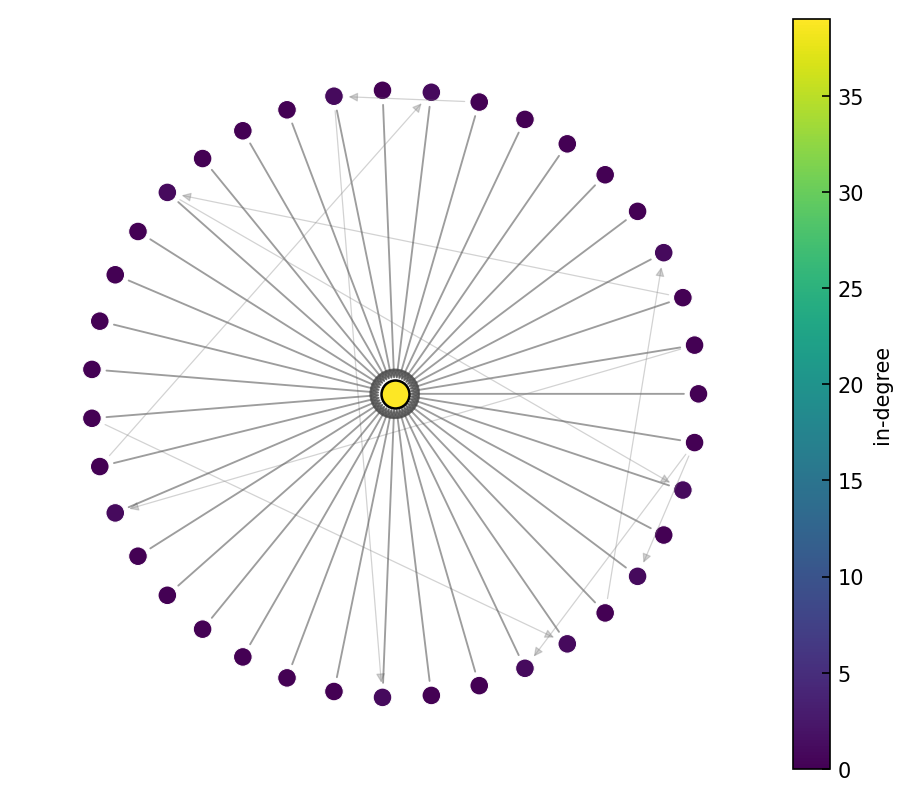

[A_N] classified as: A_N (A/B/C) | hubs: [39] | rho=None
[A_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459/A_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250910_225519
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459


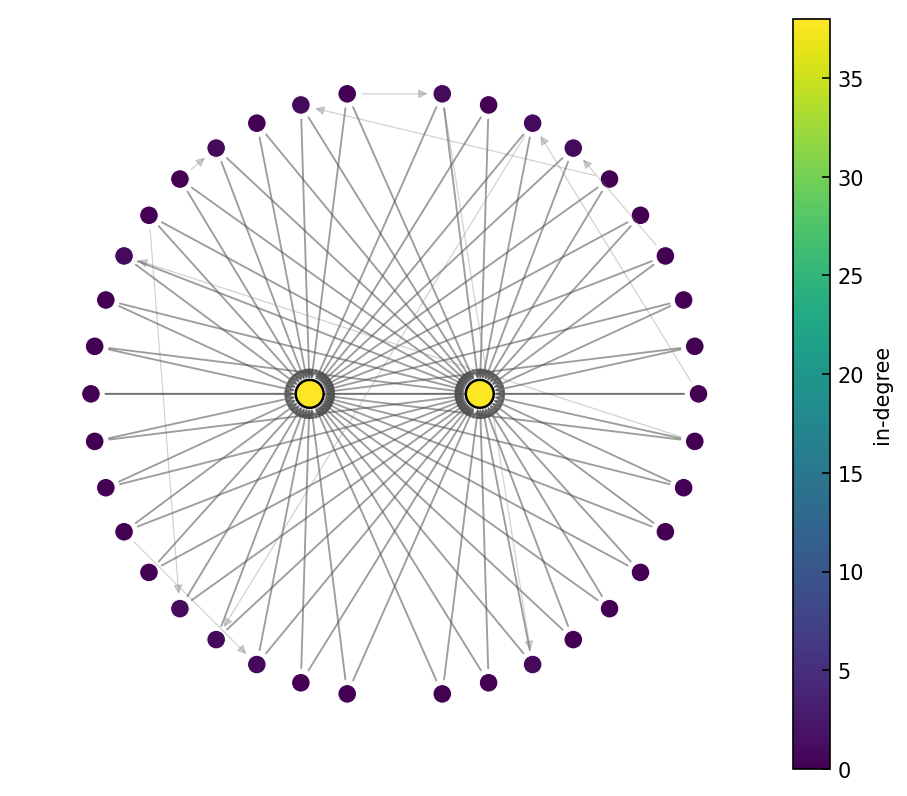

[B_N] classified as: C_N (A/B/C) | hubs: [38 39] | rho=0.049213175294050934
[B_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459/B_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250910_225550
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459


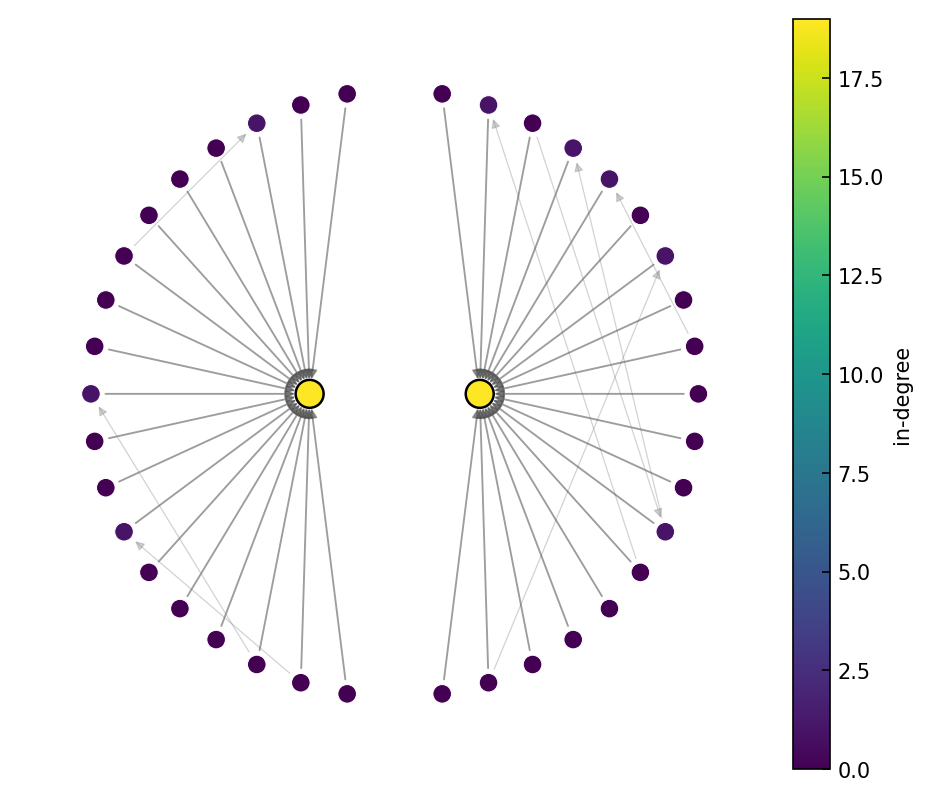

[C_N] classified as: C_N (A/B/C) | hubs: [38 39] | rho=-0.014441640043483082
[C_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459/C_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250910_225610
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0p01_din1_dout3_20250910-225459


In [423]:
if __name__ == "__main__":
    # ===== 你的实验超参（按需要修改）=====
    p_leaf_edge   = 0.01
    delta_in_max  = 1
    delta_out_max = 3
    seed_graph0   = 1            # 生成图/仿真的随机种子起点
    N, T, discard = 40, 6000, 600
    alpha         = "0.05"       # 生成轨迹用；分类器对 f 未知
    M             = 10
    grid_size     = 2048
    ridge         = 0.0
    seed_clf      = 0            # 分类器/GMM 的随机种子

    # ---- (0) 一次运行的大文件夹（含时间戳+超参）----
    params = {
        "N": N, "T": T, "discard": discard,
        "M": M, "grid": grid_size, "ridge": ridge,
        "seed": seed_clf, "alpha": alpha,
        "p_leaf_edge": p_leaf_edge, "delta_in_max": delta_in_max, "delta_out_max": delta_out_max,
    }
    run_dir = build_run_dir_unknown_f(params, base_dir="figs", algo_tag="unknown_f_AvsBC")
    print(f"[RUN] output dir: {run_dir}")

    # ---- (1) 逐个段（A/B/C）生成 → 分类 → 各自子文件夹出图 ----
    seed_graph = seed_graph0
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:

        # 1) 生成图（兼容 maker 有/无关键字两种接口）
        try:
            A = maker(N, p_leaf_edge=p_leaf_edge,
                         delta_in_max=delta_in_max,
                         delta_out_max=delta_out_max,
                         seed=seed_graph)
        except TypeError:
            A = maker(N)  # 回退老接口
        
        local_map = lambda x:Decimal(2)*x%Decimal(1)
        #local_map_number = lambda x: 2*x%1
        #coupling  = coupling_sin2pixsin2piy
        coupling  = coupling_x2y2
        gs = GraphSystemDecimal(A, alpha=alpha,local_map=local_map,coupling_fn=coupling, seed=seed_graph)
        seed_graph += 1

        # 2) 子文件夹：A_N / B_N / C_N
        subdir = ensure_subdir(run_dir, gname)

        # 3) 可选保存图结构（若有 gs.plot_graph）
        if hasattr(gs, "plot_graph"):
            try:
                gs.plot_graph(savepath=os.path.join(subdir, "graph.png"))
            except TypeError:
                try:
                    gs.plot_graph()
                    plt.savefig(os.path.join(subdir, "graph.png"), dpi=300, bbox_inches="tight")
                    plt.close()
                except Exception:
                    pass

        # 4) 仿真
        traj = gs.run(T, discard)

        # 5) 未知 f 的 A vs (B/C) 分类（返回 scores / distance_matrix）
        out = classify_ABC_pipeline(
            traj=traj,
            M=M,
            grid_size=grid_size,
            ridge=ridge,
            seed=seed_clf,
            tau=0.4,                       # 论文建议 0.3~0.6；默认 0.4
            m_h_vec=m_h_vec_default        # 如需一般 H，可传你自己的特征函数
        )
        print(f"[{gname}] classified as: {out['label_final']} (A/B/C) | hubs: {out['hubs_idx']} | rho={out.get('rho_hubs')}")

        # 6) 保存三张图 + 数组（柱状图默认只标注 hub 序号；如需全部标注，annotate_bar='all'）
        node_labels = np.arange(traj.shape[0])  # 节点编号
        save_all_plots_unknown_f(
            result=out,
            outdir=subdir,
            node_labels=node_labels,
            title_suffix=f"{gname}, M={M}, grid={grid_size}, ridge={ridge}",
            annotate_bar="hubs"
        )
        bc_corr_dir = save_bc_correlation_figures(
            traj=traj,
            result=out,
            outdir_graph=subdir,     # 就放在该段的子文件夹下
            params=params,
            tau=0.4,                 # 与分类用阈值一致
            m_h_vec=m_h_vec_default
        )
        print(f"[{gname}] BC correlation figures saved at: {bc_corr_dir}")

        # 7) 可选：保存该段的 \hat f 在网格上的预测（便于附录/验证）
        try:
            grid = np.linspace(0.0, 1.0, 64, endpoint=False)
            f_grid = evaluate_f_hat(out["f_hat"], grid)
            np.save(os.path.join(subdir, "f_hat_grid_x.npy"), grid)
            np.save(os.path.join(subdir, "f_hat_grid_fx.npy"), f_grid)
        except Exception:
            pass

        print(f"[OK] All figures & data saved to: {run_dir}")


In [ ]:
#方差算法使用预测方差和实际方差（基于N的估计）

In [461]:
# ===================== Utilities for this BC matching demo =====================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple

# ---- JSON 安全化（避免 numpy 类型报错）----
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def moddiff(z: np.ndarray) -> np.ndarray:
    # 环上差分，避免 0↔1 跳变
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 1) 用 \hat f 的“多链-烧入-稀疏抽样”估计 local_map 的不变测度 λ ----------
def sample_invariant_from_fhat(f_hat: 'TrigMap',
                               n_samples: int = 120_000,
                               burn_in: int = 4_000,
                               n_chains: int = 8,
                               thinning: int = 5,
                               seed: int = 0) -> np.ndarray:
    rng = np.random.default_rng(seed)
    x = rng.random(n_chains)
    # burn-in
    for _ in range(burn_in):
        x = f_hat.predict_next(x)
    pool = []
    total_steps = int(np.ceil(n_samples * thinning / n_chains))
    for t in range(total_steps):
        x = f_hat.predict_next(x)
        if (t % thinning) == 0:
            pool.append(x.copy())
    Y = np.concatenate(pool, axis=0)[:n_samples]
    return Y  # (n_samples,)

# ---------- 2) 估计密度（直方图）与全变差距离 ----------
def density_hist(x: np.ndarray, bins: int = 256) -> Tuple[np.ndarray, np.ndarray]:
    hist, edges = np.histogram(x, bins=bins, range=(0.0,1.0), density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, hist

def tv_distance(p: np.ndarray, q: np.ndarray) -> float:
    # 全变差距离：0.5 * L1
    return 0.5 * float(np.sum(np.abs(p - q))) / (len(p)) * (len(p))  # 标准化后 bins 数抵消

# ---------- 3) 从经验 λ 出发，模拟“hub 的随机替代模型”得到 hub 测度 ----------
def simulate_hub_surrogate(f_hat: 'TrigMap',
                           h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                           alpha_float: float,
                           Delta: int,
                           Y_lambda: np.ndarray,
                           T_sim: int = 80_000,
                           burn_in: int = 4_000,
                           seed: int = 0) -> np.ndarray:
    """
    随机替代模型：
      x_{t+1} = f(x_t) + (alpha/Delta) * sum_{j=1..Delta} h(x_t, Y_j^(t))  (mod 1)
    其中 Y_j^(t) 独立采自经验 λ 样本池 Y_lambda。
    """
    rng = np.random.default_rng(seed)
    x = rng.random()
    # burn-in
    for _ in range(burn_in):
        # 抽 Delta 个 y
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        increment = np.mean(h_func(np.array([x]), y_batch[None, :]))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * increment) % 1.0
    # 采样
    xs = np.empty(T_sim, dtype=float)
    for t in range(T_sim):
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        increment = np.mean(h_func(np.array([x]), y_batch[None, :]))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * increment) % 1.0
        xs[t] = x
    return xs  # (T_sim,)

# ---------- 4) 计算 hub 的“实际经验不变测度”（该段真实 hub 轨迹） ----------
def hub_empirical_measure(traj: np.ndarray, hubs_idx: np.ndarray) -> np.ndarray:
    # 把两个 hub 的时间序列拼起来（更稳健）
    seqs = []
    for h in np.atleast_1d(hubs_idx)[:2]:
        seqs.append(traj[h, :])
    return np.concatenate(seqs, axis=0)

# ---------- 5) e-variance & residual-variance（能量一致性法所需） ----------
def residual_var_with_hub_models(traj: np.ndarray,
                                 hubs_idx: np.ndarray,
                                 models_all: List['TrigMap']) -> float:
    vals = []
    for h in np.atleast_1d(hubs_idx)[:2]:
        x = traj[h, :-1]; y = traj[h, 1:]
        r = moddiff(y - models_all[h].predict_next(x))
        vals.append(float(np.var(r)))
    return float(np.mean(vals))

def e_variance_for_segment(traj: np.ndarray, hubs_idx: np.ndarray,
                           assignment: str,            # 'B' or 'C'
                           hbar_vec: Callable[[np.ndarray], np.ndarray],
                           h_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    N, T = traj.shape
    leaves = np.setdiff1d(np.arange(N), hubs_idx)
    assert len(leaves) > 0 and len(np.atleast_1d(hubs_idx)) >= 2
    if assignment == 'B':
        groups = [leaves, leaves]
    else:
        half = max(1, len(leaves)//2)
        groups = [leaves[:half], leaves[half:]]
    vars_e = []
    for k, h in enumerate(np.atleast_1d(hubs_idx)[:2]):
        xh = traj[h, :-1]  # (T-1,)
        Hbar = hbar_vec(xh)
        X = traj[np.atleast_1d(groups[k]), :-1]        # (m, T-1)
        Hvals = h_func(xh[None, :], X)                 # (m, T-1)
        e = Hbar - Hvals.mean(axis=0)
        vars_e.append(float(np.var(e)))
    return float(np.mean(vars_e))

# ---------- 6) 可视化（所有图均保存到 outdir） ----------
def plot_lambda_histogram(Y, out_png, title="Empirical invariant measure λ from $\hat f$"):
    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    ax.hist(Y, bins=256, range=(0,1), density=True, alpha=0.85)
    ax.set_xlim(0,1); ax.set_xlabel("y"); ax.set_ylabel("density")
    ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def plot_hbar_curve(hbar_vec: Callable[[np.ndarray], np.ndarray], out_png, G: int = 1024):
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    hb = hbar_vec(grid)
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(grid, hb, lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel(r"$\bar h(x)$")
    ax.set_title(r"$\bar h(x) = \int h(x,y)\,d\lambda(y)$")
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def plot_hub_measure_compare(seg_name: str,
                             centers, dens_actual, dens_pred_B, dens_pred_C,
                             out_png):
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.plot(centers, dens_actual, label=f"{seg_name}: actual hub", lw=1.5)
    ax.plot(centers, dens_pred_B, label="predicted (Δ=N-2)  — B", lw=1.2)
    ax.plot(centers, dens_pred_C, label="predicted (Δ=N/2-1) — C", lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel("density")
    ax.set_title(f"Hub invariant measure comparison — {seg_name}")
    ax.legend()
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def plot_distance_summary(D_BC, D_CB, S_BC, S_CB, out_png, label_energy: str, label_measure: str):
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    x = np.array([0.8, 1.4, 2.4, 3.0])
    ax.bar(x[:2], [D_BC, D_CB], width=0.45, label=f"Energy distances (label={label_energy})", alpha=0.9)
    ax.bar(x[2:], [S_BC, S_CB], width=0.45, label=f"Measure distances (label={label_measure})", alpha=0.9)
    ax.set_xticks([1.1, 2.7]); ax.set_xticklabels(["Energy: D", "Measure: S"])
    ax.set_ylabel("distance")
    ax.set_title("Two matching algorithms — distance comparison")
    ax.legend(); plt.tight_layout()
    plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 7) 默认 h（与“正弦扩散”耦合一致）；如需用你的 coupling_x2y2，请替换 ----------
def h_default(xh: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.sin(2.0*np.pi*y)*np.sin(2.0*np.pi*xh)
def hbar_from_lambda_samples_factory(h_func: Callable[[np.ndarray,np.ndarray],np.ndarray], Y: np.ndarray):
    Y = np.atleast_1d(Y)
    def hbar_vec(xh: np.ndarray) -> np.ndarray:
        H = h_func(np.atleast_1d(xh)[:, None], Y[None, :])
        return H.mean(axis=1)
    return hbar_vec

# ===================== 主流程：生成两段、两算法匹配、出图保存 =====================
def run_two_segment_full_demo(N=40, T=6000, discard=600, alpha_str="0.05",
                              p_leaf_edge=0.01, delta_in_max=3, delta_out_max=5,
                              M=10, ridge=0.0, seed_base=1,
                              h_func: Callable[[np.ndarray,np.ndarray],np.ndarray] = h_default,
                              save_root="figs") -> Dict[str, Any]:
    # 0) 输出目录
    ts = time.strftime("%Y%m%d_%H%M%S")
    outdir = os.path.join(save_root, f"BC_two_segments_demo_{ts}")
    os.makedirs(outdir, exist_ok=True)
    with open(os.path.join(outdir, "params.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable({
            "N":N,"T":T,"discard":discard,"alpha":alpha_str,"M":M,"ridge":ridge,
            "p_leaf_edge":p_leaf_edge,"delta_in_max":delta_in_max,"delta_out_max":delta_out_max,
            "seed_base":seed_base
        }), f, indent=2, ensure_ascii=False)

    # 1) 生成两段（B 与 C），随机顺序
    A_B = graph_B(N, p_leaf_edge=p_leaf_edge, delta_in_max=delta_in_max, delta_out_max=delta_out_max, seed=seed_base)
    A_C = graph_C(N, p_leaf_edge=p_leaf_edge, delta_in_max=delta_in_max, delta_out_max=delta_out_max, seed=seed_base+1)
    gsB = GraphSystemDecimal(A_B, alpha=alpha_str, seed=seed_base)
    gsC = GraphSystemDecimal(A_C, alpha=alpha_str, seed=seed_base+1)
    trajB = gsB.run(T, discard); trajC = gsC.run(T, discard)

    rng = np.random.default_rng(seed_base+123)
    if rng.random() < 0.5:
        traj1, traj2 = trajB, trajC
        truth = "first_is_B"
    else:
        traj1, traj2 = trajC, trajB
        truth = "first_is_C"
    with open(os.path.join(outdir, "ground_truth.txt"), "w", encoding="utf-8") as f:
        f.write(f"{truth}\n")

    # 2) 算法1：各段 A vs (B/C)（得到 hubs、per-node ĝ_i、叶子池化 f̂）
    out1 = classify_A_vs_BC_unknown_f(traj1, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed_base, return_indices=True, return_fhat=True)
    out2 = classify_A_vs_BC_unknown_f(traj2, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed_base+1, return_indices=True, return_fhat=True)
    assert out1["label"] != "A_N" and out2["label"] != "A_N", "本 demo 需要两段都属于 B/C"

    # 3) 用 seg1 的 f̂ 抽样 local_map 的不变测度 λ，并画出来
    Y_lambda = sample_invariant_from_fhat(out1["f_hat"], n_samples=120_000, burn_in=4000,
                                          n_chains=8, thinning=5, seed=seed_base)
    plot_lambda_histogram(Y_lambda, os.path.join(outdir, "lambda_histogram.png"),
                          title="Empirical invariant measure λ (from $\hat f$)")
    # 对应的 \bar h(x) 曲线（利用经验 λ）
    hbar_vec = hbar_from_lambda_samples_factory(h_func, Y_lambda)
    plot_hbar_curve(hbar_vec, os.path.join(outdir, "hbar_curve.png"), G=1024)

    # 4) 计算两个段上 hub 的“实际经验测度”（真实数据）
    hubs1 = out1["hubs_idx"]; hubs2 = out2["hubs_idx"]
    hub_data1 = hub_empirical_measure(traj1, hubs1)
    hub_data2 = hub_empirical_measure(traj2, hubs2)

    # 5) 两种“理论 hub 测度”（替代模型）——Δ_B 与 Δ_C
    alpha_float = float(alpha_str)
    Delta_B = int(N - 2)
    Delta_C = int(max(1, N//2 - 1))
    hub_pred1_B = simulate_hub_surrogate(out1["f_hat"], h_func, alpha_float, Delta_B, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+21)
    hub_pred1_C = simulate_hub_surrogate(out1["f_hat"], h_func, alpha_float, Delta_C, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+22)
    hub_pred2_B = simulate_hub_surrogate(out2["f_hat"], h_func, alpha_float, Delta_B, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+31)
    hub_pred2_C = simulate_hub_surrogate(out2["f_hat"], h_func, alpha_float, Delta_C, Y_lambda,
                                         T_sim=80_000, burn_in=4000, seed=seed_base+32)

    # 6) 密度估计 + 测度匹配距离
    bins = 256
    c1, dens1_actual = density_hist(hub_data1, bins=bins)
    _,  dens1_B      = density_hist(hub_pred1_B, bins=bins)
    _,  dens1_C      = density_hist(hub_pred1_C, bins=bins)
    c2, dens2_actual = density_hist(hub_data2, bins=bins)
    _,  dens2_B      = density_hist(hub_pred2_B, bins=bins)
    _,  dens2_C      = density_hist(hub_pred2_C, bins=bins)

    d1_B = tv_distance(dens1_actual, dens1_B)
    d1_C = tv_distance(dens1_actual, dens1_C)
    d2_B = tv_distance(dens2_actual, dens2_B)
    d2_C = tv_distance(dens2_actual, dens2_C)

    # 两种分配的总距离：S_BC vs S_CB
    S_BC = d1_B + d2_C
    S_CB = d1_C + d2_B
    label_measure = "first_is_B" if S_BC < S_CB else "first_is_C"
    # 画两个序列各自的测度对比
    plot_hub_measure_compare("seg1", c1, dens1_actual, dens1_B, dens1_C,
                             os.path.join(outdir, "seg1_hub_measure_compare.png"))
    plot_hub_measure_compare("seg2", c2, dens2_actual, dens2_B, dens2_C,
                             os.path.join(outdir, "seg2_hub_measure_compare.png"))

    # 7) 能量一致性法（用 e-variance 与 residual-variance）
    # -- residual
    Vres1 = residual_var_with_hub_models(traj1, hubs1, out1["models"])
    Vres2 = residual_var_with_hub_models(traj2, hubs2, out2["models"])
    # -- e-variance：用经验 λ 构造 \bar h
    Ve1_B = e_variance_for_segment(traj1, hubs1, 'B', hbar_vec, h_func)
    Ve2_C = e_variance_for_segment(traj2, hubs2, 'C', hbar_vec, h_func)
    Ve1_C = e_variance_for_segment(traj1, hubs1, 'C', hbar_vec, h_func)
    Ve2_B = e_variance_for_segment(traj2, hubs2, 'B', hbar_vec, h_func)
    a2_1_BC, a2_2_BC = Vres1/(Ve1_B+1e-18), Vres2/(Ve2_C+1e-18)
    a2_1_CB, a2_2_CB = Vres1/(Ve1_C+1e-18), Vres2/(Ve2_B+1e-18)
    D_BC = abs(np.log(a2_1_BC) - np.log(a2_2_BC))
    D_CB = abs(np.log(a2_1_CB) - np.log(a2_2_CB))
    label_energy = "first_is_B" if D_BC < D_CB else "first_is_C"

    # 8) 两算法距离对比图
    plot_distance_summary(D_BC, D_CB, S_BC, S_CB,
                          os.path.join(outdir, "distance_comparison.png"),
                          label_energy=label_energy, label_measure=label_measure)

    # 9) 元数据
    meta = {
        "ground_truth": truth,
        "Delta_B": Delta_B, "Delta_C": Delta_C,
        "measure_matching": {
            "label": label_measure,
            "distances": {"S_BC": S_BC, "S_CB": S_CB, "d1_B": d1_B, "d1_C": d1_C, "d2_B": d2_B, "d2_C": d2_C}
        },
        "energy_matching": {
            "label": label_energy,
            "D_BC": D_BC, "D_CB": D_CB,
            "alpha2_BC": (a2_1_BC, a2_2_BC),
            "alpha2_CB": (a2_1_CB, a2_2_CB),
            "Vres1": Vres1, "Vres2": Vres2, "Ve1_B": Ve1_B, "Ve2_C": Ve2_C, "Ve1_C": Ve1_C, "Ve2_B": Ve2_B
        }
    }
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)

    print(f"[OK] two-segment BC demo saved to: {outdir}")
    return {"outdir": outdir, "meta": meta}

# ============================== Example __main__ ==============================
if __name__ == "__main__":
    # ===== 你的实验超参（可按需修改）=====
    p_leaf_edge   = 0.01
    delta_in_max  = 3
    delta_out_max = 5
    seed_graph0   = 1
    N, T, discard = 40, 6000, 600
    alpha         = "0.05"
    M             = 10
    grid_size     = 2048   # 这里只影响算法1内部的网格评估
    ridge         = 0.0
    seed_clf      = 0

    # ===== 运行“两段 B/C 匹配”完整示例（含全部图像）=====
    # 默认 h 与你的正弦扩散一致；如果你有自定义耦合 coupling_x2y2，
    # 可写 wrapper：h_func = lambda xh,y: np.vectorize(lambda a,b: float(coupling_x2y2(Decimal(str(b)), Decimal(str(a))))) (xh,y)
    result = run_two_segment_full_demo(
        N=N, T=T, discard=discard, alpha_str=alpha,
        p_leaf_edge=p_leaf_edge, delta_in_max=delta_in_max, delta_out_max=delta_out_max,
        M=M, ridge=ridge, seed_base=seed_graph0,
        h_func=h_default,  # 若换别的 h，请在这里改
        save_root="figs"
    )
    print(result["outdir"])


[OK] two-segment BC demo saved to: figs/BC_two_segments_demo_20250911_144139
figs/BC_two_segments_demo_20250911_144139


In [447]:
#基于方差算法

In [448]:
def sample_invariant_from_fhat(f_hat: 'TrigMap',
                               n_samples: int = 100_000,
                               burn_in: int = 2_000,
                               n_chains: int = 8,
                               thinning: int = 5,
                               seed: int = 0) -> np.ndarray:
    """
    用 \hat f 的多条并行轨道抽样其不变测度 λ 的样本 {y_j}。
    返回：形状 (n_samples,) 的 float64 数组，值在 [0,1)。
    """
    rng = np.random.default_rng(seed)
    x = rng.random(n_chains)  # 链初始
    # 预热
    for _ in range(burn_in):
        x = f_hat.predict_next(x)
    # 采样
    per_chain = int(np.ceil(n_samples * thinning / n_chains))
    pool = []
    for t in range(per_chain):
        x = f_hat.predict_next(x)   # 向量化推进 n_chains 个状态
        if (t % thinning) == 0:
            pool.append(x.copy())   # (n_chains,)
    Y = np.concatenate(pool, axis=0)[:n_samples]
    return Y
@dataclass
class HSpec:
    """
    h: 必填，函数 h(xh, y)（可广播），xh,y∈[0,1)。
    y_samples: 可选，来自 \hat f 的 λ 抽样（若提供则优先用它做 Monte Carlo）。
    y_weights: 可选，对样本的权重；若 None 则等权。
    hbar: 可选，解析/自定义的 \bar h(xh)（若提供则直接用，不走 Monte Carlo）。
    density: 可选，λ 的密度 ρ(y)，仅在未提供 y_samples 且未提供 hbar 时，用均匀网格+ρ做数值积分。
    grid_G: 数值积分网格大小（缺省 4096）。
    """
    h: Callable[[np.ndarray, np.ndarray], np.ndarray]
    y_samples: Optional[np.ndarray] = None
    y_weights: Optional[np.ndarray] = None
    hbar: Optional[Callable[[np.ndarray], np.ndarray]] = None
    density: Optional[Callable[[np.ndarray], np.ndarray]] = None
    grid_G: int = 4096

    # —— 计算 \bar h(xh) —— #
    def hbar_vec(self, xh: np.ndarray) -> np.ndarray:
        if self.hbar is not None:
            return self.hbar(xh)
        if self.y_samples is not None:
            Y = np.atleast_1d(self.y_samples)
            if self.y_weights is None:
                H = self.h(xh[:,None], Y[None,:])         # (T, S)
                return H.mean(axis=1)
            else:
                w = np.atleast_1d(self.y_weights).astype(float)
                w = w / (w.sum() + 1e-18)
                H = self.h(xh[:,None], Y[None,:])         # (T, S)
                return (H * w[None,:]).sum(axis=1)
        # 数值积分（最后兜底）
        G = int(self.grid_G)
        y = np.linspace(0.0, 1.0, G, endpoint=False)
        if self.density is None:
            w = np.ones_like(y) / G
        else:
            rho = np.clip(self.density(y), 0.0, np.inf)
            w = rho / (rho.sum() + 1e-18)
        H = self.h(xh[:,None], y[None,:])
        return (H * w[None,:]).sum(axis=1)

    # —— 计算 Var_λ[h(xh,Y)]（仅在需要时；我们最终用 Var(e) 的时间方差，不强依赖它）—— #
    def var_y_vec(self, xh: np.ndarray) -> np.ndarray:
        if self.y_samples is not None:
            Y = np.atleast_1d(self.y_samples)
            H = self.h(xh[:,None], Y[None,:])
            return H.var(axis=1)
        # 数值积分兜底
        G = int(self.grid_G)
        y = np.linspace(0.0, 1.0, G, endpoint=False)
        if self.density is None:
            w = np.ones_like(y) / G
        else:
            rho = np.clip(self.density(y), 0.0, np.inf)
            w = rho / (rho.sum() + 1e-18)
        H = self.h(xh[:,None], y[None,:])
        Eh = (H * w[None,:]).sum(axis=1)
        Eh2 = ((H**2) * w[None,:]).sum(axis=1)
        return np.maximum(0.0, Eh2 - Eh**2)
def _residual_var_for_hubs_with_models(traj: np.ndarray,
                                       hubs_idx: np.ndarray,
                                       models_all: List['TrigMap']) -> Tuple[float, List[float]]:
    """每个 hub 用自己的 ĝ_h 做一步预测，残差取方差；返回(均值, 列表)。"""
    vars_h = []
    for h in hubs_idx[:2]:
        x = traj[h, :-1]; y = traj[h, 1:]
        r = moddiff(y - models_all[h].predict_next(x))
        vars_h.append(float(np.var(r)))
    return float(np.mean(vars_h)), vars_h

def _e_variance_segment(traj: np.ndarray,
                        hubs_idx: np.ndarray,
                        assignment: str,         # 'B' 或 'C'
                        hspec: HSpec) -> Tuple[float, List[float]]:
    """按分配构造 e_h(t) 并取时间方差；对两个 hub 求均值。"""
    N, T = traj.shape
    leaves = np.setdiff1d(np.arange(N), hubs_idx)
    L = len(leaves); assert L > 0 and len(hubs_idx) >= 2
    if assignment == 'B':
        groups = [leaves, leaves]
    else:
        half = max(1, L // 2)
        groups = [leaves[:half], leaves[half:]]
    vars_e = []
    for k, h in enumerate(hubs_idx[:2]):
        xh = traj[h, :-1]
        Hbar = hspec.hbar_vec(xh)                      # (T-1,)
        X = traj[np.atleast_1d(groups[k]), :-1]        # (m, T-1)
        Hvals = hspec.h(xh[None,:], X)                 # (m, T-1)
        e = Hbar - Hvals.mean(axis=0)
        vars_e.append(float(np.var(e)))
    return float(np.mean(vars_e)), vars_e

def classify_BC_two_segments_empirical_lambda(traj1: np.ndarray, traj2: np.ndarray,
                                              out1_algo1: Dict[str, Any],
                                              out2_algo1: Dict[str, Any],
                                              h_func: Callable[[np.ndarray,np.ndarray], np.ndarray],
                                              fhat_for_lambda: Optional['TrigMap'] = None,
                                              lambda_samples: Optional[np.ndarray] = None,
                                              save_dir: str = ".",
                                              n_samples: int = 100_000,
                                              burn_in: int = 2_000,
                                              n_chains: int = 8,
                                              thinning: int = 5,
                                              seed: int = 0) -> Dict[str, Any]:
    """
    用算法1的 \hat f 抽样经验 λ（或直接传入样本），据此做两段 B/C 匹配。
    - h_func: 你指定的任意 h(xh, y)
    - fhat_for_lambda: 若不给，则默认用 out1_algo1['f_hat']
    - lambda_samples: 若你已提供样本，则直接使用，不再从 \hat f 抽样
    """
    os.makedirs(save_dir, exist_ok=True)
    if out1_algo1["label"] == "A_N" or out2_algo1["label"] == "A_N":
        note = "至少一段被算法1判为 A_N；该匹配仅用于 B/C。"
        with open(os.path.join(save_dir, "note.txt"), "w", encoding="utf-8") as f:
            f.write(note + "\n")
        return {"note": note}

    hubs1 = np.atleast_1d(out1_algo1["hubs_idx"]).astype(int)
    hubs2 = np.atleast_1d(out2_algo1["hubs_idx"]).astype(int)
    models1: List['TrigMap'] = out1_algo1["models"]
    models2: List['TrigMap'] = out2_algo1["models"]

    # — λ 抽样：优先用传入样本；否则用指定或默认的 \hat f —
    if lambda_samples is None:
        fhat = fhat_for_lambda if fhat_for_lambda is not None else out1_algo1["f_hat"]
        Y = sample_invariant_from_fhat(fhat, n_samples=n_samples, burn_in=burn_in,
                                       n_chains=n_chains, thinning=thinning, seed=seed)
    else:
        Y = np.atleast_1d(lambda_samples)

    # H 规格：基于经验 λ 样本
    hspec = HSpec(h=h_func, y_samples=Y)

    # — 实际残差方差 —
    Vres1, Vlist1 = _residual_var_for_hubs_with_models(traj1, hubs1, models1)
    Vres2, Vlist2 = _residual_var_for_hubs_with_models(traj2, hubs2, models2)

    # — 两种分配的 Var(e) 与 α^2 —
    Ve1_B, _ = _e_variance_segment(traj1, hubs1, 'B', hspec)
    Ve2_C, _ = _e_variance_segment(traj2, hubs2, 'C', hspec)
    a2_1_BC = Vres1 / (Ve1_B + 1e-18); a2_2_BC = Vres2 / (Ve2_C + 1e-18)
    D_BC = abs(np.log(a2_1_BC) - np.log(a2_2_BC))

    Ve1_C, _ = _e_variance_segment(traj1, hubs1, 'C', hspec)
    Ve2_B, _ = _e_variance_segment(traj2, hubs2, 'B', hspec)
    a2_1_CB = Vres1 / (Ve1_C + 1e-18); a2_2_CB = Vres2 / (Ve2_B + 1e-18)
    D_CB = abs(np.log(a2_1_CB) - np.log(a2_2_CB))

    label = "first_is_B" if D_BC < D_CB else "first_is_C"
    x = np.array([D_BC, D_CB]); x -= x.min(); p = np.exp(-x); p = p/(p.sum()+1e-12)
    P_BC, P_CB = float(p[0]), float(p[1])

    # — 作图：α^2 / Var(e) / λ 直方图 —
    fig, ax = plt.subplots(figsize=(7.6, 4.4))
    w, x0, x1 = 0.36, 0.9, 2.1
    ax.bar([x0-w/2, x0+w/2], [a2_1_BC, a2_2_BC], width=w, label="(1→B, 2→C)", alpha=0.9)
    ax.bar([x1-w/2, x1+w/2], [a2_1_CB, a2_2_CB], width=w, label="(1→C, 2→B)", alpha=0.9)
    ax.set_xticks([x0, x1]); ax.set_xticklabels(["(1→B,2→C)", "(1→C,2→B)"])
    ax.set_ylabel(r"$\widehat{\alpha^2}=\mathrm{Var(resid)}/\mathrm{Var}(e)$")
    ax.set_title(f"BC matching with empirical λ | label={label} | D_BC={D_BC:.3g}, D_CB={D_CB:.3g} | P={P_BC:.2f}/{P_CB:.2f}")
    ax.legend(); plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "alpha2_matching_bars.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    fig, ax = plt.subplots(figsize=(7.6, 4.0))
    ax.bar([0.7,1.3,2.1,2.7], [Ve1_B, Ve2_C, Ve1_C, Ve2_B], width=0.45, alpha=0.9)
    ax.set_xticks([0.7,1.3,2.1,2.7]); ax.set_xticklabels(["Var(e1)|B","Var(e2)|C","Var(e1)|C","Var(e2)|B"])
    ax.set_ylabel("Var(e)"); ax.set_title("e-variance under two assignments")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "e_variance_matching_bars.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    # λ 直方图（估计的经验不变测度）
    fig, ax = plt.subplots(figsize=(6.0, 3.6))
    ax.hist(Y, bins=256, range=(0.0,1.0), density=True, alpha=0.85)
    ax.set_xlim(0,1); ax.set_xlabel("y"); ax.set_ylabel("estimated density")
    ax.set_title("Empirical invariant measure λ from $\hat f$")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "lambda_histogram.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    meta = {
        "label": label, "P_BC": P_BC, "P_CB": P_CB,
        "D_BC": D_BC, "D_CB": D_CB,
        "alpha2_BC": (a2_1_BC, a2_2_BC), "alpha2_CB": (a2_1_CB, a2_2_CB),
        "Vres1": Vres1, "Vres2": Vres2,
        "Ve1_B": Ve1_B, "Ve2_C": Ve2_C, "Ve1_C": Ve1_C, "Ve2_B": Ve2_B,
        "hubs1": out1_algo1["hubs_idx"], "hubs2": out2_algo1["hubs_idx"],
        "n_samples": n_samples, "burn_in": burn_in, "n_chains": n_chains, "thinning": thinning, "seed": seed
    }
    with open(os.path.join(save_dir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return meta


In [ ]:
def run_two_segment_match_with_emp_lambda(traj1: np.ndarray, traj2: np.ndarray,
                                          h_func: Callable[[np.ndarray,np.ndarray], np.ndarray],
                                          M: int = 10, ridge: float = 0.0, seed: int = 0,
                                          save_root: str = "figs",
                                          n_samples: int = 100_000, burn_in: int = 2_000,
                                          n_chains: int = 8, thinning: int = 5) -> Dict[str, Any]:
    """
    输入两段轨迹 (N,T) 与任意 h(xh,y)。内部自动：
    - 用算法1对两段做 A/BC 判定（并拿到 hubs, models, f̂）
    - 用 out1['f_hat'] 从 \hat f 抽样经验 λ
    - 用上面的匹配器做 B/C 匹配 + 作图 + meta.json
    """
    ts = time.strftime("%Y%m%d_%H%M%S")
    outdir = os.path.join(save_root, f"BC匹配_经验lambda_{ts}")
    os.makedirs(outdir, exist_ok=True)

    out1 = classify_A_vs_BC_unknown_f(traj1, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed, return_indices=True, return_fhat=True)
    out2 = classify_A_vs_BC_unknown_f(traj2, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed+1, return_indices=True, return_fhat=True)

    res = classify_BC_two_segments_empirical_lambda(
        traj1, traj2, out1, out2,
        h_func=h_func, fhat_for_lambda=out1["f_hat"], lambda_samples=None,
        save_dir=outdir, n_samples=n_samples, burn_in=burn_in,
        n_chains=n_chains, thinning=thinning, seed=seed
    )
    res["outdir"] = outdir
    with open(os.path.join(outdir, "algo1_summary.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable({"seg1": {"label": out1["label"], "hubs": out1["hubs_idx"]},
                                "seg2": {"label": out2["label"], "hubs": out2["hubs_idx"]}}),
                  f, indent=2, ensure_ascii=False)
    return res


In [457]:
# ========================= ADD-ON: 可视化与适配工具 =========================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple
from decimal import Decimal
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- JSON 安全化（避免 numpy 类型在 json.dump 报错） ---
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def _ts_dir(root: str, tag: str) -> str:
    ts = time.strftime("%Y%m%d_%H%M%S")
    out = os.path.join(root, f"{tag}_{ts}")
    os.makedirs(out, exist_ok=True)
    return out

def moddiff(z: np.ndarray) -> np.ndarray:
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 一些小工具 ----------
def plot_density_1d(samples: np.ndarray, out_png: str, title: str):
    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    ax.hist(samples, bins=256, range=(0,1), density=True, alpha=0.9)
    ax.set_xlim(0,1); ax.set_xlabel("x in [0,1)"); ax.set_ylabel("density")
    ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

def density_hist(x: np.ndarray, bins: int = 256) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    hist, edges = np.histogram(x, bins=bins, range=(0.0,1.0), density=True)
    centers = 0.5*(edges[:-1] + edges[1:])
    return centers, hist, edges

def tv_distance_from_hist(p: np.ndarray, q: np.ndarray, edges: np.ndarray) -> float:
    # 对直方图密度做积分近似的 TV 距离
    dx = (edges[1]-edges[0])
    return 0.5 * float(np.sum(np.abs(p - q)) * dx)

def plot_hbar_curve(hbar_vec: Callable[[np.ndarray], np.ndarray], out_png: str, G: int = 1024):
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    hb   = hbar_vec(grid)
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(grid, hb, lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel(r"$\bar h(x)$")
    ax.set_title(r"$\bar h(x)=\int h(x,y)\,d\lambda(y)$ (from empirical $\lambda$)")
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 由样本 λ 构造 \bar h(x) ----------
def hbar_from_samples_factory(h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                              y_samples: np.ndarray,
                              max_samples_for_curve: int = 4096) -> Callable[[np.ndarray], np.ndarray]:
    """
    基于经验 λ 样本构造 \bar h(x) 的估计函数。
    为了绘图效率，这里仅用于画曲线时对 y 样本做保守下采样（默认最多 4096 个）。
    对匹配/统计过程不产生影响。
    """
    Y_full = np.atleast_1d(y_samples)
    if Y_full.size > max_samples_for_curve:
        step = max(1, Y_full.size // max_samples_for_curve)
        Y = Y_full[::step][:max_samples_for_curve]
    else:
        Y = Y_full

    def hbar_vec(xh: np.ndarray) -> np.ndarray:
        # 外积/网格模式：xh: (T,), Y: (S,) -> 返回 (T,S)，再对 axis=1 求均值
        H = h_func(np.atleast_1d(xh), Y)  # 新版封装自动外积
        if H.ndim == 2 and H.shape[0] == np.atleast_1d(xh).shape[0]:
            return H.mean(axis=1)
        elif H.ndim == 2 and H.shape[1] == np.atleast_1d(xh).shape[0]:
            # 万一实现返回了 (S,T)，也兜底
            return H.mean(axis=0)
        else:
            # 退化保护：如果 h_func 返回了一维（极小 S），也能工作
            return np.atleast_1d(H).mean(keepdims=False)
    return hbar_vec


# ---------- 选择一个代表叶子用于二维联合测度 ----------
def select_leaf_for_hub_by_corr(traj: np.ndarray,
                                hub_idx: int,
                                f_hat: 'TrigMap',
                                h_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[int, float]:
    """
    选择与 hub 残差最相关的叶子（按 Corr(h(x_h, x_j), residual_h) 的 |corr| 最大）
    """
    xh = traj[hub_idx, :-1]
    yh = traj[hub_idx,  1:]
    r_h = moddiff(yh - f_hat.predict_next(xh))  # 用 \hat f 即可，不依赖 per-node 模型
    leaves = np.setdiff1d(np.arange(traj.shape[0]), hub_idx)
    X = traj[leaves, :-1]                      # (L, T-1)
    Hvals = h_func(xh[None, :], X)             # (L, T-1)
    Hc = Hvals - Hvals.mean(axis=1, keepdims=True)
    rc = r_h - r_h.mean()
    denom = np.linalg.norm(Hc, axis=1) * (np.linalg.norm(rc) + 1e-12)
    corr = (Hc @ rc) / (denom + 1e-12)         # (L,)
    j_local = int(np.argmax(np.abs(corr)))
    return int(leaves[j_local]), float(corr[j_local])

# ---------- 联合测度 vs 乘积测度（3D） ----------
def plot_joint_vs_product_3d(x_h: np.ndarray, x_leaf: np.ndarray,
                             hub_marginal_samples: np.ndarray,
                             lambda_samples: np.ndarray,
                             out_png: str, bins: int = 64, title: str = "") -> Dict[str, float]:
    H2, xedges, yedges = np.histogram2d(x_h, x_leaf, bins=bins,
                                        range=[[0,1],[0,1]], density=True)
    xc = 0.5 * (xedges[:-1] + xedges[1:])
    yc = 0.5 * (yedges[:-1] + yedges[1:])
    # 边际
    dens_h, _ = np.histogram(hub_marginal_samples, bins=xedges, density=True)
    dens_l, _ = np.histogram(lambda_samples,      bins=yedges, density=True)
    Zprod = np.outer(dens_h, dens_l)              # (bins, bins)
    Xg, Yg = np.meshgrid(xc, yc, indexing='ij')

    fig = plt.figure(figsize=(8.2, 6.0))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, H2, rstride=1, cstride=1, alpha=0.75, linewidth=0)
    ax.plot_wireframe(Xg, Yg, Zprod, rstride=3, cstride=3, color='k', linewidth=0.6, alpha=0.9)
    ax.set_xlabel("hub x"); ax.set_ylabel("leaf y"); ax.set_zlabel("density")
    ax.set_title(title if title else "Joint vs. Product density")
    plt.tight_layout(); plt.savefig(out_png, dpi=230, bbox_inches="tight"); plt.close(fig)

    dx = (xedges[1]-xedges[0]); dy = (yedges[1]-yedges[0])
    TV = 0.5 * float(np.sum(np.abs(H2 - Zprod)) * dx * dy)
    return {"tv_joint_product": TV}

# ---------- 用 \hat f + λ 样本模拟“理论 hub 边际”（Δ=N-2 与 Δ=N/2-1） ----------
def simulate_hub_surrogate(f_hat: 'TrigMap',
                           h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                           alpha_float: float,
                           Delta: int,
                           Y_lambda: np.ndarray,
                           T_sim: int = 80_000,
                           burn_in: int = 4_000,
                           seed: int = 0) -> np.ndarray:
    """
    替代模型（与系统一致的方向！h(x_h, y)=coupling(xs=y, xt=x_h)）
      x_{t+1} = f_hat(x_t) + (alpha/Delta) * sum_{j=1..Delta} h(x_t, Y_j^(t))  (mod 1)
    """
    rng = np.random.default_rng(seed)
    x = rng.random()
    for _ in range(burn_in):
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        inc = float(np.mean(h_func(np.array([x]), y_batch[None, :])))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * inc) % 1.0
    xs = np.empty(T_sim, dtype=float)
    for t in range(T_sim):
        idx = rng.integers(0, len(Y_lambda), size=Delta)
        y_batch = Y_lambda[idx]
        inc = float(np.mean(h_func(np.array([x]), y_batch[None, :])))
        x = (f_hat.predict_next(np.array([x]))[0] + alpha_float * inc) % 1.0
        xs[t] = x
    return xs

def plot_hub_measure_compare(seg_name: str,
                             centers, dens_actual, dens_pred_B, dens_pred_C,
                             out_png):
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    ax.plot(centers, dens_actual, label=f"{seg_name}: actual hub", lw=1.8)
    ax.plot(centers, dens_pred_B, label="predicted (Δ=N-2)  — B", lw=1.2)
    ax.plot(centers, dens_pred_C, label="predicted (Δ=N/2-1) — C", lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel("density")
    ax.set_title(f"Hub invariant measure comparison — {seg_name}")
    ax.legend()
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 把 Decimal 耦合函数封装为 h_func(xh, X) ----------
from decimal import Decimal
import numpy as np

def make_h_from_coupling_decimal(coupling_fn):
    """
    将 Decimal 耦合函数 coupling_fn(xs, xt) 封装为 h_func(xh, X) ，并同时支持两种调用形状：

    1) 时间对齐模式（逐时刻）：
       xh: (T,)          —— hub 的时间序列
       X : (m, T)        —— m 条叶子时间序列
       返回: (m, T)      —— h(xh[t], X[i,t]) = coupling_fn(xs=X[i,t], xt=xh[t])

    2) 外积/网格模式（画积分或蒙特卡洛）：
       xh: (T,)          —— 一组 x 网格
       X : (S,) 或 (1,S) —— 一组 y 样本（来自 λ）
       返回: (T, S)      —— h(xh[t], X[s])
    """
    def h_func(xh: np.ndarray, X: np.ndarray) -> np.ndarray:
        xh = np.asarray(xh).squeeze()
        if xh.ndim != 1:
            raise ValueError("xh 应是一维 (T,) 或可 squeeze 为一维。")

        X = np.asarray(X)
        # 判定模式：时间对齐 or 外积
        mode = None
        if X.ndim == 2 and X.shape[1] == xh.shape[0]:
            mode = "time"
            X_mat = X
        elif X.ndim == 1 and X.shape[0] == xh.shape[0]:
            mode = "time"
            X_mat = X[None, :]
        else:
            mode = "outer"
            if X.ndim == 2:
                X_vals = X[0, :]  # 多行时取第一行，避免歧义
            else:
                X_vals = X

        if mode == "time":
            m, T = X_mat.shape[0], X_mat.shape[1]
            out = np.empty((m, T), dtype=float)
            for t in range(T):
                xt = Decimal(str(xh[t]))  # 目标 hub
                for i in range(m):
                    ys = Decimal(str(X_mat[i, t]))  # 源叶子
                    out[i, t] = float(coupling_fn(xt, ys))  # 顺序：xs=叶, xt=hub
            return out
        else:
            T = xh.shape[0]; S = X_vals.shape[0]
            out = np.empty((T, S), dtype=float)
            for t in range(T):
                xt = Decimal(str(xh[t]))
                for s in range(S):
                    ys = Decimal(str(X_vals[s]))
                    out[t, s] = float(coupling_fn(xt, ys))
            return out

    return h_func






def _subsample_for_var(Y: np.ndarray, max_s: int = 4096) -> np.ndarray:
    if Y.size <= max_s: return Y
    step = max(1, Y.size // max_s)
    return Y[::step][:max_s]

def segment_stats_varY(traj: np.ndarray,
                       out_algo1: Dict[str, Any],
                       h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                       Y_lambda: np.ndarray,
                       y_for_var_max: int = 4096) -> Dict[str, Any]:
    """
    只用 hub：计算 Var_obs, K=E_x Var_Y[h(x,Y)], B=Var_x E_Y[h(x,Y)]
    返回段级别的平均（两个 hub 平均）及逐 hub 分量。
    """
    f_hat  = out_algo1["f_hat"]
    hubs   = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)
    Yv     = _subsample_for_var(Y_lambda, max_s=y_for_var_max)
    hspec  = HSpec(h=h_func, y_samples=Yv)

    Var_obs_list, K_list, B_list = [], [], []
    for h in hubs[:2]:
        xh = traj[h, :-1]; yh = traj[h,  1:]
        # 观测方差（无任何 correction）
        zeta = ((yh - f_hat.predict_next(xh) + 0.5) % 1.0) - 0.5  # moddiff
        Var_obs_list.append(float(np.var(zeta)))
        # K: E_x Var_Y[h(x,Y)]
        Vy = hspec.var_y_vec(xh)        # (T-1,)
        K_list.append(float(np.mean(Vy)))
        # B: Var_x E_Y[h(x,Y)]
        Hbar = hspec.hbar_vec(xh)       # (T-1,)
        B_list.append(float(np.var(Hbar)))
    return {
        "hubs_idx": hubs,
        "Var_obs_by_hub": Var_obs_list,
        "K_by_hub": K_list,
        "B_by_hub": B_list,
        "Var_obs": float(np.mean(Var_obs_list)),
        "K": float(np.mean(K_list)),
        "B": float(np.mean(B_list)),
        "Y_used_for_var": int(Yv.size)
    }



# ---------- 单段“附加可视化”主函数：保存到该段子目录下的时间戳文件夹 ----------
def save_segment_plus_theory_figures(traj: np.ndarray,
                                     out_algo1: Dict[str, Any],
                                     h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                                     alpha_float: float,
                                     N: int,
                                     save_parent: str,
                                     seg_tag: str,
                                     n_samples: int = 100_000, burn_in: int = 2_000,
                                     n_chains: int = 8, thinning: int = 5,
                                     seed: int = 0) -> str:
    """
    对单个 B/C 段：
      - 用该段 f̂ 抽样 λ 并画直方图
      - 画 \bar h(x)
      - 画 hub 经验密度（两个 hub 合并）
      - 画联合 vs 乘积（3D）
      - 画“理论（Δ_B/Δ_C）vs 实际”的 hub 密度对比，并计算 TV 距离
      - 保存 meta.json
    """
    outdir = _ts_dir(save_parent, f"{seg_tag}_extras")
    f_hat  = out_algo1["f_hat"]
    hubs   = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)

    # 1) λ 样本（来自该段 f̂）
    Y = sample_invariant_from_fhat(f_hat, n_samples=n_samples, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)
    plot_density_1d(Y, os.path.join(outdir, f"{seg_tag}_lambda_hist.png"),
                    title=f"{seg_tag}: empirical invariant measure λ")

    # 2) \bar h(x) 曲线
    hbar_vec = hbar_from_samples_factory(h_func, Y)
    plot_hbar_curve(hbar_vec, os.path.join(outdir, f"{seg_tag}_hbar_curve.png"), G=1024)

    # 3) hub 经验密度（两个 hub 合并）
    hub_seq = []
    for h in hubs[:2]:
        hub_seq.append(traj[h, :])
    hub_data = np.concatenate(hub_seq, axis=0)
    plot_density_1d(hub_data, os.path.join(outdir, f"{seg_tag}_hub_density.png"),
                    title=f"{seg_tag}: empirical hub density")

    # 4) 二维：联合 vs 乘积（选择一个 hub 与代表叶子）
    hub_chosen = int(hubs[0])
    leaf_idx, corr_val = select_leaf_for_hub_by_corr(traj, hub_chosen, f_hat, h_func)
    x_h  = traj[hub_chosen, :-1]
    x_l  = traj[leaf_idx,  :-1]
    tv2d = plot_joint_vs_product_3d(
        x_h, x_l, hub_marginal_samples=x_h, lambda_samples=Y,
        out_png=os.path.join(outdir, f"{seg_tag}_joint_vs_product_3D.png"),
        bins=64, title=f"{seg_tag}: joint vs product (hub={hub_chosen}, leaf={leaf_idx})"
    )["tv_joint_product"]

    # 5) “理论 hub 边际”（Δ_B 与 Δ_C）对比
    Delta_B = int(N - 2)
    Delta_C = int(max(1, N//2 - 1))
    hub_pred_B = simulate_hub_surrogate(f_hat, h_func, alpha_float, Delta_B, Y,
                                        T_sim=80_000, burn_in=4_000, seed=seed+21)
    hub_pred_C = simulate_hub_surrogate(f_hat, h_func, alpha_float, Delta_C, Y,
                                        T_sim=80_000, burn_in=4_000, seed=seed+22)

    centers, dens_actual, edges = density_hist(hub_data, bins=256)
    _, dens_B, _ = density_hist(hub_pred_B,   bins=256)
    _, dens_C, _ = density_hist(hub_pred_C,   bins=256)
    tv_B = tv_distance_from_hist(dens_actual, dens_B, edges)
    tv_C = tv_distance_from_hist(dens_actual, dens_C, edges)
    plot_hub_measure_compare(seg_tag, centers, dens_actual, dens_B, dens_C,
                             os.path.join(outdir, f"{seg_tag}_hub_measure_compare.png"))

    # 6) meta
    meta = {
        "seg_tag": seg_tag,
        "hubs_idx": hubs,
        "chosen_hub": hub_chosen,
        "chosen_leaf": leaf_idx,
        "corr_hub_resid__h": corr_val,
        "tv_joint_product_2d": tv2d,
        "tv_actual_vs_theory": {"B(Δ=N-2)": tv_B, "C(Δ=N/2-1)": tv_C},
        "Delta_B": Delta_B, "Delta_C": Delta_C,
        "alpha_float": alpha_float,
        "lambda_sample_size": int(n_samples)
    }
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return outdir
# ======================= END ADD-ON (only new code) ===========================


In [465]:
import os, time, json
import numpy as np
import matplotlib.pyplot as plt

def classify_BC_two_segments_varY(traj1: np.ndarray, traj2: np.ndarray,
                                  out1_algo1: Dict[str, Any],
                                  out2_algo1: Dict[str, Any],
                                  h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                                  N: int,
                                  save_root: str,
                                  n_samples_lambda: int = 100_000,
                                  burn_in: int = 2_000,
                                  n_chains: int = 8,
                                  thinning: int = 5,
                                  y_for_var_max: int = 4096,
                                  seed: int = 0) -> Dict[str, Any]:
    """
    纯 varY 法：不做 correction，不用 e(t)，只用 hub。
    """
    ts      = time.strftime("%Y%m%d_%H%M%S")
    outdir  = os.path.join(save_root, f"BC_varY_matching_{ts}")
    os.makedirs(outdir, exist_ok=True)

    # 1) λ 样本（从 seg1 的 \hat f 抽样；若你要，也可改为合并两段或用 seg2）
    fhat1 = out1_algo1["f_hat"]
    Y = sample_invariant_from_fhat(fhat1, n_samples=n_samples_lambda, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)
    # 2) 两段的段内统计（Var_obs, K, B）
    S1 = segment_stats_varY(traj1, out1_algo1, h_func, Y, y_for_var_max=y_for_var_max)
    S2 = segment_stats_varY(traj2, out2_algo1, h_func, Y, y_for_var_max=y_for_var_max)

    # 3) 两种分配下的 α^2 一致性距离
    Delta_B = int(N - 2)
    Delta_C = int(max(1, N // 2 - 1))
    # (1→B, 2→C)
    a2_1_B = S1["Var_obs"] / (S1["K"]/Delta_B + S1["B"] + 1e-18)
    a2_2_C = S2["Var_obs"] / (S2["K"]/Delta_C + S2["B"] + 1e-18)
    D_BC   = abs(np.log(a2_1_B) - np.log(a2_2_C))
    # (1→C, 2→B)
    a2_1_C = S1["Var_obs"] / (S1["K"]/Delta_C + S1["B"] + 1e-18)
    a2_2_B = S2["Var_obs"] / (S2["K"]/Delta_B + S2["B"] + 1e-18)
    D_CB   = abs(np.log(a2_1_C) - np.log(a2_2_B))
    label  = "first_is_B" if D_BC < D_CB else "first_is_C"
    x = np.array([D_BC, D_CB]); x -= x.min(); p = np.exp(-x); p = p/(p.sum() + 1e-12)
    P_BC, P_CB = float(p[0]), float(p[1])

    # 4) 画图 —— α^2 匹配柱形
    fig, ax = plt.subplots(figsize=(7.6, 4.4))
    w, x0, x1 = 0.36, 0.9, 2.1
    ax.bar([x0-w/2, x0+w/2], [a2_1_B, a2_2_C], width=w, label="Assign (1→B, 2→C)", alpha=0.9)
    ax.bar([x1-w/2, x1+w/2], [a2_1_C, a2_2_B], width=w, label="Assign (1→C, 2→B)", alpha=0.9)
    ax.set_xticks([x0, x1]); ax.set_xticklabels(["(1→B,2→C)", "(1→C,2→B)"])
    ax.set_ylabel(r"$\widehat{\alpha^2}$ via $V(x)$-law")
    ax.set_title(f"BC matching (varY only) | label={label} | D_BC={D_BC:.3g}, D_CB={D_CB:.3g} | P={P_BC:.2f}/{P_CB:.2f}")
    ax.legend(); plt.tight_layout()
    plt.savefig(os.path.join(outdir, "alpha2_varY_matching_bars.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    # 5) 每段的“组成项 vs 观测方差”对比（两种 Δ）
    def _plot_components(seg_name, S, out_png):
        cB = S["K"]/Delta_B + S["B"]
        cC = S["K"]/Delta_C + S["B"]
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
        ax.bar([0.8, 1.8], [cB, cC], width=0.45, label=r"$K/\Delta + B$ (B,C)", alpha=0.85)
        ax.bar([2.8], [S["Var_obs"]], width=0.45, label=r"Observed $\,\mathrm{Var}(\zeta)$", alpha=0.85)
        ax.set_xticks([0.8, 1.8, 2.8]); ax.set_xticklabels([f"{seg_name}: B-Δ", f"{seg_name}: C-Δ", f"{seg_name}: obs"])
        ax.set_ylabel("variance level")
        ax.set_title(f"{seg_name}: components vs observed variance")
        ax.legend(); plt.tight_layout()
        plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

    _plot_components("seg1", S1, os.path.join(outdir, "seg1_components_vs_obs.png"))
    _plot_components("seg2", S2, os.path.join(outdir, "seg2_components_vs_obs.png"))

    # 6) λ 直方图（展示 local_map 的经验不变测度）
    fig, ax = plt.subplots(figsize=(6.0, 3.6))
    ax.hist(Y, bins=256, range=(0.0,1.0), density=True, alpha=0.85)
    ax.set_xlim(0,1); ax.set_xlabel("y"); ax.set_ylabel("estimated density")
    ax.set_title("Empirical invariant measure λ from $\hat f$")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "lambda_histogram.png"), dpi=240, bbox_inches="tight"); plt.close(fig)

    # 7) 保存 meta
    meta = {
        "label": label, "P_BC": P_BC, "P_CB": P_CB,
        "D_BC": D_BC, "D_CB": D_CB,
        "alpha2_BC": (a2_1_B, a2_2_C),
        "alpha2_CB": (a2_1_C, a2_2_B),
        "Delta_B": int(Delta_B), "Delta_C": int(Delta_C),
        "seg1": S1, "seg2": S2,
        "n_samples_lambda": int(n_samples_lambda),
        "y_for_var_max": int(y_for_var_max),
        "outdir": outdir
    }
    with open(os.path.join(outdir, "meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(meta), f, indent=2, ensure_ascii=False)
    return meta


In [466]:
from decimal import Decimal
import numpy as np

def build_numpy_h_from_decimal_grid(coupling_dec,
                                    G: int = 512,
                                    progress: bool = False):
    """
    输入：任意 Decimal 耦合 coupling_dec(xt, xs)，顺序为 (target, source)！
    输出：h_np(xt, xs) —— 全向量化 NumPy 版本，支持时间对齐 & 外积两种形状。
    做法：先在均匀网格上采样 H_grid[i,j] = coupling_dec(i/G, j/G)，再双线性插值。
    """
    xt_grid = np.linspace(0.0, 1.0, G, endpoint=False)
    xs_grid = np.linspace(0.0, 1.0, G, endpoint=False)
    H_grid  = np.empty((G, G), dtype=np.float64)

    # 生成表（一次性，可能耗时取决于 Decimal 耗时；G=512 通常可接受）
    for i, xt in enumerate(xt_grid):
        if progress and (i % max(1, G//16) == 0):
            print(f"[build h-grid] row {i}/{G}")
        xt_d = Decimal(str(xt))
        for j, xs in enumerate(xs_grid):
            xs_d = Decimal(str(xs))
            H_grid[i, j] = float(coupling_dec(xt_d, xs_d))  # 注意顺序 (xt, xs)

    # —— 返回：支持两种形状的 h_np —— #
    def h_np(xt: np.ndarray, Xs: np.ndarray) -> np.ndarray:
        xt = np.asarray(xt).squeeze()
        Xs = np.asarray(Xs)
        if xt.ndim != 1:
            raise ValueError("xt 应为一维 (T,) 或 squeeze 后一维。")

        # 把 xt, xs 映射到栅格坐标
        def _to_idx(a):
            u = (a % 1.0) * G
            i0 = np.floor(u).astype(np.int64)
            w  = (u - i0)
            i1 = (i0 + 1) % G
            i0 = i0 % G
            return i0, i1, w

        if (Xs.ndim == 2 and Xs.shape[1] == xt.shape[0]) or (Xs.ndim == 1 and Xs.shape[0] == xt.shape[0]):
            # —— 时间对齐：xt=(T,), Xs=(m,T) 或 (T,) —— 结果 (m,T)
            Xs_mat = Xs if Xs.ndim == 2 else Xs[None, :]
            m, T   = Xs_mat.shape
            i0_t, i1_t, wt = _to_idx(xt)              # (T,)
            j0_ts, j1_ts, ws = _to_idx(Xs_mat)        # (m,T)

            # 利用高级索引（元素配对）得到四邻域值
            H00 = H_grid[i0_t, j0_ts]   # (m,T)  广播：i0_t[None,:] + j0_ts
            H10 = H_grid[i1_t, j0_ts]
            H01 = H_grid[i0_t, j1_ts]
            H11 = H_grid[i1_t, j1_ts]
            # 双线性插值
            wti = wt[None, :]           # (1,T)
            wsi = ws                    # (m,T)
            out = ((1-wti)*(1-wsi)*H00 +
                   (wti)*(1-wsi)*H10 +
                   (1-wti)*(wsi)*H01 +
                   (wti)*(wsi)*H11)
            return out

        else:
            # —— 外积/网格：xt=(T,), Xs=(S,) 或 (1,S) —— 结果 (T,S)
            Xs_vec = Xs[0, :] if (Xs.ndim == 2) else Xs
            i0_t, i1_t, wt = _to_idx(xt)             # (T,)
            j0_s, j1_s, ws = _to_idx(Xs_vec)         # (S,)

            # 用 np.ix_ 生成外积索引
            H00 = H_grid[np.ix_(i0_t, j0_s)]         # (T,S)
            H10 = H_grid[np.ix_(i1_t, j0_s)]
            H01 = H_grid[np.ix_(i0_t, j1_s)]
            H11 = H_grid[np.ix_(i1_t, j1_s)]
            wti = wt[:, None]                         # (T,1)
            wsi = ws[None, :]                         # (1,S)
            out = ((1-wti)*(1-wsi)*H00 +
                   (wti)*(1-wsi)*H10 +
                   (1-wti)*(wsi)*H01 +
                   (wti)*(wsi)*H11)
            return out

    return h_np, H_grid


In [469]:
# 1) 正弦扩散（推荐 base-line）
h_func = lambda xt, xs: (-np.sin(2*np.pi*xs) + np.sin(2*np.pi*xt))

# 2) 相位差耦合
h_func = lambda xt, xs: np.sin(2*np.pi*(xt - xs))

# 3) 三角波差（对尖锐边更敏感）
def _wrap01(z): return ((z + 0.5) % 1.0) - 0.5
h_func = lambda xt, xs: _wrap01(xt - xs)

# 4) 自定义多项式
h_func = lambda xt, xs: (xt - xs) * (1.0 - 4.0*((xt - 0.5)**2 + (xs - 0.5)**2))


[RUN] output dir: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0_din1_dout3_20250911-180507


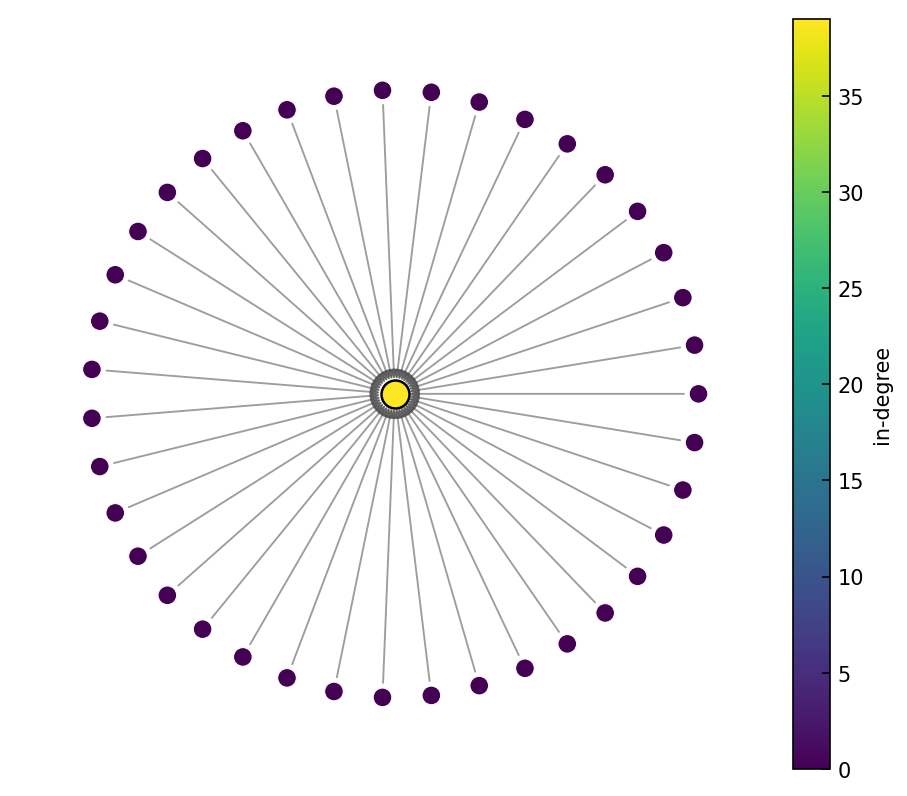

[A_N] classified as: A_N (A/B/C) | hubs: [39] | rho=None
[A_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0_din1_dout3_20250911-180507/A_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250911_180539


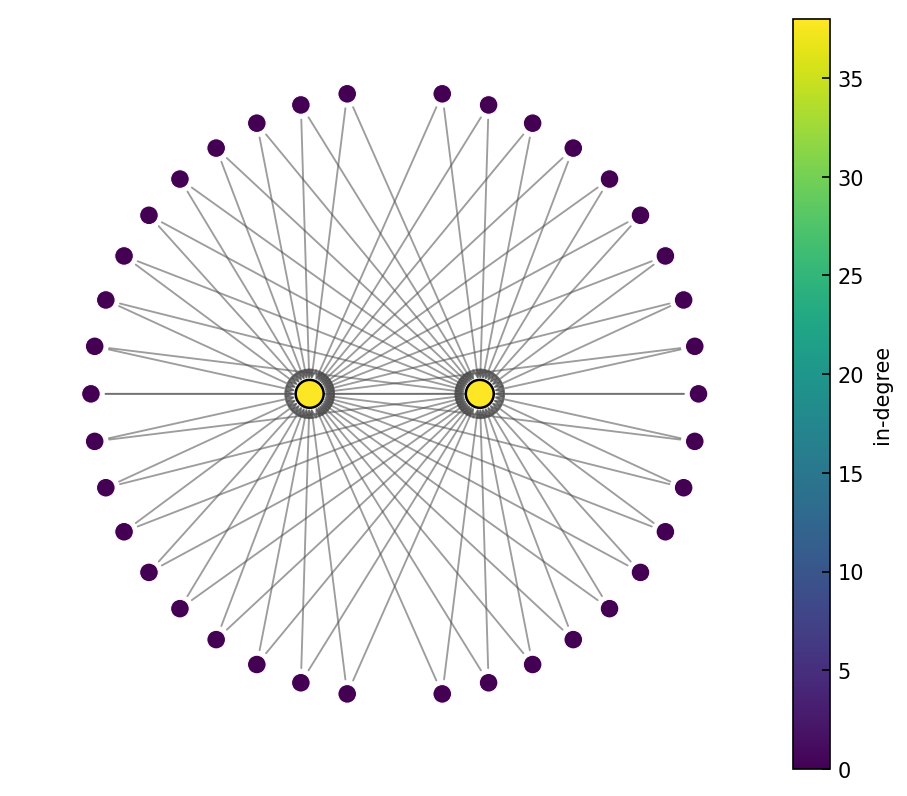

[B_N] classified as: C_N (A/B/C) | hubs: [38 39] | rho=0.05354873112516684
[B_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0_din1_dout3_20250911-180507/B_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250911_180606


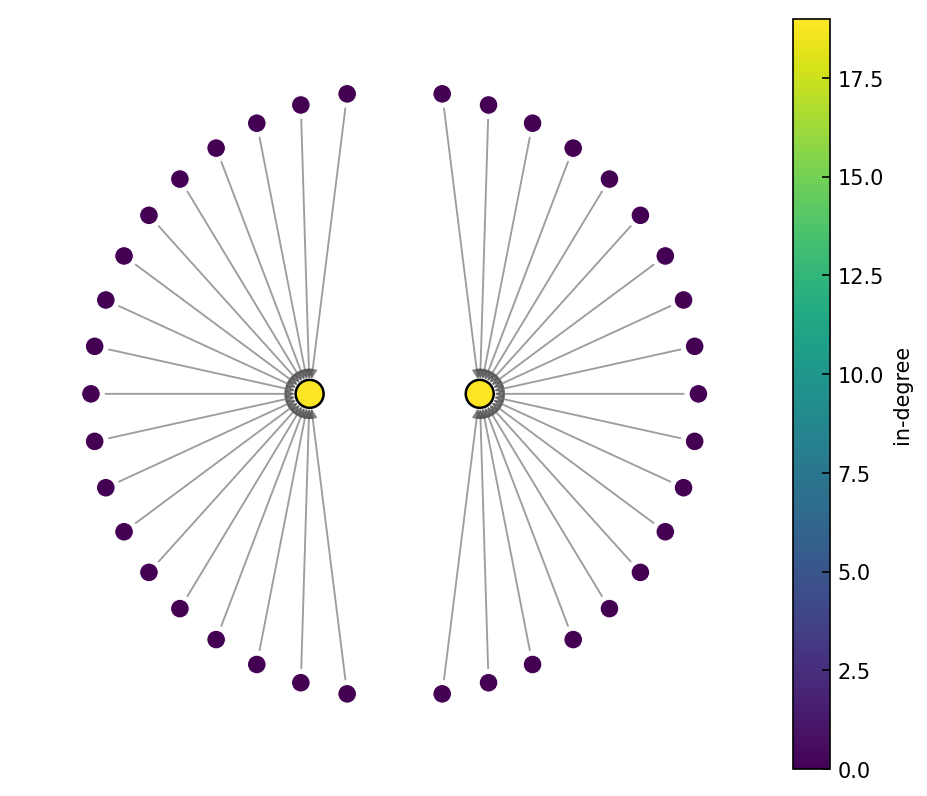

[C_N] classified as: C_N (A/B/C) | hubs: [38 39] | rho=-0.01649090567079993
[C_N] BC correlation figures saved at: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0_din1_dout3_20250911-180507/C_N/BCCorrection_M10_G2048_ridge0.0_tau0.4_20250911_180624
[BC varY matching] label=first_is_B  | saved to: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0_din1_dout3_20250911-180507/BC_varY_matching_20250911_180634
[OK] All figures & data saved to: figs/unknown_f_AvsBC_N40_T6000_discard600_M10_grid2048_ridge0_seed0_alpha0p05_ple0_din1_dout3_20250911-180507


In [472]:
if __name__ == "__main__":
    # ===== 你的实验超参（按需要修改）=====
    p_leaf_edge   = 0.0
    delta_in_max  = 1
    delta_out_max = 3
    seed_graph0   = 1            # 生成图/仿真的随机种子起点
    N, T, discard = 40, 6000, 600
    alpha         = "0.05"       # 生成轨迹用；分类器对 f 未知
    M             = 10
    grid_size     = 2048
    ridge         = 0.0
    seed_clf      = 0            # 分类器/GMM 的随机种子

    # ---- (0) 一次运行的大文件夹（含时间戳+超参）----
    params = {
        "N": N, "T": T, "discard": discard,
        "M": M, "grid": grid_size, "ridge": ridge,
        "seed": seed_clf, "alpha": alpha,
        "p_leaf_edge": p_leaf_edge, "delta_in_max": delta_in_max, "delta_out_max": delta_out_max,
    }
    run_dir = build_run_dir_unknown_f(params, base_dir="figs", algo_tag="unknown_f_AvsBC")
    print(f"[RUN] output dir: {run_dir}")

    # h(x_h, y) = coupling(xs=y, xt=x_h) —— 按你的方向约定
    coupling  = coupling_cosxy  # 你的 Decimal 耦合：xs -> xt（y 指向 x）
    h_func, H_grid = build_numpy_h_from_decimal_grid(coupling, G=512, progress=False)

    # ---- (1) 逐个段（A/B/C）生成 → 分类 → 各自子文件夹出图 ----
    trajB = trajC = None
    outB  = outC  = None

    seed_graph = seed_graph0
    for gname, maker in [("A_N", graph_A),
                         ("B_N", graph_B),
                         ("C_N", graph_C)]:

        # 1) 生成图（兼容 maker 有/无关键字两种接口）
        try:
            A = maker(N, p_leaf_edge=p_leaf_edge,
                         delta_in_max=delta_in_max,
                         delta_out_max=delta_out_max,
                         seed=seed_graph)
        except TypeError:
            A = maker(N)  # 回退老接口

        local_map = lambda x: Decimal(2) * x % Decimal(1)
        coupling  = coupling_x2y2  # 你的 Decimal 耦合：xs -> xt（y 指向 x）

        gs = GraphSystemDecimal(A, alpha=alpha, local_map=local_map, coupling_fn=coupling, seed=seed_graph)
        seed_graph += 1

        # 2) 子文件夹：A_N / B_N / C_N
        subdir = ensure_subdir(run_dir, gname)

        # 3) 可选保存图结构（若有 gs.plot_graph）
        if hasattr(gs, "plot_graph"):
            try:
                gs.plot_graph(savepath=os.path.join(subdir, "graph.png"))
            except TypeError:
                try:
                    gs.plot_graph()
                    plt.savefig(os.path.join(subdir, "graph.png"), dpi=300, bbox_inches="tight")
                    plt.close()
                except Exception:
                    pass

        # 4) 仿真
        traj = gs.run(T, discard)

        # 5) 你的 A/B/C 分类管线（可假设能正确识别 A）
        out = classify_ABC_pipeline(
            traj=traj,
            M=M,
            grid_size=grid_size,
            ridge=ridge,
            seed=seed_clf,
            tau=0.4,                       # 论文建议 0.3~0.6；默认 0.4
            m_h_vec=m_h_vec_default        # 老算法的接口，不影响我们新算法
        )
        print(f"[{gname}] classified as: {out['label_final']} (A/B/C) | hubs: {out['hubs_idx']} | rho={out.get('rho_hubs')}")

        # 6) 你已有的保存
        node_labels = np.arange(traj.shape[0])  # 节点编号
        save_all_plots_unknown_f(
            result=out,
            outdir=subdir,
            node_labels=node_labels,
            title_suffix=f"{gname}, M={M}, grid={grid_size}, ridge={ridge}",
            annotate_bar="hubs"
        )
        bc_corr_dir = save_bc_correlation_figures(
            traj=traj,
            result=out,
            outdir_graph=subdir,     # 就放在该段的子文件夹下
            params=params,
            tau=0.4,                 # 与分类用阈值一致
            m_h_vec=m_h_vec_default
        )
        print(f"[{gname}] BC correlation figures saved at: {bc_corr_dir}")

        # 7) 可选：保存该段的 \hat f 在网格上的预测（便于附录/验证）
        try:
            grid = np.linspace(0.0, 1.0, 64, endpoint=False)
            f_grid = evaluate_f_hat(out["f_hat"], grid)
            np.save(os.path.join(subdir, "f_hat_grid_x.npy"), grid)
            np.save(os.path.join(subdir, "f_hat_grid_fx.npy"), f_grid)
        except Exception:
            pass

        # 收集 B/C 两段（供 varY 匹配使用）
        if gname == "B_N":
            trajB, outB = traj, out
        elif gname == "C_N":
            trajC, outC = traj, out

    # ---- (2) 两段匹配：纯 varY 法（无 correction、无 e） ----
    if (trajB is not None) and (trajC is not None):
        h_func, H_grid = build_numpy_h_from_decimal_grid(coupling, G=512, progress=False)
        meta_varY = classify_BC_two_segments_varY(
            traj1=trajB, traj2=trajC,
            out1_algo1=outB, out2_algo1=outC,
            h_func=h_func,
            N=N,
            save_root=run_dir,
            n_samples_lambda=100_000, burn_in=2_000, n_chains=8, thinning=5,
            y_for_var_max=4096,
            seed=seed_clf
        )
        print(f"[BC varY matching] label={meta_varY['label']}  | saved to: {meta_varY['outdir']}")
    else:
        print("[WARN] 本次运行未同时生成 B_N 与 C_N 段，跳过 varY 匹配。")

    print(f"[OK] All figures & data saved to: {run_dir}")


In [ ]:
#此后代码没用

In [356]:
# ========================= ADD-ON: 可视化与适配工具 =========================
import os, time, json
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Dict, Any, List, Tuple
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --- 与你保持一致的 JSON 安全化 ---
def _to_jsonable(obj):
    import numpy as np
    if isinstance(obj, dict):   return {k:_to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list,tuple)): return [_to_jsonable(v) for v in obj]
    if isinstance(obj, (np.integer,)):  return int(obj)
    if isinstance(obj, (np.floating,)): return float(obj)
    if isinstance(obj, (np.bool_,)):    return bool(obj)
    if isinstance(obj, np.ndarray):     return obj.tolist()
    return obj

def _ts_dir(root: str, tag: str) -> str:
    ts = time.strftime("%Y%m%d_%H%M%S")
    out = os.path.join(root, f"{tag}_{ts}")
    os.makedirs(out, exist_ok=True)
    return out

def moddiff(z: np.ndarray) -> np.ndarray:
    return ((z + 0.5) % 1.0) - 0.5

# ---------- 1) hub 经验测度（把两个 hub 的时间序列拼起来，降方差） ----------
def hub_empirical_series(traj: np.ndarray, hubs_idx: np.ndarray) -> np.ndarray:
    seqs = []
    for h in np.atleast_1d(hubs_idx)[:2]:
        seqs.append(traj[h, :])
    return np.concatenate(seqs, axis=0)

def plot_density_1d(samples: np.ndarray, out_png: str, title: str):
    fig, ax = plt.subplots(figsize=(6.4, 3.8))
    ax.hist(samples, bins=256, range=(0,1), density=True, alpha=0.9)
    ax.set_xlim(0,1); ax.set_xlabel("x in [0,1)"); ax.set_ylabel("density")
    ax.set_title(title)
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 2) 从 f̂ 抽样 λ，并画 λ 直方图、h̄ 曲线（基于样本） ----------
def hbar_from_samples_factory(h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                              y_samples: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
    Y = np.atleast_1d(y_samples)
    def hbar_vec(xh: np.ndarray) -> np.ndarray:
        # xh: (T,) ; 计算 E_y h(xh,y) ≈ 平均
        H = h_func(np.atleast_1d(xh)[:, None], Y[None, :])  # (T, S)
        return H.mean(axis=1)
    return hbar_vec

def plot_hbar_curve(hbar_vec: Callable[[np.ndarray], np.ndarray], out_png: str, G: int = 1024):
    grid = np.linspace(0.0, 1.0, G, endpoint=False)
    hb   = hbar_vec(grid)
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(grid, hb, lw=1.2)
    ax.set_xlim(0,1); ax.set_xlabel("x"); ax.set_ylabel(r"$\bar h(x)$")
    ax.set_title(r"$\bar h(x)=\int h(x,y)\,d\lambda(y)$ (from empirical $\lambda$)")
    plt.tight_layout(); plt.savefig(out_png, dpi=240, bbox_inches="tight"); plt.close(fig)

# ---------- 3) 为某个 hub 选择“代表性叶子”用于二维联合测度 ----------
def select_leaf_for_hub_by_corr(traj: np.ndarray,
                                hub_idx: int,
                                models_all: List['TrigMap'],
                                h_func: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[int, float]:
    """
    选择与 hub 残差最相关的叶子（按 Corr(h(x_h, x_j), residual_h) 最大的 |corr|）。
    返回：(leaf_index, corr_value)
    """
    xh = traj[hub_idx, :-1]                    # (T-1,)
    yh = traj[hub_idx,  1:]
    r_h = moddiff(yh - models_all[hub_idx].predict_next(xh))  # (T-1,)
    leaves = np.setdiff1d(np.arange(traj.shape[0]), hub_idx)
    X = traj[leaves, :-1]                      # (L, T-1)
    Hvals = h_func(xh[None, :], X)             # (L, T-1)
    Hc = Hvals - Hvals.mean(axis=1, keepdims=True)
    rc = r_h - r_h.mean()
    denom = np.linalg.norm(Hc, axis=1) * (np.linalg.norm(rc) + 1e-12)
    corr = (Hc @ rc) / (denom + 1e-12)         # (L,)
    j_local = int(np.argmax(np.abs(corr)))
    return int(leaves[j_local]), float(corr[j_local])

# ---------- 4) 3D：联合测度 vs 乘积测度 ----------
def plot_joint_vs_product_3d(x_h: np.ndarray, x_leaf: np.ndarray,
                             hub_samples_for_marginal: np.ndarray,
                             lambda_samples: np.ndarray,
                             out_png: str, bins: int = 64, title: str = "") -> Dict[str, float]:
    """
    - x_h, x_leaf: 来自真实序列（长度 ~T）
    - hub_samples_for_marginal: 用于估计中心节点边际（建议用 x_h 自身，或合并两个 hub）
    - lambda_samples: 从 f̂ 抽样得到的 λ
    """
    H2, xedges, yedges = np.histogram2d(x_h, x_leaf, bins=bins,
                                        range=[[0,1],[0,1]], density=True)
    xc = 0.5 * (xedges[:-1] + xedges[1:])
    yc = 0.5 * (yedges[:-1] + yedges[1:])
    # 边际
    dens_h, _ = np.histogram(hub_samples_for_marginal, bins=xedges, density=True)
    dens_l, _ = np.histogram(lambda_samples,          bins=yedges, density=True)
    Zprod = np.outer(dens_h, dens_l)                  # (bins, bins)

    Xg, Yg = np.meshgrid(xc, yc, indexing='ij')

    # 3D
    fig = plt.figure(figsize=(8.0, 5.8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Xg, Yg, H2, rstride=1, cstride=1, alpha=0.7, linewidth=0, antialiased=True)
    ax.plot_wireframe(Xg, Yg, Zprod, rstride=3, cstride=3, color='k', linewidth=0.6, alpha=0.9)
    ax.set_xlabel("hub x"); ax.set_ylabel("leaf y"); ax.set_zlabel("density")
    ax.set_title(title if title else "Joint vs. Product density")
    plt.tight_layout(); plt.savefig(out_png, dpi=230, bbox_inches="tight"); plt.close(fig)

    # TV 距离（对密度做积分近似）
    dx = (xedges[1]-xedges[0]); dy = (yedges[1]-yedges[0])
    TV = 0.5 * float(np.sum(np.abs(H2 - Zprod)) * dx * dy)
    return {"tv_joint_product": TV}

# ---------- 5) 每个序列的“附加可视化”主函数（不改你已有匹配函数） ----------
def save_segment_extras(traj: np.ndarray,
                        out_algo1: Dict[str, Any],
                        h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
                        save_dir: str,
                        seg_tag: str,
                        n_samples: int = 100_000, burn_in: int = 2_000,
                        n_chains: int = 8, thinning: int = 5, seed: int = 0) -> Dict[str, Any]:
    """
    对单个序列做：
      - 用该段 f̂ 抽样 λ 并画直方图
      - 画 \bar h(x)
      - 画 hub 经验密度（两个 hub 合并）
      - 选一个 hub 与一个代表叶子，画“联合 vs 乘积”的 3D 对比
    说明：不返回 traj/out 的原始信息，以免与上游结构冲突。
    """
    os.makedirs(save_dir, exist_ok=True)
    f_hat  = out_algo1["f_hat"]
    hubs   = np.atleast_1d(out_algo1["hubs_idx"]).astype(int)
    models = out_algo1["models"]

    # 1) 抽样 λ
    Y = sample_invariant_from_fhat(f_hat, n_samples=n_samples, burn_in=burn_in,
                                   n_chains=n_chains, thinning=thinning, seed=seed)
    plot_density_1d(Y, os.path.join(save_dir, f"{seg_tag}_lambda_hist.png"),
                    title=f"{seg_tag}: empirical invariant measure λ")

    # 2) 画 \bar h(x)
    hbar_vec = hbar_from_samples_factory(h_func, Y)
    plot_hbar_curve(hbar_vec, os.path.join(save_dir, f"{seg_tag}_hbar_curve.png"), G=1024)

    # 3) hub 经验密度（两个 hub 合并）
    hub_data = hub_empirical_series(traj, hubs)
    plot_density_1d(hub_data, os.path.join(save_dir, f"{seg_tag}_hub_density.png"),
                    title=f"{seg_tag}: empirical hub density")

    # 4) 选一个 hub 与代表叶子，画联合 vs 乘积（3D）
    hub_chosen = int(hubs[0])
    leaf_idx, corr_val = select_leaf_for_hub_by_corr(traj, hub_chosen, models, h_func)
    x_h  = traj[hub_chosen, :-1]
    x_l  = traj[leaf_idx,  :-1]
    tvd  = plot_joint_vs_product_3d(
        x_h, x_l, hub_samples_for_marginal=x_h, lambda_samples=Y,
        out_png=os.path.join(save_dir, f"{seg_tag}_joint_vs_product_3D.png"),
        bins=64, title=f"{seg_tag}: joint vs product (hub={hub_chosen}, leaf={leaf_idx})"
    )
    # 返回概要
    return {
        "seg_tag": seg_tag,
        "hub_chosen": hub_chosen,
        "leaf_chosen": leaf_idx,
        "corr_h_leaf": corr_val,
        "tv_joint_product": tvd["tv_joint_product"],
        "lambda_sample_size": int(n_samples)
    }

# ---------- 6) 一键：运行你已有的两段匹配 + 附加可视化（最小改动接入） ----------
def run_two_segment_match_with_emp_lambda_and_extras(
        traj1: np.ndarray, traj2: np.ndarray,
        h_func: Callable[[np.ndarray, np.ndarray], np.ndarray],
        M: int = 10, ridge: float = 0.0, seed: int = 0,
        save_root: str = "figs",
        n_samples: int = 100_000, burn_in: int = 2_000,
        n_chains: int = 8, thinning: int = 5
    ) -> Dict[str, Any]:
    """
    不改动你已有的 run_two_segment_match_with_emp_lambda：
      1) 先调用它完成两段匹配（α^2 能量法）+ 基础图 + meta
      2) 重新各自跑一次 算法1 拿到 out1/out2（hubs/models/f̂）
      3) 对两个序列分别调用 save_segment_extras 画附加图
    """
    # 1) 你的现成入口（保持接口不变）
    base = run_two_segment_match_with_emp_lambda(
        traj1, traj2, h_func=h_func, M=M, ridge=ridge, seed=seed,
        save_root=save_root, n_samples=n_samples, burn_in=burn_in,
        n_chains=n_chains, thinning=thinning
    )
    outdir_base = base["outdir"]
    # 2) 算法1：各段 A vs BC（为拿到 hubs/models/f̂；不改你已有逻辑）
    out1 = classify_A_vs_BC_unknown_f(traj1, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed, return_indices=True, return_fhat=True)
    out2 = classify_A_vs_BC_unknown_f(traj2, M=M, grid_size=2048, ridge=ridge,
                                      seed=seed+1, return_indices=True, return_fhat=True)

    # 3) 附加可视化（每段独立的 λ、h̄、hub 密度、二维联合 vs 乘积）
    extras_dir = _ts_dir(outdir_base, "BC_extras")
    seg1_info = save_segment_extras(
        traj1, out1, h_func, extras_dir, seg_tag="seg1",
        n_samples=n_samples, burn_in=burn_in, n_chains=n_chains, thinning=thinning, seed=seed
    )
    seg2_info = save_segment_extras(
        traj2, out2, h_func, extras_dir, seg_tag="seg2",
        n_samples=n_samples, burn_in=burn_in, n_chains=n_chains, thinning=thinning, seed=seed+1
    )
    # 4) 汇总 meta
    summary = {
        "outdir": outdir_base,
        "extras_dir": extras_dir,
        "matching_label": base.get("label"),
        "seg1": seg1_info,
        "seg2": seg2_info
    }
    with open(os.path.join(extras_dir, "extras_meta.json"), "w", encoding="utf-8") as f:
        json.dump(_to_jsonable(summary), f, indent=2, ensure_ascii=False)
    print(f"[EXTRAS] saved to {extras_dir}")
    return summary

# ---------- 7) 若你的耦合是 Decimal 版本，提供浮点包装 → h_func ----------
from decimal import Decimal
def make_h_from_coupling_decimal(coupling_fn) -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
    """
    将 Decimal 耦合函数 coupling_fn(xs, xt) 封装成 h_func(xh, X)
    - xh: (T-1,), 表示 hub 的时间序列
    - X : (m, T-1), 叶子时间序列矩阵
    返回: (m, T-1)，元素为 coupling_fn(xs=X[i,t], xt=xh[t]) 的浮点化结果
    注意：此实现为通用循环版，简洁但较慢；若有 NumPy 向量表达式，建议改为纯向量化。
    """
    def h_func(xh: np.ndarray, X: np.ndarray) -> np.ndarray:
        xh = np.atleast_1d(xh)
        X  = np.atleast_2d(X)
        m, Tm = X.shape[0], X.shape[-1]
        assert xh.shape[-1] == Tm, "xh 和 X 的时间长度必须一致"
        out = np.empty((m, Tm), dtype=float)
        for t in range(Tm):
            xt = Decimal(str(xh[t]))  # 目标 hub
            for i in range(m):
                ys = Decimal(str(X[i, t]))  # 源叶子
                out[i, t] = float(coupling_fn(ys, xt))  # 顺序：xs=叶, xt=hub
        return out
    return h_func



A_N  → classify_ABC → A_N
B_N  → classify_ABC → B_N and C_N
C_N  → classify_ABC → B_N and C_N

B/C decision: first_is_B
D_BC=3.150e-01 (seg1=B, seg2=C) | D_CB=1.071e+00 (seg1=C, seg2=B)
alpha^2 under (B,C) = (0.0864600922015174, 0.06309466447546742)
alpha^2 under (C,B) = (0.0432300461007587, 0.12618932895093485)


A_N  → classify_ABC → A_N
B_N  → classify_ABC → B_N and C_N
C_N  → classify_ABC → B_N and C_N

B/C decision: first_is_B
D_BC=3.141e-01 (seg1=B, seg2=C) | D_CB=1.072e+00 (seg1=C, seg2=B)
alpha^2 under (B,C) = (0.08562910549884833, 0.06254701302597973)
alpha^2 under (C,B) = (0.04281455274942417, 0.12509402605195946)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
B/C star-network classifier via alpha^2-consistency and hub empirical law.

This module provides:
  1) A high-precision coupled-map simulator on a directed graph with states on
     the one-dimensional torus T = R/Z (represented by [0, 1)).
  2) Star-graph generators for types A, B, and C.
  3) Utilities to detect hubs from data (2-component GMM on per-node errors).
  4) Segment-level statistics for hubs:
       - residual variance V (from a least-squares regression y ~ m_h(x)),
       - empirical expectation K_hat = <K(x_t)> using the hub time series,
     where m_h(x) = ∫ h(x,y) dm(y) and K(x) = Var_y[h(x,y)] are known in closed form.
  5) A parameter-free B-vs-C classifier that uses two time segments with a
     common (unknown) coupling strength α and decides which segment is B and
     which is C by comparing the consistency of the implied α^2 under the
     two topological hypotheses.

Default model (matches the math write-up):
  - Local map: f(x) = 2 x (mod 1).
  - Coupling  : h(x, y) = 2 sin(x) sin(y).  (x, y are angles in radians.)
  - Invariant measure for leaves: Lebesgue on the circle.
  - Normalization: the coupling term at node i is divided by Δ = max in-degree.

Dependencies:
  numpy, mpmath, scikit-learn (GaussianMixture).
"""

from __future__ import annotations

from decimal import Decimal, getcontext
from typing import Callable, Tuple, Dict, Any

import mpmath as mp
import numpy as np
from sklearn.mixture import GaussianMixture


# ---------------------------------------------------------------------
# Global precision for Decimal and mpmath (used in the simulator)
# ---------------------------------------------------------------------
getcontext().prec = 200     # Decimal precision
mp.mp.dps = getcontext().prec


# ---------------------------------------------------------------------
# High-precision network simulator
# ---------------------------------------------------------------------
class GraphSystemDecimal:
    """
    Coupled-map lattice on a directed graph with high-precision arithmetic.

    State space: one-dimensional torus T = R/Z (represented by [0, 1)).
    Update rule for node n (mod 1):
        x_n(t+1) = f(x_n(t)) + (alpha / Delta) * sum_{j: A[j, n]=1} h(x_n(t), x_j(t)),
    where Delta = max in-degree over all nodes.

    Parameters
    ----------
    A : np.ndarray (N x N)
        Directed adjacency matrix. A[j, i] = 1 means edge j -> i (j contributes to i).
    alpha : str
        Coupling strength as a string, parsed into Decimal for precision.
    local_map : Callable[[Decimal], Decimal], optional
        Local map f acting on Decimal in [0,1). Default: doubling map (2*x) % 1.
    coupling_fn : Callable[[Decimal, Decimal], Decimal], optional
        Pairwise coupling h(xs, xt) from source xs to target xt. Default: 2 sin xs sin xt.
    seed : int
        RNG seed for i.i.d. Uniform(0,1) initialization of the states.

    Attributes
    ----------
    N : int
        Number of nodes.
    Delta : float
        Maximum in-degree (max column sum of A), used for normalization.
    x : list[Decimal]
        Current state vector.
    """

    def __init__(
        self,
        A: np.ndarray,
        alpha: str = "0.25",
        local_map: Callable[[Decimal], Decimal] | None = None,
        coupling_fn: Callable[[Decimal, Decimal], Decimal] | None = None,
        seed: int = 0,
    ):
        self.A = np.asarray(A, dtype=float)
        self.N = self.A.shape[0]
        # Max in-degree (column sum) for normalization
        self.Delta = self.A.sum(axis=0).max()
        self.alpha = Decimal(alpha)
        # Default local map: doubling map on the circle
        self.local_map = local_map or (lambda z: (Decimal(2) * z) % 1)
        # Default coupling: h(xs, xt) = 2 sin xs sin xt
        self.coupling = coupling_fn or coupling_sin_sin
        self.rng = np.random.default_rng(seed)
        self.reset()

    def _coupling_term(self) -> list[Decimal]:
        """
        Compute the normalized coupling increment for each node.

        Returns
        -------
        list[Decimal]
            For each node i, the quantity (1/Delta) * sum_{j} A[j, i] * h(x_j, x_i).
        """
        incr = [Decimal(0)] * self.N
        for j in range(self.N):
            if self.A[j].sum() == 0:
                continue  # node j has no outgoing edges
            for i in range(self.N):
                if self.A[j, i]:
                    incr[i] += self.coupling(self.x[j], self.x[i])
        d = Decimal(str(self.Delta))
        return [v / d for v in incr]

    def step(self) -> list[Decimal]:
        """
        Advance the system by one step: x <- f(x) + alpha * coupling (mod 1).

        Returns
        -------
        list[Decimal]
            The updated state vector.
        """
        xn = [self.local_map(x) for x in self.x]  # apply f
        coup = self._coupling_term()
        xn = [(xi + self.alpha * ci) % 1 for xi, ci in zip(xn, coup)]
        self.x = xn
        return xn

    def reset(self) -> None:
        """Reset states to i.i.d. Uniform(0,1) in Decimal precision."""
        self.x = [Decimal(str(v)) for v in self.rng.random(self.N)]

    def run(self, T: int, discard: int = 0) -> np.ndarray:
        """
        Simulate for T steps and return the trajectory after discarding a transient.

        Parameters
        ----------
        T : int
            Total number of simulation steps.
        discard : int
            Number of initial steps to discard as transient.

        Returns
        -------
        np.ndarray
            Array of shape (N, max(0, T - discard)) with float64 snapshots of states.
        """
        traj = np.zeros((self.N, max(0, T - discard)))
        for k in range(T):
            xt = self.step()
            if k >= discard:
                traj[:, k - discard] = [float(v) for v in xt]
        return traj


# ---------------------------------------------------------------------
# Star graph generators (A: single hub; B: two hubs, all leaves to both;
# C: two hubs, leaves split into two disjoint halves)
# ---------------------------------------------------------------------
def graph_A(N: int) -> np.ndarray:
    """Star with one hub at index N-1 (all leaves point to the hub)."""
    A = np.zeros((N, N))
    A[np.arange(N - 1), N - 1] = 1
    return A


def graph_B(N: int) -> np.ndarray:
    """Two hubs at indices N-2 and N-1; every leaf connects to both hubs."""
    A = np.zeros((N, N))
    leaves = np.arange(N - 2)
    A[leaves, N - 1] = 1
    A[leaves, N - 2] = 1
    return A


def graph_C(N: int) -> np.ndarray:
    """
    Two hubs at indices N-2 and N-1; the leaves (0..N-3) are split evenly:
    first half -> hub N-2, second half -> hub N-1.
    """
    A = np.zeros((N, N))
    L = N - 2       # number of leaves
    half = L // 2
    first = np.arange(0, half)
    second = np.arange(half, L)
    A[first, N - 2] = 1
    A[second, N - 1] = 1
    return A

def graph_A_like(N: int) -> np.ndarray:
    """Star with one hub at index N-1 (all leaves point to the hub)."""
    A = np.zeros((N, N))
    A[np.arange(N - 1), N - 1] = 1
    return A


def graph_B_like(N: int) -> np.ndarray:
    """Two hubs at indices N-2 and N-1; every leaf connects to both hubs."""
    A = np.zeros((N, N))
    leaves = np.arange(N - 2)
    A[leaves, N - 1] = 1
    A[leaves, N - 2] = 1
    A_leaves=np.arange(0,int(N/3)-2)
    B_leaves=np.arange(int(N*2/3),N-2)
    A[A_leaves,N-1]=0
    A[B_leaves,N-2]=0
    return A


def graph_C_like(N: int) -> np.ndarray:
    """
    Two hubs at indices N-2 and N-1; the leaves (0..N-3) are split evenly:
    first half -> hub N-2, second half -> hub N-1.
    """
    A = np.zeros((N, N))
    L = N - 2       # number of leaves
    half = L // 2
    first = np.arange(0, half)
    second = np.arange(half, L)
    A[first, N - 2] = 1
    A[second, N - 1] = 1
    return A


# ---------------------------------------------------------------------
# Model-specific h, its integral m_h, and the variance kernel K
#   h(x, y) = 2 sin x sin y   (angles in radians)
#   m_h(x)  = ∫ h(x, y) dm(y) = C1 sin x
#   K(x)    = Var_y[h(x, y)]  = CK sin^2 x
# ---------------------------------------------------------------------
def coupling_sin_sin(xs: Decimal, xt: Decimal) -> Decimal:
    """High-precision coupling: h(xs, xt) = 2 sin(xs) sin(xt)."""
    v = 2.0 * float(mp.sin(mp.mpf(str(xs)))) * float(mp.sin(mp.mpf(str(xt))))
    return Decimal(str(v))


C1 = 2.0 * (1.0 - np.cos(1.0))                       # coefficient in m_h(x)
CK = (2.0 - np.sin(2.0)) - C1**2                     # coefficient in K(x)


def doubling_vec(u: np.ndarray) -> np.ndarray:
    """Vectorized local map f(x) = 2x (mod 1) acting elementwise."""
    return (2.0 * u) % 1.0


def Ih_vec(u: np.ndarray) -> np.ndarray:
    """Vectorized m_h(x) = C1 * sin(x)."""
    return C1 * np.sin(u)


def K_vec(u: np.ndarray) -> np.ndarray:
    """Vectorized K(x) = CK * sin(x)^2."""
    return CK * np.sin(u) ** 2


# ---------------------------------------------------------------------
# Utilities: modular difference, node-wise strength, and hub detection
# ---------------------------------------------------------------------
def moddiff(u: np.ndarray) -> np.ndarray:
    """
    Wrap values into (-0.5, 0.5] by subtracting the nearest integer.
    Useful for measuring errors on the circle.
    """
    return ((u + 0.5) % 1.0) - 0.5


def compute_strength(traj: np.ndarray) -> np.ndarray:
    """
    Per-node mean absolute innovation relative to the local map:
      S_i = < |x_{t+1,i} - f(x_{t,i})|_{mod 1} >_t.

    Parameters
    ----------
    traj : np.ndarray (N x T)

    Returns
    -------
    np.ndarray (N,)
        Mean wrapped absolute error for each node.
    """
    x, x1 = traj[:, :-1], traj[:, 1:]
    Delta = moddiff(x1 - doubling_vec(x))
    return np.abs(Delta).mean(axis=1)


def gmm_hubs(S: np.ndarray, seed: int = 0) -> np.ndarray:
    """
    Identify hubs by a 2-component Gaussian Mixture Model (GMM) fitted to S.
    The component with the larger mean is labeled as hubs.

    Parameters
    ----------
    S : np.ndarray (N,)
        Node-wise strengths.
    seed : int

    Returns
    -------
    np.ndarray (N,) of bool
        True for nodes classified as hubs.
    """
    g = GaussianMixture(2, random_state=seed).fit(S.reshape(-1, 1))
    return g.predict(S.reshape(-1, 1)) == np.argmax(g.means_)


# ---------------------------------------------------------------------
# Residual variance at a single hub:
#   y_t = x_{t+1} - f(x_t)   (wrapped)
#   s_t = m_h(x_t)
#   beta = argmin_b || y + b * s ||_2^2  =  -(y·s)/(s·s)
#   residual r_t = y_t + beta s_t
#   V = Var_t(r_t)
# ---------------------------------------------------------------------
def resid_var_one(traj_i: np.ndarray, eps: float = 1e-12) -> float:
    """
    Residual variance for a single node time series.

    Parameters
    ----------
    traj_i : np.ndarray (T,)
        Time series of a single hub.
    eps : float
        Threshold to guard against division by zero in LS.

    Returns
    -------
    float
        Variance of residuals r_t = y_t + beta s_t.
    """
    x = traj_i[:-1]
    y = moddiff(traj_i[1:] - doubling_vec(x))
    s = Ih_vec(x)
    denom = float(s @ s)
    beta = 0.0 if denom < eps else -(y @ s) / denom
    resid = y + beta * s
    return float(np.var(resid))


# ---------------------------------------------------------------------
# Segment-level statistics for hubs:
#   V_hat = mean residual variance across the two hubs,
#   K_hat = mean of K(x_t) across the two hubs (i.e. empirical E K(x))
# ---------------------------------------------------------------------
def hub_stats_segment(traj: np.ndarray, seed: int = 0) -> Tuple[float, float, np.ndarray]:
    """
    Compute (V_hat, K_hat) for a single B/C candidate segment.

    Parameters
    ----------
    traj : np.ndarray (N x T)
        Segment trajectory.
    seed : int
        RNG seed used by GMM.

    Returns
    -------
    (V_hat, K_hat, hubs)
        V_hat : float
            Mean residual variance across the two hubs in the segment.
        K_hat : float
            Mean of K(x_t) across the two hubs (empirical expectation).
        hubs : np.ndarray (size 2)
            Indices of the two hubs.
    """
    S = compute_strength(traj)
    hubs = np.where(gmm_hubs(S, seed=seed))[0]
    if hubs.size != 2:
        raise RuntimeError("This segment is not type B/C (number of hubs ≠ 2).")
    V_list, K_list = [], []
    for i in hubs:
        xi = traj[i]
        V_list.append(resid_var_one(xi))
        K_list.append(float(np.mean(K_vec(xi[:-1]))))  # empirical E[K(x)] along the hub
    V_hat = float(np.mean(V_list))
    K_hat = float(np.mean(K_list))
    return V_hat, K_hat, hubs


# ---------------------------------------------------------------------
# Single-segment coarse classification: A vs (B/C)
# ---------------------------------------------------------------------
def classify_A_and_BC(traj: np.ndarray, N: int) -> str:
    """
    Decide whether a single segment corresponds to A (one hub) or B/C (two hubs).

    Returns
    -------
    str : "A_N" or "B_N and C_N"
    """
    S = compute_strength(traj)
    hubs = np.where(gmm_hubs(S))[0]
    return "A_N" if hubs.size == 1 else "B_N and C_N"


# ---------------------------------------------------------------------
# Two-segment B vs C classifier via alpha^2-consistency
#   For each segment s (s=1,2):
#      - compute V_s and K_s from the hubs,
#      - form S_{s,B} = F_B K_s, S_{s,C} = F_C K_s,
#   Then compare the two hypotheses: (seg1=B, seg2=C) vs (seg1=C, seg2=B)
#   by the log-mismatch of the implied alpha^2.
# ---------------------------------------------------------------------
def classify_B_vs_C_two_segments(
    traj1: np.ndarray, traj2: np.ndarray, N: int, seed: int = 0
) -> Dict[str, Any]:
    """
    Classify which of the two segments is B and which is C under the assumption
    that both segments share the same (unknown) coupling strength alpha.

    Parameters
    ----------
    traj1, traj2 : np.ndarray (N x T)
        Two B/C candidate segments.
    N : int
        Number of nodes in the graph.
    seed : int
        RNG seeds used by the GMM calls.

    Returns
    -------
    dict
        A dictionary with the decision and useful diagnostics:
          - 'label'      : 'first_is_B' or 'first_is_C'
          - 'alpha2_BC'  : (alpha^2 estimate if seg1=B, seg2=C)
          - 'alpha2_CB'  : (alpha^2 estimate if seg1=C, seg2=B)
          - 'D_BC','D_CB': log-mismatches under the two hypotheses
          - 'V1','K1','V2','K2'
          - 'hubs1','hubs2'
          - 'fac_B','fac_C' (the topology factors used)
    """
    V1, K1, hubs1 = hub_stats_segment(traj1, seed=seed)
    V2, K2, hubs2 = hub_stats_segment(traj2, seed=seed + 1)

    # Topology factors d/Delta^2 (choose the convention you prefer).
    # Here we use: B → 1/(N-2), C → 1/(N/2 - 1).
    fac_B = 1.0 / (N - 2)
    fac_C = 1.0 / (N // 2 - 1)

    # Theoretical scalings without alpha^2
    S1B, S1C = fac_B * K1, fac_C * K1
    S2B, S2C = fac_B * K2, fac_C * K2

    # Alpha^2 estimates under the two global assignments
    a2_1_B, a2_2_C = V1 / S1B, V2 / S2C  # hypothesis: (seg1=B, seg2=C)
    a2_1_C, a2_2_B = V1 / S1C, V2 / S2B  # hypothesis: (seg1=C, seg2=B)

    # Log-mismatch of alpha^2 under each hypothesis
    D_BC = abs(np.log(a2_1_B) - np.log(a2_2_C))
    D_CB = abs(np.log(a2_1_C) - np.log(a2_2_B))

    label = "first_is_B" if D_BC < D_CB else "first_is_C"

    return {
        "label": label,
        "alpha2_BC": (a2_1_B, a2_2_C),
        "alpha2_CB": (a2_1_C, a2_2_B),
        "D_BC": D_BC,
        "D_CB": D_CB,
        "V1": V1,
        "K1": K1,
        "V2": V2,
        "K2": K2,
        "hubs1": hubs1,
        "hubs2": hubs2,
        "fac_B": fac_B,
        "fac_C": fac_C,
    }


# ---------------------------------------------------------------------
# Demonstration
# ---------------------------------------------------------------------
if __name__ == "__main__":
    N, T, discard = 50, 8000, 800
    alpha = "0.25"

    # 1) Single-segment A vs (B/C)
    for gname, maker in [("A_N", graph_A), ("B_N", graph_B), ("C_N", graph_C)]:
        traj = GraphSystemDecimal(maker(N), alpha=alpha, seed=hash(gname) % 2**32).run(
            T, discard
        )
        print(f"{gname}  → classify_ABC → {classify_A_and_BC(traj, N)}")

    # 2) Two segments: B vs C (alpha unknown but identical across segments)
    trajB = GraphSystemDecimal(graph_B_like(N), alpha=alpha, seed=1).run(T, discard)
    trajC = GraphSystemDecimal(graph_C_like(N), alpha=alpha, seed=2).run(T, discard)

    out = classify_B_vs_C_two_segments(trajB, trajC, N)
    print("\nB/C decision:", out["label"])
    print(
        f"D_BC={out['D_BC']:.3e} (seg1=B, seg2=C) | "
        f"D_CB={out['D_CB']:.3e} (seg1=C, seg2=B)"
    )
    print(f"alpha^2 under (B,C) = {out['alpha2_BC']}")
    print(f"alpha^2 under (C,B) = {out['alpha2_CB']}")
